In [1]:
import pandas as pd

In [66]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline 
from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 13, 5

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Load data

In [87]:
Train = pd.read_csv('../Data/train_modified_0229.csv')
Test = pd.read_csv('../Data/test_modified_0229.csv')

In [5]:
target='NewGameFanPTs'
IDcol = 'Player_ID'

In [6]:
predictors = [x for x in train.columns if x not in [target, IDcol, 'fullName']]

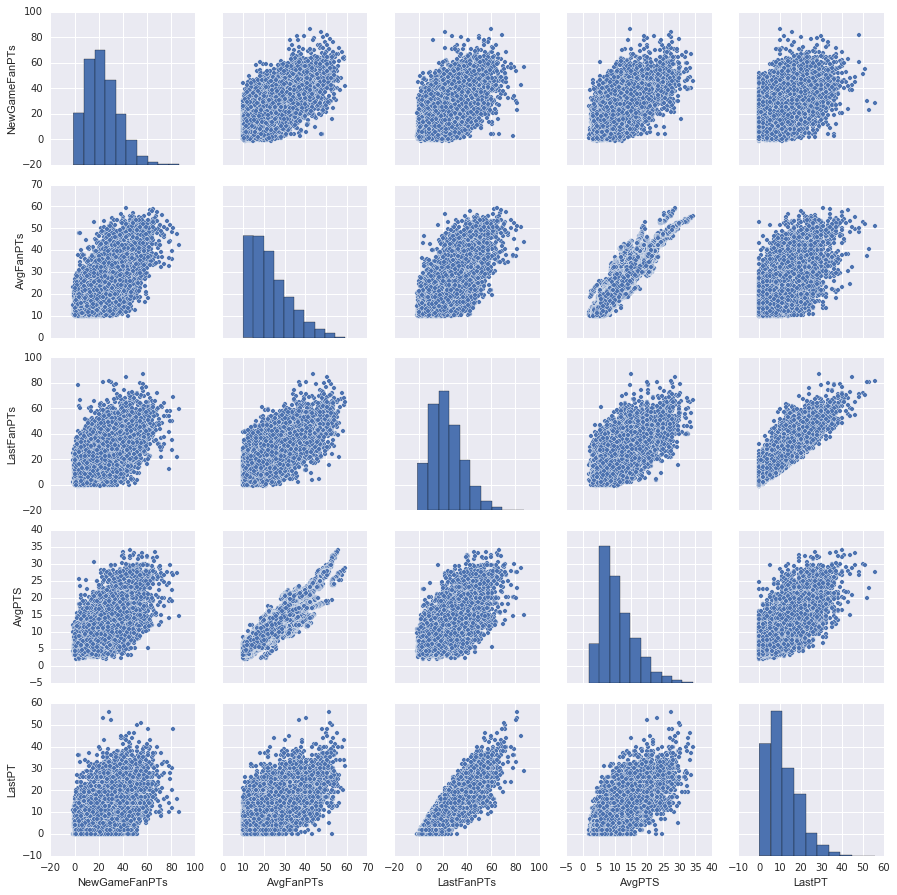

In [60]:
sns.pairplot(train[["NewGameFanPTs", "AvgFanPTs", "LastFanPTs","AvgPTS",'LastPT']])

From our observations, we can see that there exists nonlinear patterns, it would be difficult to fit a linear model for regression which requires a lot of variable transformation. We will use tree-based approach to do prediction.

## Baseline model - Random Forest Regression.

It can be understood as the sum of piecewise linear functions in contrast to the global linear and polynomial regression models. In other words, via the decision tree algorithm, we are subdividing the input space into smaller regions that become more manageable.

In [91]:
from sklearn.ensemble import RandomForestRegressor

In [92]:
forest = RandomForestRegressor(n_estimators = 1000, criterion ='mse',random_state = 1,n_jobs =-1) 

In [58]:
X_train = Train[predictors].values
y_train = Train[target].values
X_test = Test[predictors].values
y_test = Test[target].values

In [96]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [97]:
y_train_pred = forest.predict(X_train)

In [100]:
y_test_pred = forest.predict(X_test)

In [105]:
print('RMSE train: %.3f, test: %.3f'%(metrics.mean_squared_error(y_train, y_train_pred)**0.5,\
                                         metrics.mean_squared_error(y_test, y_test_pred)**0.5))

RMSE train: 3.573, test: 10.237


In [106]:
print('R^2 train: %.3f, test: %.3f' %(metrics.r2_score( y_train, y_train_pred),\
                                    metrics.r2_score( y_test, y_test_pred)))

R^2 train: 0.929, test: 0.493


####We have to deal with the significant overfitting issue!

##XGBoosting Implementation

In [7]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

Reasons:
- an efficient and scalable implementation of gradient boosting, 10 times faster than gradient boosting
- has more customizable parameters to control overfitting
- no need to do feature prepocessing and selection
- xgboost is more suited for the regression task than Adaboost


###General function

In [85]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print "number of estomators : "+ str(cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
                
    return alg,dtrain_predictions

In [18]:
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [46]:
model1,train_predictions = modelfit(xgb1, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.0825206667+0.186514554473	cv-train-rmse:24.0752673333+0.0786852442428
[1]	cv-test-rmse:22.099788+0.202718813518	cv-train-rmse:22.0837163333+0.0708870396068
[2]	cv-test-rmse:20.3465816667+0.210410193146	cv-train-rmse:20.3230453333+0.0702417911756
[3]	cv-test-rmse:18.795311+0.221191964128	cv-train-rmse:18.7613786667+0.0625123068221
[4]	cv-test-rmse:17.4465806667+0.230611967267	cv-train-rmse:17.397027+0.0564086068078
[5]	cv-test-rmse:16.2726976667+0.239630260846	cv-train-rmse:16.213566+0.0491925526681
[6]	cv-test-rmse:15.2550703333+0.247054118914	cv-train-rmse:15.178606+0.0421230637379
[7]	cv-test-rmse:14.3750363333+0.25137428833	cv-train-rmse:14.282421+0.0349035362201
[8]	cv-test-rmse:13.6109233333+0.257457848337	cv-train-rmse:13.503053+0.0290223956282
[9]	cv-test-rmse:12.962524+0.253791679668	cv-train-rmse:12.8421406667+0.027565733249
[10]	cv-test-rmse:12.4086193333+0.242246473363	cv-train-rmse:12.272608+0.0304

number of estomators : 54


In [11]:
from ggplot import *

In [22]:
def plot_predictions(pred_label,data):     
    plot_obj = ggplot(aes(x='NewGameFanPTs', y=pred_label, colour='Rank'), data=data)+geom_point()+\
    ggtitle(pred_label+" Prediction Performance")+ geom_abline(intercept = 0, slope = 1)
    return(plot_obj)

In [49]:
with open('../Data/xgboost_model1.pickle', 'wb') as handle:
  pickle.dump((model1,train_predictions),handle)

In [19]:
import pickle
with open('../Data/train_set_02_29.pickle', 'rb') as handle:
  train_set = pickle.load(handle)

In [8]:
import pickle
with open('../Data/xgboost_model1.pickle', 'rb') as handle:
   model1,train_predictions = pickle.load(handle)

In [16]:
train['train_predict'] = train_predictions

In [17]:
train.shape

(11670, 106)

In [20]:
train['Rank'] = train_set['Rank'].values

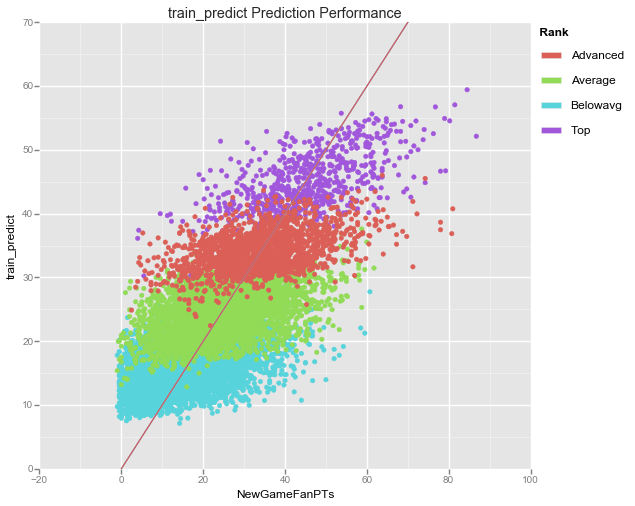

<ggplot: (285869465)>

In [23]:
plot_predictions('train_predict',train)

In [105]:
def get_performance(xgbmodel,train_data,test_data,predictors):
    train_predictions = xgbmodel.predict(train_data[predictors])
    print "\nModel Report"
    print "RMSE(Train) : %.4g" % metrics.mean_squared_error(train_data['NewGameFanPTs'], train_predictions)**0.5
    print "R^2 Score (Train): %f" % metrics.r2_score(train_data['NewGameFanPTs'], train_predictions)
    test_result = xgbmodel.predict(test_data[predictors])
    print "RMSE(Test) : %.4g" % metrics.mean_squared_error(test_data['NewGameFanPTs'], test_result)**0.5
    print 'R^2 Score (Test): %f' % metrics.r2_score(test_data['NewGameFanPTs'], test_result)

In [92]:
get_performance(model1,Train,Test,predictors)


Model Report
RMSE(Train) : 9.157
R^2 Score (Train): 0.532455
RMSE(Test) : 9.789
R^2 Score (Test): 0.536636


We had greatly reduced the overfitting but there's still some overfitting.

In [26]:
test['test_predict'] = test_result

In [27]:
with open('../Data/test_set_02_29.pickle', 'rb') as handle:
  test_set = pickle.load(handle)

In [28]:
test['Rank'] = test_set['Rank'].values

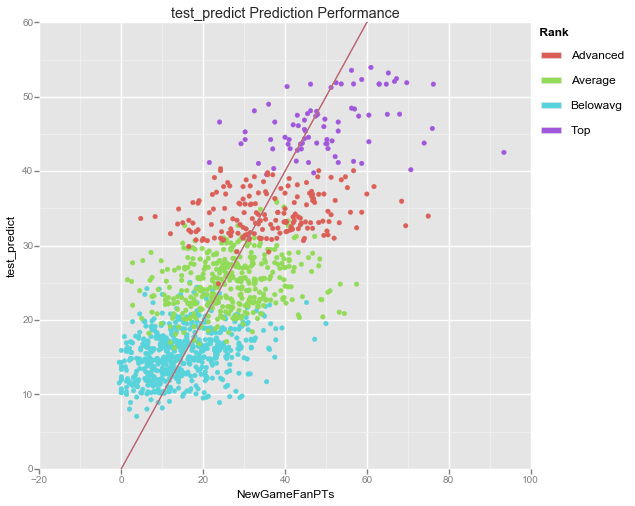

<ggplot: (287796689)>

In [29]:
plot_predictions('test_predict',test)

##Plot Feature Importance

In [50]:
def plot_importance(xgbmodel):
    feat_imp = pd.Series(xgbmodel.booster().get_fscore())
    feat_imp.sort(ascending=False)
    plt.figure(figsize=(10, 8))
    feat_imp[:30].plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

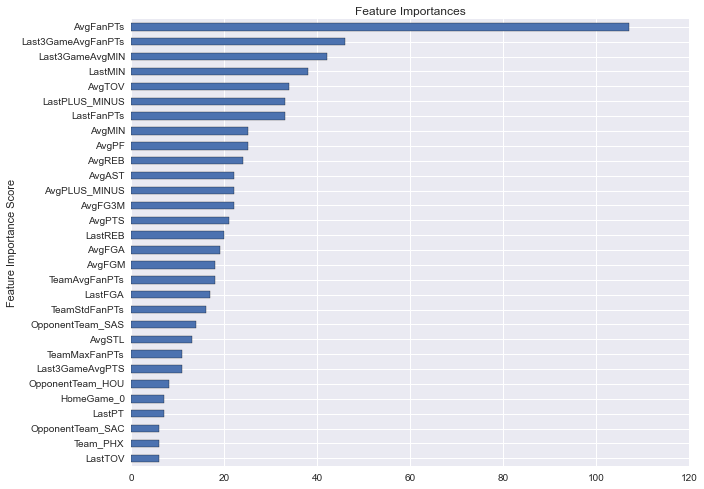

In [52]:
plot_importance(model1)

##Hyperparameters tuning

First, tune max_depth and min_child_weight

In [57]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [67]:
train,valid,y_train,y_valid = cross_validation.train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [143]:
def objective(space):
    clf = xgb.XGBRegressor(n_estimators = 54,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }

In [144]:
space ={
        'max_depth': hp.quniform("x_max_depth", 3, 10, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1)
    }

In [145]:
trials = Trials()

In [146]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108751	validation_1-rmse:21.904499
[2]	validation_0-rmse:20.330938	validation_1-rmse:20.165867
[3]	validation_0-rmse:18.763113	validation_1-rmse:18.644665
[4]	validation_0-rmse:17.385504	validation_1-rmse:17.309132
[5]	validation_0-rmse:16.180544	validation_1-rmse:16.146364
[6]	validation_0-rmse:15.128831	validation_1-rmse:15.143385
[7]	validation_0-rmse:14.219110	validation_1-rmse:14.280494
[8]	validation_0-rmse:13.437551	validation_1-rmse:13.539398
[9]	validation_0-rmse:12.759530	validation_1-rmse:12.914319
[10]	validation_0-rmse:12.179878	validation_1-rmse:12.373984
[11]	validation_0-rmse:11.682115	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.264492	validation_1-rmse:11.540384
[13]	validation_0-rmse:10.906609	validation_1-rmse:11.220879
[14]	validation_0-rmse:10.607087	validation_1-rmse:10.954255
[15]	validation_0-rmse:10.35

RMSE: 9.76218286957
RMSE:

[52]	validation_0-rmse:6.643716	validation_1-rmse:9.909328
[53]	validation_0-rmse:6.627889	validation_1-rmse:9.906797
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.89858706089
RMSE:

[53]	validation_0-rmse:9.322277	validation_1-rmse:9.769126
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143124
[7]	validation_0-rmse:14.290164	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515434	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	validation_1-rmse:11.551476
[13]	validation_0-rmse:11.050628	validation_1-rmse:11.236567
[14]	validation_0-rmse:10.7593

 9.7681076122
RMSE:

[52]	validation_0-rmse:9.070930	validation_1-rmse:9.759960
[53]	validation_0-rmse:9.062257	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74794318121
RMSE:

[53]	validation_0-rmse:9.322277	validation_1-rmse:9.769126
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130415	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.7681076122
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163578
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138482
[7]	validation_0-rmse:14.218494	validation_1-rmse:14.276127
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914835
[10]	validation_0-rmse:12.174829	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	validation_1-rmse:11.918400
[12]	validation_0-rmse:11.252916	validation_1-rmse:11.537907
[13]	validation_0-rmse:10.895549

 9.74369225425
RMSE:

[51]	validation_0-rmse:8.704488	validation_1-rmse:9.746226
[52]	validation_0-rmse:8.697091	validation_1-rmse:9.745442
[53]	validation_0-rmse:8.687620	validation_1-rmse:9.750560
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176622	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280216
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	v

 9.73933245035
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.090136	validation_1-rmse:23.898439
[1]	validation_0-rmse:22.044081	validation_1-rmse:21.941349
[2]	validation_0-rmse:20.213614	validation_1-rmse:20.232752
[3]	validation_0-rmse:18.586456	validation_1-rmse:18.719015
[4]	validation_0-rmse:17.133118	validation_1-rmse:17.406437
[5]	validation_0-rmse:15.845625	validation_1-rmse:16.261272
[6]	validation_0-rmse:14.704982	validation_1-rmse:15.267272
[7]	validation_0-rmse:13.695626	validation_1-rmse:14.413706
[8]	validation_0-rmse:12.786186	validation_1-rmse:13.671574
[9]	validation_0-rmse:11.976619	validation_1-rmse:13.061740
[10]	validation_0-rmse:11.263189	validation_1-rmse:12.531442
[11]	validation_0-rmse:10.654499	validation_1-rmse:12.101441
[12]	validation_0-rmse:10.095265	validation_1-rmse:11.716945
[13]	validation_0-rmse:9.615782	validation_1-rmse:11.391922
[14]	validation_0-rmse:9.183100	validation_1-rmse:11.142270
[15]	validation_0-rmse:8.78780

 9.73400319517
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153542
[6]	validation_0-rmse:15.064157	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923405
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040	validation_1-rmse:11.244287
[14]	validation_0-rmse:10.386967	validation_1-rmse:10.976141
[15]	validation_0-rmse:10.11

 9.95385650204
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350679	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227867	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140632
[7]	validation_0-rmse:14.290694	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396703	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.758250	validation_1-rmse:10.964948
[15]	validation_0-rmse:10.51

 9.79008141593
RMSE:

[52]	validation_0-rmse:9.062033	validation_1-rmse:9.754549
[53]	validation_0-rmse:9.055693	validation_1-rmse:9.758328
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868517
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064156	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923405
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040

 9.74367541987
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108751	validation_1-rmse:21.904499
[2]	validation_0-rmse:20.330938	validation_1-rmse:20.165867
[3]	validation_0-rmse:18.763113	validation_1-rmse:18.644665
[4]	validation_0-rmse:17.385504	validation_1-rmse:17.309132
[5]	validation_0-rmse:16.180544	validation_1-rmse:16.146364
[6]	validation_0-rmse:15.128831	validation_1-rmse:15.143385
[7]	validation_0-rmse:14.219110	validation_1-rmse:14.280494
[8]	validation_0-rmse:13.437551	validation_1-rmse:13.539398
[9]	validation_0-rmse:12.759530	validation_1-rmse:12.914319
[10]	validation_0-rmse:12.179878	validation_1-rmse:12.373985
[11]	validation_0-rmse:11.682115	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.264492	validation_1-rmse:11.540384
[13]	validation_0-rmse:10.906609	validation_1-rmse:11.220879
[14]	validation_0-rmse:10.607087	validation_1-rmse:10.954255
[15]	validation_0-rmse:10.35

 9.79008141593
RMSE:

[51]	validation_0-rmse:8.671532	validation_1-rmse:9.775334
[52]	validation_0-rmse:8.665312	validation_1-rmse:9.783757
[53]	validation_0-rmse:8.658895	validation_1-rmse:9.782504
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143125
[7]	validation_0-rmse:14.290164	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515435	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	v

 9.76218286957
RMSE:

[53]	validation_0-rmse:9.062258	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125500	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228243	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851655	validation_1-rmse:12.899383
[10]	validation_0-rmse:12.286905	validation_1-rmse:12.369546
[11]	validation_0-rmse:11.804119	validation_1-rmse:11.917234
[12]	validation_0-rmse:11.396894	validation_1-rmse:11.545915
[13]	validation_0-rmse:11.050538	validation_1-rmse:11.230865
[14]	validation_0-rmse:10.7592

 9.74794318121
RMSE:

[50]	validation_0-rmse:9.079077	validation_1-rmse:9.750792
[51]	validation_0-rmse:9.067880	validation_1-rmse:9.752131
[52]	validation_0-rmse:9.064534	validation_1-rmse:9.751561
[53]	validation_0-rmse:9.057833	validation_1-rmse:9.745494
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.102386	validation_1-rmse:23.874811
[1]	validation_0-rmse:22.073999	validation_1-rmse:21.916313
[2]	validation_0-rmse:20.270346	validation_1-rmse:20.183939
[3]	validation_0-rmse:18.672546	validation_1-rmse:18.666513
[4]	validation_0-rmse:17.262098	validation_1-rmse:17.333586
[5]	validation_0-rmse:16.015272	validation_1-rmse:16.174528
[6]	validation_0-rmse:14.913672	validation_1-rmse:15.188372
[7]	validation_0-rmse:13.945785	validation_1-rmse:14.327907
[8]	validation_0-rmse:13.097056	validation_1-rmse:13.582752
[9]	validation_0-rmse:12.348711	validation_1-rmse:12.965114
[10]	validation_0-rmse:11.693074	validation_1-rmse:12.440165
[11]	validation_0-rmse:11.126057	val

 9.73161770846
RMSE:

[53]	validation_0-rmse:6.974106	validation_1-rmse:9.881714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101097	validation_1-rmse:23.880947
[1]	validation_0-rmse:22.070105	validation_1-rmse:21.925936
[2]	validation_0-rmse:20.263256	validation_1-rmse:20.195496
[3]	validation_0-rmse:18.658989	validation_1-rmse:18.686071
[4]	validation_0-rmse:17.240969	validation_1-rmse:17.364414
[5]	validation_0-rmse:15.991707	validation_1-rmse:16.216274
[6]	validation_0-rmse:14.877168	validation_1-rmse:15.215716
[7]	validation_0-rmse:13.909206	validation_1-rmse:14.345072
[8]	validation_0-rmse:13.061710	validation_1-rmse:13.608484
[9]	validation_0-rmse:12.312884	validation_1-rmse:12.992924
[10]	validation_0-rmse:11.656476	validation_1-rmse:12.464072
[11]	validation_0-rmse:11.083660	validation_1-rmse:12.016108
[12]	validation_0-rmse:10.591274	validation_1-rmse:11.636943
[13]	validation_0-rmse:10.156296	validation_1-rmse:11.327071
[14]	validation_0-rmse:9.78198

 9.85888292379
RMSE:

[52]	validation_0-rmse:6.728412	validation_1-rmse:9.966475
[53]	validation_0-rmse:6.707061	validation_1-rmse:9.965500
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282466
[8]	validation_0-rmse:13.517036	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852231	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831

 9.94234177533
RMSE:

[53]	validation_0-rmse:9.066878	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108883	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912031
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651987
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217408	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340	validation_1-rmse:11.277323
[14]	validation_0-rmse:10.1522

 9.73804059784
RMSE:

[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108883	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912031
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651989
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217409	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340

 9.85063765067
RMSE:

[51]	validation_0-rmse:7.659543	validation_1-rmse:9.871388
[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114246	validation_1-rmse:23.871210
[1]	validation_0-rmse:22.097651	validation_1-rmse:21.910076
[2]	validation_0-rmse:20.310755	validation_1-rmse:20.170429
[3]	validation_0-rmse:18.730776	validation_1-rmse:18.647655
[4]	validation_0-rmse:17.341291	validation_1-rmse:17.313478
[5]	validation_0-rmse:16.121786	validation_1-rmse:16.156647
[6]	validation_0-rmse:15.056556	validation_1-rmse:15.156137
[7]	validation_0-rmse:14.128031	validation_1-rmse:14.292001
[8]	validation_0-rmse:13.322772	validation_1-rmse:13.551939
[9]	validation_0-rmse:12.626955	validation_1-rmse:12.921128
[10]	validation_0-rmse:12.023179	validation_1-rmse:12.384395
[11]	validation_0-rmse:11.508811	validation_1-rmse:11.938708
[12]	validation_0-rmse:11.065792	v

 9.85063765067
RMSE:

[52]	validation_0-rmse:8.121552	validation_1-rmse:9.783685
[53]	validation_0-rmse:8.102359	validation_1-rmse:9.787512
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.77837201453
RMSE:

[50]	validation_0-rmse:9.330546	validation_1-rmse:9.766217
[51]	validation_0-rmse:9.327536	validation_1-rmse:9.765511
[52]	validation_0-rmse:9.323603	validation_1-rmse:9.766790
[53]	validation_0-rmse:9.319542	validation_1-rmse:9.765909
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125156	validation_1-rmse:23.868093
[1]	validation_0-rmse:22.121227	validation_1-rmse:21.900354
[2]	validation_0-rmse:20.349997	validation_1-rmse:20.159048
[3]	validation_0-rmse:18.790304	validation_1-rmse:18.638243
[4]	validation_0-rmse:17.423092	validation_1-rmse:17.305687
[5]	validation_0-rmse:16.228697	validation_1-rmse:16.143099
[6]	validation_0-rmse:15.190405	validation_1-rmse:15.139666
[7]	validation_0-rmse:14.290030	validation_1-rmse:14.275728
[8]	validation_0-rmse:13.516379	validation_1-rmse:13.545489
[9]	validation_0-rmse:12.851646	validation_1-rmse:12.913272
[10]	validation_0-rmse:12.286069	validation_1-rmse:12.382055
[11]	validation_0-rmse:11.804087	val

 9.76446130605
RMSE:

[53]	validation_0-rmse:9.048592	validation_1-rmse:9.763805
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119829	validation_1-rmse:23.873726
[1]	validation_0-rmse:22.109529	validation_1-rmse:21.903923
[2]	validation_0-rmse:20.332310	validation_1-rmse:20.161713
[3]	validation_0-rmse:18.764997	validation_1-rmse:18.640116
[4]	validation_0-rmse:17.388548	validation_1-rmse:17.301804
[5]	validation_0-rmse:16.183619	validation_1-rmse:16.139210
[6]	validation_0-rmse:15.130906	validation_1-rmse:15.139318
[7]	validation_0-rmse:14.223783	validation_1-rmse:14.279951
[8]	validation_0-rmse:13.440709	validation_1-rmse:13.532317
[9]	validation_0-rmse:12.761030	validation_1-rmse:12.906916
[10]	validation_0-rmse:12.177477	validation_1-rmse:12.367263
[11]	validation_0-rmse:11.680354	validation_1-rmse:11.911634
[12]	validation_0-rmse:11.261236	validation_1-rmse:11.536205
[13]	validation_0-rmse:10.905053	validation_1-rmse:11.217029
[14]	validation_0-rmse:10.6041

 9.74617363243
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.087967	validation_1-rmse:23.896963
[1]	validation_0-rmse:22.038099	validation_1-rmse:21.950779
[2]	validation_0-rmse:20.208008	validation_1-rmse:20.237278
[3]	validation_0-rmse:18.577332	validation_1-rmse:18.743176
[4]	validation_0-rmse:17.124771	validation_1-rmse:17.418766
[5]	validation_0-rmse:15.830010	validation_1-rmse:16.282179
[6]	validation_0-rmse:14.676838	validation_1-rmse:15.296359
[7]	validation_0-rmse:13.655007	validation_1-rmse:14.452283
[8]	validation_0-rmse:12.750190	validation_1-rmse:13.727709
[9]	validation_0-rmse:11.932377	validation_1-rmse:13.100330
[10]	validation_0-rmse:11.204546	validation_1-rmse:12.563751
[11]	validation_0-rmse:10.564704	validation_1-rmse:12.118175
[12]	validation_0-rmse:9.998478	validation_1-rmse:11.749059
[13]	validation_0-rmse:9.488838	validation_1-rmse:11.452092
[14]	validation_0-rmse:9.057522	validation_1-rmse:11.208710
[15]	validation_0-rmse:8.660533

 9.75022055436
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 10.0346199439
RMSE:

[51]	validation_0-rmse:9.325641	validation_1-rmse:9.772595
[52]	validation_0-rmse:9.317353	validation_1-rmse:9.768789
[53]	validation_0-rmse:9.314795	validation_1-rmse:9.766800
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.113857	validation_1-rmse:23.872263
[1]	validation_0-rmse:22.096809	validation_1-rmse:21.907171
[2]	validation_0-rmse:20.309233	validation_1-rmse:20.166334
[3]	validation_0-rmse:18.729822	validation_1-rmse:18.641249
[4]	validation_0-rmse:17.341362	validation_1-rmse:17.306488
[5]	validation_0-rmse:16.121990	validation_1-rmse:16.149832
[6]	validation_0-rmse:15.055247	validation_1-rmse:15.148977
[7]	validation_0-rmse:14.126789	validation_1-rmse:14.287689
[8]	validation_0-rmse:13.323073	validation_1-rmse:13.549180
[9]	validation_0-rmse:12.623780	validation_1-rmse:12.925584
[10]	validation_0-rmse:12.019390	validation_1-rmse:12.388813
[11]	validation_0-rmse:11.504107	validation_1-rmse:11.930157
[12]	validation_0-rmse:11.063813	v

 9.76663150095
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.109283	validation_1-rmse:23.875538
[1]	validation_0-rmse:22.087147	validation_1-rmse:21.910461
[2]	validation_0-rmse:20.294876	validation_1-rmse:20.174683
[3]	validation_0-rmse:18.708946	validation_1-rmse:18.653904
[4]	validation_0-rmse:17.307568	validation_1-rmse:17.320410
[5]	validation_0-rmse:16.073059	validation_1-rmse:16.175053
[6]	validation_0-rmse:14.992219	validation_1-rmse:15.167633
[7]	validation_0-rmse:14.048729	validation_1-rmse:14.303183
[8]	validation_0-rmse:13.219271	validation_1-rmse:13.575853
[9]	validation_0-rmse:12.500971	validation_1-rmse:12.951536
[10]	validation_0-rmse:11.888075	validation_1-rmse:12.415146
[11]	validation_0-rmse:11.358550	validation_1-rmse:11.976431
[12]	validation_0-rmse:10.899543	validation_1-rmse:11.603548
[13]	validation_0-rmse:10.504320	validation_1-rmse:11.289664
[14]	validation_0-rmse:10.159955	validation_1-rmse:11.032264
[15]	validation_0-rmse:9.860

 9.79247644046
RMSE:

[52]	validation_0-rmse:7.650815	validation_1-rmse:9.863156
[53]	validation_0-rmse:7.640891	validation_1-rmse:9.862238
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147164
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530

 9.84786765434
RMSE:

[51]	validation_0-rmse:8.665455	validation_1-rmse:9.765227
[52]	validation_0-rmse:8.655813	validation_1-rmse:9.762918
[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870995
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899368
[10]	validation_0-rmse:12.285314	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925163
[12]	validation_0-rmse:11.393589	v

 9.75188769907
RMSE:

[52]	validation_0-rmse:9.056343	validation_1-rmse:9.760841
[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758019
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.094837	validation_1-rmse:23.890549
[1]	validation_0-rmse:22.055319	validation_1-rmse:21.935938
[2]	validation_0-rmse:20.239483	validation_1-rmse:20.196146
[3]	validation_0-rmse:18.618792	validation_1-rmse:18.682037
[4]	validation_0-rmse:17.182804	validation_1-rmse:17.368244
[5]	validation_0-rmse:15.913301	validation_1-rmse:16.216597
[6]	validation_0-rmse:14.784159	validation_1-rmse:15.229875
[7]	validation_0-rmse:13.791485	validation_1-rmse:14.373952
[8]	validation_0-rmse:12.907171	validation_1-rmse:13.634924
[9]	validation_0-rmse:12.124948	validation_1-rmse:13.006335
[10]	validation_0-rmse:11.436294	validation_1-rmse:12.481003
[11]	validation_0-rmse:10.826564	validation_1-rmse:12.030574
[12]	validation_0-rmse:10.296558	validation_1-rmse:11.661356
[13]	validation_0-rmse:9.826165	

 9.74949531663
RMSE:

[53]	validation_0-rmse:5.905210	validation_1-rmse:9.982907
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.8675

 9.96886414623
RMSE:

[51]	validation_0-rmse:9.325641	validation_1-rmse:9.772594
[52]	validation_0-rmse:9.317353	validation_1-rmse:9.768789
[53]	validation_0-rmse:9.314795	validation_1-rmse:9.766800
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176622	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280215
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	v

 9.76663150095
RMSE:

[53]	validation_0-rmse:8.627577	validation_1-rmse:9.736968
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350700	validation_1-rmse:20.166082
[3]	validation_0-rmse:18.792671	validation_1-rmse:18.644098
[4]	validation_0-rmse:17.423922	validation_1-rmse:17.311901
[5]	validation_0-rmse:16.227905	validation_1-rmse:16.149160
[6]	validation_0-rmse:15.189571	validation_1-rmse:15.144203
[7]	validation_0-rmse:14.290784	validation_1-rmse:14.279242
[8]	validation_0-rmse:13.516116	validation_1-rmse:13.538309
[9]	validation_0-rmse:12.851455	validation_1-rmse:12.896580
[10]	validation_0-rmse:12.286273	validation_1-rmse:12.366405
[11]	validation_0-rmse:11.805215	validation_1-rmse:11.922660
[12]	validation_0-rmse:11.395301	validation_1-rmse:11.541790
[13]	validation_0-rmse:11.049396	validation_1-rmse:11.227733
[14]	validation_0-rmse:10.7577

 9.73400319517
RMSE:

[51]	validation_0-rmse:9.068666	validation_1-rmse:9.753603
[52]	validation_0-rmse:9.061409	validation_1-rmse:9.752932
[53]	validation_0-rmse:9.053139	validation_1-rmse:9.753023
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	v

 9.74115194877
RMSE:

[52]	validation_0-rmse:9.324184	validation_1-rmse:9.774826
[53]	validation_0-rmse:9.320870	validation_1-rmse:9.774102
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097746	validation_1-rmse:21.906008
[2]	validation_0-rmse:20.311754	validation_1-rmse:20.167156
[3]	validation_0-rmse:18.733755	validation_1-rmse:18.636290
[4]	validation_0-rmse:17.346663	validation_1-rmse:17.311470
[5]	validation_0-rmse:16.126913	validation_1-rmse:16.154016
[6]	validation_0-rmse:15.062671	validation_1-rmse:15.157742
[7]	validation_0-rmse:14.135468	validation_1-rmse:14.298212
[8]	validation_0-rmse:13.331877	validation_1-rmse:13.557668
[9]	validation_0-rmse:12.638297	validation_1-rmse:12.935003
[10]	validation_0-rmse:12.035796	validation_1-rmse:12.397744
[11]	validation_0-rmse:11.523155	validation_1-rmse:11.942334
[12]	validation_0-rmse:11.078750	validation_1-rmse:11.557848
[13]	validation_0-rmse:10.701609

 9.77183817303
RMSE:

[52]	validation_0-rmse:8.123719	validation_1-rmse:9.777025
[53]	validation_0-rmse:8.117562	validation_1-rmse:9.778175
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812

 9.7661328604
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.335167	validation_1-rmse:9.777050
[51]	validation_0-rmse:9.331389	validation_1-rmse:9.778243
[52]	validation_0-rmse:9.328485	validation_1-rmse:9.777288
[53]	validation_0-rmse:9.323493	validation_1-rmse:9.777643
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163580
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138483
[7]	validation_0-rmse:14.218494	validation_1-rmse:14.276128
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914834
[10]	validation_0-rmse:12.174828	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	val

 9.77739733995
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.095596	validation_1-rmse:23.887850
[1]	validation_0-rmse:22.057529	validation_1-rmse:21.927790
[2]	validation_0-rmse:20.242239	validation_1-rmse:20.202366
[3]	validation_0-rmse:18.631035	validation_1-rmse:18.695095
[4]	validation_0-rmse:17.194372	validation_1-rmse:17.377607
[5]	validation_0-rmse:15.927068	validation_1-rmse:16.241430
[6]	validation_0-rmse:14.801593	validation_1-rmse:15.249487
[7]	validation_0-rmse:13.815429	validation_1-rmse:14.388331
[8]	validation_0-rmse:12.940395	validation_1-rmse:13.652433
[9]	validation_0-rmse:12.169173	validation_1-rmse:13.030581
[10]	validation_0-rmse:11.488798	validation_1-rmse:12.499797
[11]	validation_0-rmse:10.887458	validation_1-rmse:12.059912
[12]	validation_0-rmse:10.363106	validation_1-rmse:11.670189
[13]	validation_0-rmse:9.906373	validation_1-rmse:11.371608
[14]	validation_0-rmse:9.503635	validation_1-rmse:11.114083
[15]	validation_0-rmse:9.15772

 9.73933245035
RMSE:

[52]	validation_0-rmse:6.208552	validation_1-rmse:10.030241
[53]	validation_0-rmse:6.159427	validation_1-rmse:10.038890
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870993
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899367
[10]	validation_0-rmse:12.285315	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393589	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.0475

 10.020470808
RMSE:

[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758019
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166327
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645824
[4]	validation_0-rmse:17.383091	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177094	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541143
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373089
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.74949531663
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.107718	validation_1-rmse:23.874851
[1]	validation_0-rmse:22.083378	validation_1-rmse:21.908531
[2]	validation_0-rmse:20.287624	validation_1-rmse:20.171640
[3]	validation_0-rmse:18.699177	validation_1-rmse:18.650059
[4]	validation_0-rmse:17.294569	validation_1-rmse:17.318911
[5]	validation_0-rmse:16.058926	validation_1-rmse:16.161997
[6]	validation_0-rmse:14.973225	validation_1-rmse:15.158975
[7]	validation_0-rmse:14.021212	validation_1-rmse:14.307266
[8]	validation_0-rmse:13.194164	validation_1-rmse:13.569924
[9]	validation_0-rmse:12.472175	validation_1-rmse:12.932990
[10]	validation_0-rmse:11.849347	validation_1-rmse:12.402218
[11]	validation_0-rmse:11.312370	validation_1-rmse:11.955161
[12]	validation_0-rmse:10.850128	validation_1-rmse:11.583996
[13]	validation_0-rmse:10.446091	validation_1-rmse:11.265486
[14]	validation_0-rmse:10.086567	validation_1-rmse:11.004178
[15]	validation_0-rmse:9.790

 9.75188769907
RMSE:

[52]	validation_0-rmse:7.499014	validation_1-rmse:9.841902
[53]	validation_0-rmse:7.489391	validation_1-rmse:9.840468
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115158	validation_1-rmse:23.868734
[1]	validation_0-rmse:22.099049	validation_1-rmse:21.906725
[2]	validation_0-rmse:20.314474	validation_1-rmse:20.166620
[3]	validation_0-rmse:18.738155	validation_1-rmse:18.639286
[4]	validation_0-rmse:17.350060	validation_1-rmse:17.309387
[5]	validation_0-rmse:16.134439	validation_1-rmse:16.145292
[6]	validation_0-rmse:15.070882	validation_1-rmse:15.141561
[7]	validation_0-rmse:14.141226	validation_1-rmse:14.289040
[8]	validation_0-rmse:13.341045	validation_1-rmse:13.563207
[9]	validation_0-rmse:12.646539	validation_1-rmse:12.927448
[10]	validation_0-rmse:12.046831	validation_1-rmse:12.387367
[11]	validation_0-rmse:11.539705	validation_1-rmse:11.934971
[12]	validation_0-rmse:11.100721	validation_1-rmse:11.554044
[13]	validation_0-rmse:10.723804

 9.82675747553
RMSE:

[53]	validation_0-rmse:8.233302	validation_1-rmse:9.809882
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143124
[7]	validation_0-rmse:14.290165	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515434	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	validation_1-rmse:11.551477
[13]	validation_0-rmse:11.050628	validation_1-rmse:11.236567
[14]	validation_0-rmse:10.7593

 9.79350553913
RMSE:

[53]	validation_0-rmse:9.062258	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097746	validation_1-rmse:21.906008
[2]	validation_0-rmse:20.311754	validation_1-rmse:20.167156
[3]	validation_0-rmse:18.733755	validation_1-rmse:18.636290
[4]	validation_0-rmse:17.346663	validation_1-rmse:17.311470
[5]	validation_0-rmse:16.126913	validation_1-rmse:16.154016
[6]	validation_0-rmse:15.062671	validation_1-rmse:15.157742
[7]	validation_0-rmse:14.135468	validation_1-rmse:14.298212
[8]	validation_0-rmse:13.331877	validation_1-rmse:13.557669
[9]	validation_0-rmse:12.638297	validation_1-rmse:12.935003
[10]	validation_0-rmse:12.035796	validation_1-rmse:12.397744
[11]	validation_0-rmse:11.523155	validation_1-rmse:11.942334
[12]	validation_0-rmse:11.078750	validation_1-rmse:11.557848
[13]	validation_0-rmse:10.701609	validation_1-rmse:11.240788
[14]	validation_0-rmse:10.3772

 9.74794318121
RMSE:

[52]	validation_0-rmse:8.123719	validation_1-rmse:9.777025
[53]	validation_0-rmse:8.117562	validation_1-rmse:9.778174
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.7661328604
RMSE:

[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324096	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322169	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101627	validation_1-rmse:23.881172
[1]	validation_0-rmse:22.072702	validation_1-rmse:21.924627
[2]	validation_0-rmse:20.267990	validation_1-rmse:20.196732
[3]	validation_0-rmse:18.665400	validation_1-rmse:18.672689
[4]	validation_0-rmse:17.252281	validation_1-rmse:17.341370
[5]	validation_0-rmse:16.003510	validation_1-rmse:16.192663
[6]	validation_0-rmse:14.897799	validation_1-rmse:15.196776
[7]	validation_0-rmse:13.933459	validation_1-rmse:14.339684
[8]	validation_0-rmse:13.083369	validation_1-rmse:13.608436
[9]	validation_0-rmse:12.345995	validation_1-rmse:12.980793
[10]	validation_0-rmse:11.694060	validation_1-rmse:12.459973
[11]	validation_0-rmse:11.123218	validation_1-rmse:12.020255
[12]	validation_0-rmse:10.622528	v

 9.76854295839
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119751	validation_1-rmse:23.871378
[1]	validation_0-rmse:22.109310	validation_1-rmse:21.902161
[2]	validation_0-rmse:20.331648	validation_1-rmse:20.162054
[3]	validation_0-rmse:18.764130	validation_1-rmse:18.640839
[4]	validation_0-rmse:17.387440	validation_1-rmse:17.301134
[5]	validation_0-rmse:16.182631	validation_1-rmse:16.137861
[6]	validation_0-rmse:15.131346	validation_1-rmse:15.134843
[7]	validation_0-rmse:14.221881	validation_1-rmse:14.271791
[8]	validation_0-rmse:13.441121	validation_1-rmse:13.530232
[9]	validation_0-rmse:12.763927	validation_1-rmse:12.899610
[10]	validation_0-rmse:12.180677	validation_1-rmse:12.364655
[11]	validation_0-rmse:11.684121	validation_1-rmse:11.911885
[12]	validation_0-rmse:11.259100	validation_1-rmse:11.532269
[13]	validation_0-rmse:10.902230	validation_1-rmse:11.215220
[14]	validation_0-rmse:10.599273	validation_1-rmse:10.950581
[15]	validation_0-rmse:10.34

 9.95063661971
RMSE:

[52]	validation_0-rmse:8.682778	validation_1-rmse:9.730370
[53]	validation_0-rmse:8.673928	validation_1-rmse:9.730251
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121809	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792759	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901683
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099

 9.72011229099
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282466
[8]	validation_0-rmse:13.517035	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852232	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831	validation_1-rmse:11.233738
[14]	validation_0-rmse:10.757255	validation_1-rmse:10.966722
[15]	validation_0-rmse:10.51

 9.76500228725
RMSE:

[51]	validation_0-rmse:9.079919	validation_1-rmse:9.752168
[52]	validation_0-rmse:9.074804	validation_1-rmse:9.756012
[53]	validation_0-rmse:9.066878	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	v

 9.73804059784
RMSE:

[50]	validation_0-rmse:9.334394	validation_1-rmse:9.768347
[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324097	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322169	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130415	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681744	val

 9.76854295839
RMSE:

[51]	validation_0-rmse:8.698054	validation_1-rmse:9.760546
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115250	validation_1-rmse:23.870365
[1]	validation_0-rmse:22.099380	validation_1-rmse:21.905857
[2]	validation_0-rmse:20.315393	validation_1-rmse:20.164949
[3]	validation_0-rmse:18.738968	validation_1-rmse:18.640654
[4]	validation_0-rmse:17.352116	validation_1-rmse:17.311104
[5]	validation_0-rmse:16.136631	validation_1-rmse:16.145720
[6]	validation_0-rmse:15.072879	validation_1-rmse:15.149531
[7]	validation_0-rmse:14.143773	validation_1-rmse:14.294322
[8]	validation_0-rmse:13.343202	validation_1-rmse:13.563546
[9]	validation_0-rmse:12.650122	validation_1-rmse:12.938823
[10]	validation_0-rmse:12.051878	validation_1-rmse:12.400793
[11]	validation_0-rmse:11.540086	validation_1-rmse:11.954816
[12]	validation_0-rmse:11.100945	v

 9.74369225425
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108076	validation_1-rmse:23.876911
[1]	validation_0-rmse:22.084330	validation_1-rmse:21.914036
[2]	validation_0-rmse:20.290602	validation_1-rmse:20.179276
[3]	validation_0-rmse:18.704983	validation_1-rmse:18.655910
[4]	validation_0-rmse:17.303205	validation_1-rmse:17.324123
[5]	validation_0-rmse:16.064722	validation_1-rmse:16.168077
[6]	validation_0-rmse:14.983688	validation_1-rmse:15.175918
[7]	validation_0-rmse:14.036115	validation_1-rmse:14.317983
[8]	validation_0-rmse:13.213545	validation_1-rmse:13.573871
[9]	validation_0-rmse:12.491740	validation_1-rmse:12.947763
[10]	validation_0-rmse:11.867005	validation_1-rmse:12.411826
[11]	validation_0-rmse:11.337382	validation_1-rmse:11.969263
[12]	validation_0-rmse:10.869182	validation_1-rmse:11.585228
[13]	validation_0-rmse:10.479053	validation_1-rmse:11.274881
[14]	validation_0-rmse:10.133140	validation_1-rmse:11.010114
[15]	validation_0-rmse:9.846

 9.77734275509
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119806	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135832
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276781
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532809
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.605724	validation_1-rmse:10.957897
[15]	validation_0-rmse:10.35

 9.8210188908
RMSE:

[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.8675

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.339239	validation_1-rmse:9.770067
[51]	validation_0-rmse:9.334140	validation_1-rmse:9.766440
[52]	validation_0-rmse:9.327861	validation_1-rmse:9.766542
[53]	validation_0-rmse:9.321981	validation_1-rmse:9.766791
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	val

 9.76333881945
RMSE:

[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305473
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064156	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923406
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040	validation_1-rmse:11.244287
[14]	validation_0-rmse:10.3869

 9.76500228725
RMSE:

[53]	validation_0-rmse:8.196437	validation_1-rmse:9.811401
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108076	validation_1-rmse:23.876911
[1]	validation_0-rmse:22.084330	validation_1-rmse:21.914036
[2]	validation_0-rmse:20.290602	validation_1-rmse:20.179276
[3]	validation_0-rmse:18.704983	validation_1-rmse:18.655910
[4]	validation_0-rmse:17.303205	validation_1-rmse:17.324121
[5]	validation_0-rmse:16.064722	validation_1-rmse:16.168077
[6]	validation_0-rmse:14.983688	validation_1-rmse:15.175917
[7]	validation_0-rmse:14.036114	validation_1-rmse:14.317983
[8]	validation_0-rmse:13.213545	validation_1-rmse:13.573871
[9]	validation_0-rmse:12.491739	validation_1-rmse:12.947763
[10]	validation_0-rmse:11.867005	validation_1-rmse:12.411826
[11]	validation_0-rmse:11.337382	validation_1-rmse:11.969263
[12]	validation_0-rmse:10.869182	validation_1-rmse:11.585228
[13]	validation_0-rmse:10.479053	validation_1-rmse:11.274880
[14]	validation_0-rmse:10.1331

 9.79008141593
RMSE:

[52]	validation_0-rmse:7.577668	validation_1-rmse:9.846579
[53]	validation_0-rmse:7.564812	validation_1-rmse:9.845976
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.094858	validation_1-rmse:23.886711
[1]	validation_0-rmse:22.055262	validation_1-rmse:21.929590
[2]	validation_0-rmse:20.241049	validation_1-rmse:20.202131
[3]	validation_0-rmse:18.624226	validation_1-rmse:18.700527
[4]	validation_0-rmse:17.186440	validation_1-rmse:17.373159
[5]	validation_0-rmse:15.915125	validation_1-rmse:16.229378
[6]	validation_0-rmse:14.786343	validation_1-rmse:15.228575
[7]	validation_0-rmse:13.802736	validation_1-rmse:14.359781
[8]	validation_0-rmse:12.926657	validation_1-rmse:13.624920
[9]	validation_0-rmse:12.139565	validation_1-rmse:13.008020
[10]	validation_0-rmse:11.451518	validation_1-rmse:12.483023
[11]	validation_0-rmse:10.839067	validation_1-rmse:12.033561
[12]	validation_0-rmse:10.322261	validation_1-rmse:11.649576
[13]	validation_0-rmse:9.863789	

 9.8210188908
RMSE:

[52]	validation_0-rmse:6.132743	validation_1-rmse:9.975215
[53]	validation_0-rmse:6.117352	validation_1-rmse:9.972376
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.102386	validation_1-rmse:23.874811
[1]	validation_0-rmse:22.073999	validation_1-rmse:21.916313
[2]	validation_0-rmse:20.270346	validation_1-rmse:20.183939
[3]	validation_0-rmse:18.672546	validation_1-rmse:18.666513
[4]	validation_0-rmse:17.262098	validation_1-rmse:17.333586
[5]	validation_0-rmse:16.015272	validation_1-rmse:16.174528
[6]	validation_0-rmse:14.913672	validation_1-rmse:15.188372
[7]	validation_0-rmse:13.945785	validation_1-rmse:14.327907
[8]	validation_0-rmse:13.097056	validation_1-rmse:13.582752
[9]	validation_0-rmse:12.348710	validation_1-rmse:12.965114
[10]	validation_0-rmse:11.693074	validation_1-rmse:12.440165
[11]	validation_0-rmse:11.126057	validation_1-rmse:11.993870
[12]	validation_0-rmse:10.640993	validation_1-rmse:11.609939
[13]	validation_0-rmse:10.226395

 9.95440971938
RMSE:

[52]	validation_0-rmse:6.989148	validation_1-rmse:9.882909
[53]	validation_0-rmse:6.974106	validation_1-rmse:9.881714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121809	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228243	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287329	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099

 9.85888292379
RMSE:

[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530652
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178652	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.76500228725
RMSE:

[51]	validation_0-rmse:8.698053	validation_1-rmse:9.760546
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689741	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	v

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.334394	validation_1-rmse:9.768347
[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324097	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322168	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108709	validation_1-rmse:21.900078
[2]	validation_0-rmse:20.330643	validation_1-rmse:20.163132
[3]	validation_0-rmse:18.762285	validation_1-rmse:18.641161
[4]	validation_0-rmse:17.384165	validation_1-rmse:17.301037
[5]	validation_0-rmse:16.178385	validation_1-rmse:16.140812
[6]	validation_0-rmse:15.126686	validation_1-rmse:15.138326
[7]	validation_0-rmse:14.216981	validation_1-rmse:14.281374
[8]	validation_0-rmse:13.428439	validation_1-rmse:13.538822
[9]	validation_0-rmse:12.751819	validation_1-rmse:12.916469
[10]	validation_0-rmse:12.175229	validation_1-rmse:12.389917
[11]	validation_0-rmse:11.678472	val

 9.76854295839
RMSE:

[53]	validation_0-rmse:8.658951	validation_1-rmse:9.749969
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125704	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748430	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373089
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.7378229842
RMSE:

[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118883	validation_1-rmse:23.872766
[1]	validation_0-rmse:22.107664	validation_1-rmse:21.897884
[2]	validation_0-rmse:20.329414	validation_1-rmse:20.163563
[3]	validation_0-rmse:18.761871	validation_1-rmse:18.638470
[4]	validation_0-rmse:17.383341	validation_1-rmse:17.299757
[5]	validation_0-rmse:16.176590	validation_1-rmse:16.140339
[6]	validation_0-rmse:15.124516	validation_1-rmse:15.142480
[7]	validation_0-rmse:14.214164	validation_1-rmse:14.282411
[8]	validation_0-rmse:13.426016	validation_1-rmse:13.541087
[9]	validation_0-rmse:12.744389	validation_1-rmse:12.902369
[10]	validation_0-rmse:12.163025	validation_1-rmse:12.374441
[11]	validation_0-rmse:11.667450	validation_1-rmse:11.925297
[12]	validation_0-rmse:11.240463	validation_1-rmse:11.544260
[13]	validation_0-rmse:10.880295	validation_1-rmse:11.225542
[14]	validation_0-rmse:10.5785

 9.75188769907
RMSE:

[52]	validation_0-rmse:8.640171	validation_1-rmse:9.762031
[53]	validation_0-rmse:8.624881	validation_1-rmse:9.761436
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097975	validation_1-rmse:21.905947
[2]	validation_0-rmse:20.312920	validation_1-rmse:20.168171
[3]	validation_0-rmse:18.736301	validation_1-rmse:18.637247
[4]	validation_0-rmse:17.349380	validation_1-rmse:17.306141
[5]	validation_0-rmse:16.128122	validation_1-rmse:16.149075
[6]	validation_0-rmse:15.064150	validation_1-rmse:15.153623
[7]	validation_0-rmse:14.138247	validation_1-rmse:14.295528
[8]	validation_0-rmse:13.338133	validation_1-rmse:13.552767
[9]	validation_0-rmse:12.645053	validation_1-rmse:12.915622
[10]	validation_0-rmse:12.043626	validation_1-rmse:12.385106
[11]	validation_0-rmse:11.528996	validation_1-rmse:11.934857
[12]	validation_0-rmse:11.087811	validation_1-rmse:11.553062
[13]	validation_0-rmse:10.709161

 9.76085348005
RMSE:

[52]	validation_0-rmse:8.159282	validation_1-rmse:9.814359
[53]	validation_0-rmse:8.151196	validation_1-rmse:9.815246
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350700	validation_1-rmse:20.166082
[3]	validation_0-rmse:18.792671	validation_1-rmse:18.644098
[4]	validation_0-rmse:17.423944	validation_1-rmse:17.306942
[5]	validation_0-rmse:16.227959	validation_1-rmse:16.144316
[6]	validation_0-rmse:15.189623	validation_1-rmse:15.139480
[7]	validation_0-rmse:14.290290	validation_1-rmse:14.276546
[8]	validation_0-rmse:13.515338	validation_1-rmse:13.535547
[9]	validation_0-rmse:12.850622	validation_1-rmse:12.900493
[10]	validation_0-rmse:12.285645	validation_1-rmse:12.371776
[11]	validation_0-rmse:11.802147	validation_1-rmse:11.924234
[12]	validation_0-rmse:11.393323	validation_1-rmse:11.546952
[13]	validation_0-rmse:11.049051

 9.80022983414
RMSE:

[53]	validation_0-rmse:9.050888	validation_1-rmse:9.754887
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114077	validation_1-rmse:23.862095
[1]	validation_0-rmse:22.095541	validation_1-rmse:21.895798
[2]	validation_0-rmse:20.309149	validation_1-rmse:20.154129
[3]	validation_0-rmse:18.728537	validation_1-rmse:18.629217
[4]	validation_0-rmse:17.338757	validation_1-rmse:17.297756
[5]	validation_0-rmse:16.118223	validation_1-rmse:16.142570
[6]	validation_0-rmse:15.050549	validation_1-rmse:15.136881
[7]	validation_0-rmse:14.119853	validation_1-rmse:14.269995
[8]	validation_0-rmse:13.320621	validation_1-rmse:13.528469
[9]	validation_0-rmse:12.626575	validation_1-rmse:12.904289
[10]	validation_0-rmse:12.022202	validation_1-rmse:12.371134
[11]	validation_0-rmse:11.504106	validation_1-rmse:11.917998
[12]	validation_0-rmse:11.065584	validation_1-rmse:11.541173
[13]	validation_0-rmse:10.682165	validation_1-rmse:11.226892
[14]	validation_0-rmse:10.3608

 9.74366745023
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350681	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227867	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140632
[7]	validation_0-rmse:14.290694	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396703	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.758250	validation_1-rmse:10.964948
[15]	validation_0-rmse:10.51

 9.78506279543
RMSE:

[53]	validation_0-rmse:9.055693	validation_1-rmse:9.758327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135832
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276781
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178652	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532809
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.74367541987
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74369225425
RMSE:

[52]	validation_0-rmse:9.328485	validation_1-rmse:9.777288
[53]	validation_0-rmse:9.323493	validation_1-rmse:9.777643
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549857
[13]	validation_0-rmse:11.051099

 9.77739733995
RMSE:

[51]	validation_0-rmse:9.067062	validation_1-rmse:9.779227
[52]	validation_0-rmse:9.061259	validation_1-rmse:9.777136
[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064157	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923406
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	v

 9.76500228725
RMSE:

[53]	validation_0-rmse:8.196437	validation_1-rmse:9.811401
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898874
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383091	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125704	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.79008141593
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245143
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 9.75188769907
RMSE:

[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108885	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912029
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651987
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217408	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340	validation_1-rmse:11.277323
[14]	validation_0-rmse:10.1522

 9.76410867728
RMSE:

[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870995
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902582
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899368
[10]	validation_0-rmse:12.285314	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393588	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.047514

 9.85063765067
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114077	validation_1-rmse:23.862095
[1]	validation_0-rmse:22.095541	validation_1-rmse:21.895798
[2]	validation_0-rmse:20.309149	validation_1-rmse:20.154129
[3]	validation_0-rmse:18.728537	validation_1-rmse:18.629217
[4]	validation_0-rmse:17.338757	validation_1-rmse:17.297758
[5]	validation_0-rmse:16.118223	validation_1-rmse:16.142570
[6]	validation_0-rmse:15.050549	validation_1-rmse:15.136881
[7]	validation_0-rmse:14.119853	validation_1-rmse:14.269995
[8]	validation_0-rmse:13.320621	validation_1-rmse:13.528469
[9]	validation_0-rmse:12.626575	validation_1-rmse:12.904288
[10]	validation_0-rmse:12.022202	validation_1-rmse:12.371134
[11]	validation_0-rmse:11.504106	validation_1-rmse:11.917998
[12]	validation_0-rmse:11.065584	validation_1-rmse:11.541173
[13]	validation_0-rmse:10.682165	validation_1-rmse:11.226893
[14]	validation_0-rmse:10.360846	validation_1-rmse:10.957629
[15]	validation_0-rmse:10.08

 9.74949531663
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163578
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138482
[7]	validation_0-rmse:14.218495	validation_1-rmse:14.276127
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914835
[10]	validation_0-rmse:12.174829	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	validation_1-rmse:11.918400
[12]	validation_0-rmse:11.252915	validation_1-rmse:11.537907
[13]	validation_0-rmse:10.895549	validation_1-rmse:11.217936
[14]	validation_0-rmse:10.596009	validation_1-rmse:10.952752
[15]	validation_0-rmse:10.34

 9.78506279543
RMSE:

[53]	validation_0-rmse:8.687620	validation_1-rmse:9.750559
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350679	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227865	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140631
[7]	validation_0-rmse:14.290693	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396704	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.7582

 9.73933245035
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 9.74367541987
RMSE:

[51]	validation_0-rmse:9.334622	validation_1-rmse:9.765124
[52]	validation_0-rmse:9.327148	validation_1-rmse:9.766423
[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108515	validation_1-rmse:23.873440
[1]	validation_0-rmse:22.085373	validation_1-rmse:21.909132
[2]	validation_0-rmse:20.291775	validation_1-rmse:20.175695
[3]	validation_0-rmse:18.706804	validation_1-rmse:18.654360
[4]	validation_0-rmse:17.306486	validation_1-rmse:17.326706
[5]	validation_0-rmse:16.072666	validation_1-rmse:16.158825
[6]	validation_0-rmse:14.998070	validation_1-rmse:15.157062
[7]	validation_0-rmse:14.051213	validation_1-rmse:14.322594
[8]	validation_0-rmse:13.232892	validation_1-rmse:13.574508
[9]	validation_0-rmse:12.509481	validation_1-rmse:12.947534
[10]	validation_0-rmse:11.892959	validation_1-rmse:12.413888
[11]	validation_0-rmse:11.356966	validation_1-rmse:11.966023
[12]	validation_0-rmse:10.898502	v

 9.76410867728
RMSE:

[53]	validation_0-rmse:7.644738	validation_1-rmse:9.828958
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119827	validation_1-rmse:23.873726
[1]	validation_0-rmse:22.109529	validation_1-rmse:21.903923
[2]	validation_0-rmse:20.332310	validation_1-rmse:20.161713
[3]	validation_0-rmse:18.764997	validation_1-rmse:18.640118
[4]	validation_0-rmse:17.388548	validation_1-rmse:17.301804
[5]	validation_0-rmse:16.183619	validation_1-rmse:16.139210
[6]	validation_0-rmse:15.130904	validation_1-rmse:15.139318
[7]	validation_0-rmse:14.223783	validation_1-rmse:14.279950
[8]	validation_0-rmse:13.440709	validation_1-rmse:13.532317
[9]	validation_0-rmse:12.761031	validation_1-rmse:12.906916
[10]	validation_0-rmse:12.177477	validation_1-rmse:12.367263
[11]	validation_0-rmse:11.680354	validation_1-rmse:11.911634
[12]	validation_0-rmse:11.261236	validation_1-rmse:11.536205
[13]	validation_0-rmse:10.905053	validation_1-rmse:11.217029
[14]	validation_0-rmse:10.6041

 9.80677787753
RMSE:

[51]	validation_0-rmse:8.734604	validation_1-rmse:9.759444
[52]	validation_0-rmse:8.730343	validation_1-rmse:9.767077
[53]	validation_0-rmse:8.727160	validation_1-rmse:9.765601
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115156	validation_1-rmse:23.868734
[1]	validation_0-rmse:22.099049	validation_1-rmse:21.906725
[2]	validation_0-rmse:20.314472	validation_1-rmse:20.166620
[3]	validation_0-rmse:18.738155	validation_1-rmse:18.639286
[4]	validation_0-rmse:17.350060	validation_1-rmse:17.309387
[5]	validation_0-rmse:16.134439	validation_1-rmse:16.145292
[6]	validation_0-rmse:15.070882	validation_1-rmse:15.141561
[7]	validation_0-rmse:14.141227	validation_1-rmse:14.289040
[8]	validation_0-rmse:13.341045	validation_1-rmse:13.563207
[9]	validation_0-rmse:12.646539	validation_1-rmse:12.927448
[10]	validation_0-rmse:12.046831	validation_1-rmse:12.387368
[11]	validation_0-rmse:11.539705	validation_1-rmse:11.934971
[12]	validation_0-rmse:11.100721	v

 9.75022055436
RMSE:

[53]	validation_0-rmse:8.233302	validation_1-rmse:9.809882
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282465
[8]	validation_0-rmse:13.517036	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852231	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831	validation_1-rmse:11.233738
[14]	validation_0-rmse:10.7572

 9.79350553913
RMSE:

[53]	validation_0-rmse:9.066879	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176620	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280215
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	validation_1-rmse:11.539772
[13]	validation_0-rmse:10.892729	validation_1-rmse:11.222568
[14]	validation_0-rmse:10.5914

 9.73804059784
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099	validation_1-rmse:11.233347
[14]	validation_0-rmse:10.760569	validation_1-rmse:10.970658
[15]	validation_0-rmse:10.51

 9.73400319517
RMSE:

[51]	validation_0-rmse:9.067062	validation_1-rmse:9.779227
[52]	validation_0-rmse:9.061259	validation_1-rmse:9.777136
[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	v

 9.76500228725
RMSE:

[52]	validation_0-rmse:9.327861	validation_1-rmse:9.766542
[53]	validation_0-rmse:9.321981	validation_1-rmse:9.766791
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114649	validation_1-rmse:23.871624
[1]	validation_0-rmse:22.097996	validation_1-rmse:21.908783
[2]	validation_0-rmse:20.311457	validation_1-rmse:20.165962
[3]	validation_0-rmse:18.731230	validation_1-rmse:18.637316
[4]	validation_0-rmse:17.342636	validation_1-rmse:17.304951
[5]	validation_0-rmse:16.123671	validation_1-rmse:16.144737
[6]	validation_0-rmse:15.057155	validation_1-rmse:15.138239
[7]	validation_0-rmse:14.129929	validation_1-rmse:14.277055
[8]	validation_0-rmse:13.328552	validation_1-rmse:13.536840
[9]	validation_0-rmse:12.632622	validation_1-rmse:12.907085
[10]	validation_0-rmse:12.033107	validation_1-rmse:12.377611
[11]	validation_0-rmse:11.521687	validation_1-rmse:11.932660
[12]	validation_0-rmse:11.077237	validation_1-rmse:11.549107
[13]	validation_0-rmse:10.702423

 9.76333881945
RMSE:

[51]	validation_0-rmse:8.161463	validation_1-rmse:9.802203
[52]	validation_0-rmse:8.146386	validation_1-rmse:9.798594
[53]	validation_0-rmse:8.141918	validation_1-rmse:9.800634
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166327
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645824
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541143
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934947
[12]	validation_0-rmse:11.247320	v

 9.78197894266
RMSE:

[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108515	validation_1-rmse:23.873440
[1]	validation_0-rmse:22.085373	validation_1-rmse:21.909132
[2]	validation_0-rmse:20.291775	validation_1-rmse:20.175695
[3]	validation_0-rmse:18.706804	validation_1-rmse:18.654360
[4]	validation_0-rmse:17.306486	validation_1-rmse:17.326706
[5]	validation_0-rmse:16.072666	validation_1-rmse:16.158825
[6]	validation_0-rmse:14.998070	validation_1-rmse:15.157062
[7]	validation_0-rmse:14.051213	validation_1-rmse:14.322594
[8]	validation_0-rmse:13.232892	validation_1-rmse:13.574508
[9]	validation_0-rmse:12.509481	validation_1-rmse:12.947535
[10]	validation_0-rmse:11.892959	validation_1-rmse:12.413888
[11]	validation_0-rmse:11.356966	validation_1-rmse:11.966023
[12]	validation_0-rmse:10.898502	validation_1-rmse:11.587814
[13]	validation_0-rmse:10.494452	validation_1-rmse:11.266457
[14]	validation_0-rmse:10.1416

 9.75188769907
RMSE:

[53]	validation_0-rmse:7.644738	validation_1-rmse:9.828958
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101353	validation_1-rmse:23.879723
[1]	validation_0-rmse:22.071692	validation_1-rmse:21.924625
[2]	validation_0-rmse:20.266241	validation_1-rmse:20.189289
[3]	validation_0-rmse:18.665672	validation_1-rmse:18.668808
[4]	validation_0-rmse:17.250366	validation_1-rmse:17.331913
[5]	validation_0-rmse:15.998404	validation_1-rmse:16.182894
[6]	validation_0-rmse:14.889242	validation_1-rmse:15.189176
[7]	validation_0-rmse:13.923449	validation_1-rmse:14.335855
[8]	validation_0-rmse:13.069530	validation_1-rmse:13.599669
[9]	validation_0-rmse:12.318919	validation_1-rmse:12.977094
[10]	validation_0-rmse:11.667130	validation_1-rmse:12.445231
[11]	validation_0-rmse:11.104352	validation_1-rmse:11.996590
[12]	validation_0-rmse:10.611773	validation_1-rmse:11.624338
[13]	validation_0-rmse:10.185417	validation_1-rmse:11.318138
[14]	validation_0-rmse:9.82021

 9.80677787753
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.085802	validation_1-rmse:23.886879
[1]	validation_0-rmse:22.033358	validation_1-rmse:21.944372
[2]	validation_0-rmse:20.203941	validation_1-rmse:20.234087
[3]	validation_0-rmse:18.573984	validation_1-rmse:18.723074
[4]	validation_0-rmse:17.111151	validation_1-rmse:17.409723
[5]	validation_0-rmse:15.812243	validation_1-rmse:16.259211
[6]	validation_0-rmse:14.660277	validation_1-rmse:15.293710
[7]	validation_0-rmse:13.634568	validation_1-rmse:14.422128
[8]	validation_0-rmse:12.720007	validation_1-rmse:13.698142
[9]	validation_0-rmse:11.902884	validation_1-rmse:13.089090
[10]	validation_0-rmse:11.167542	validation_1-rmse:12.572839
[11]	validation_0-rmse:10.512725	validation_1-rmse:12.137167
[12]	validation_0-rmse:9.931074	validation_1-rmse:11.767857
[13]	validation_0-rmse:9.431188	validation_1-rmse:11.448429
[14]	validation_0-rmse:8.991429	validation_1-rmse:11.187758
[15]	validation_0-rmse:8.592946

 9.90504521797
RMSE:

[53]	validation_0-rmse:4.735243	validation_1-rmse:10.048619
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870993
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899367
[10]	validation_0-rmse:12.285315	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393588	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.047514	validation_1-rmse:11.228850
[14]	validation_0-rmse:10.757

 10.0432151851
RMSE:

[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758018
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245143
[14]	validation_0-rmse:10.8675

 9.74949531663
RMSE:

[49]	validation_0-rmse:9.346030	validation_1-rmse:9.770050
[50]	validation_0-rmse:9.339005	validation_1-rmse:9.768903
[51]	validation_0-rmse:9.334622	validation_1-rmse:9.765124
[52]	validation_0-rmse:9.327148	validation_1-rmse:9.766423
[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115250	validation_1-rmse:23.870365
[1]	validation_0-rmse:22.099380	validation_1-rmse:21.905857
[2]	validation_0-rmse:20.315393	validation_1-rmse:20.164949
[3]	validation_0-rmse:18.738968	validation_1-rmse:18.640654
[4]	validation_0-rmse:17.352116	validation_1-rmse:17.311104
[5]	validation_0-rmse:16.136631	validation_1-rmse:16.145720
[6]	validation_0-rmse:15.072879	validation_1-rmse:15.149531
[7]	validation_0-rmse:14.143773	validation_1-rmse:14.294322
[8]	validation_0-rmse:13.343202	validation_1-rmse:13.563546
[9]	validation_0-rmse:12.650122	validation_1-rmse:12.938823
[10]	validation_0-rmse:12.051878	valid

 9.76410867728
RMSE:

[53]	validation_0-rmse:8.220852	validation_1-rmse:9.795347
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.77734275509
RMSE: 9.74369225425


[51]	validation_0-rmse:8.698053	validation_1-rmse:9.760545
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808


In [147]:
print best

{'x_min_child': 8.0, 'x_max_depth': 5.0}


It informs us that the best values for 'min_child'is 4 and 'max_depth' is 4. We also lower the learning rate a little bit.

In [120]:
xgb2 = XGBRegressor(
        learning_rate =0.05,
        n_estimators=500,
        max_depth=4,
        min_child_weight=4,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [121]:
model2,train_predictions2 = modelfit(xgb2, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:25.2014873333+0.175240118478	cv-train-rmse:25.198361+0.0807696031438
[1]	cv-test-rmse:24.140817+0.184539194083	cv-train-rmse:24.133891+0.0771615996897
[2]	cv-test-rmse:23.139132+0.189430845441	cv-train-rmse:23.1298406667+0.0762063759814
[3]	cv-test-rmse:22.1918533333+0.194023000548	cv-train-rmse:22.1781896667+0.072832737906
[4]	cv-test-rmse:21.3045773333+0.202918067624	cv-train-rmse:21.2851383333+0.0689542661109
[5]	cv-test-rmse:20.4712676667+0.2104581539	cv-train-rmse:20.4496636667+0.0641514001216
[6]	cv-test-rmse:19.6894783333+0.217730319938	cv-train-rmse:19.6620183333+0.0601409837262
[7]	cv-test-rmse:18.9550983333+0.226954863613	cv-train-rmse:18.921283+0.0548765251512
[8]	cv-test-rmse:18.2635286667+0.233013656024	cv-train-rmse:18.2216706667+0.0500659743028
[9]	cv-test-rmse:17.618867+0.236752242082	cv-train-rmse:17.5708843333+0.0476644918944
[10]	cv-test-rmse:17.0100426667+0.237967587242	cv-train-rmse:16.958073

number of estomators : 146


Stopping. Best iteration: 145


In [122]:
get_performance(model2,Train,Test,predictors)


Model Report
RMSE(Train) : 9.038
R^2 Score (Train): 0.544469
RMSE(Test) : 9.768
R^2 Score (Test): 0.538636


Second, we tune gamma, subsample and colsample_bytree

In [129]:
space ={
        'gamma': hp.quniform('x_gamma', 0, 5, 1),
        'subsample': hp.uniform('x_subsample', 0.6, 1),
        'colsample_bytree':hp.uniform('x_colsample_bytree', 0.6, 1)
    }

In [131]:
def objective2(space):
    clf = xgb.XGBRegressor(n_estimators = 145, min_child_weight= 4, max_depth= 4,
                            gamma = space['gamma'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }

In [132]:
trials2 = Trials()
best2 = fmin(fn=objective2,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials2)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132105	validation_1-rmse:23.877241
[1]	validation_0-rmse:22.139332	validation_1-rmse:21.924126
[2]	validation_0-rmse:20.372206	validation_1-rmse:20.194931
[3]	validation_0-rmse:18.818539	validation_1-rmse:18.690710
[4]	validation_0-rmse:17.448484	validation_1-rmse:17.352924
[5]	validation_0-rmse:16.249416	validation_1-rmse:16.188005
[6]	validation_0-rmse:15.208828	validation_1-rmse:15.181200
[7]	validation_0-rmse:14.306823	validation_1-rmse:14.311979
[8]	validation_0-rmse:13.525143	validation_1-rmse:13.563560
[9]	validation_0-rmse:12.855229	validation_1-rmse:12.929041
[10]	validation_0-rmse:12.291412	validation_1-rmse:12.393438
[11]	validation_0-rmse:11.807239	validation_1-rmse:11.940836
[12]	validation_0-rmse:11.402636	validation_1-rmse:11.563666
[13]	validation_0-rmse:11.056783	validation_1-rmse:11.238508
[14]	validation_0-rmse:10.764405	validation_1-rmse:10.965905
[15]	validation_0-rmse:10.51

RMSE: 9.79771627159
RMSE:

[121]	validation_0-rmse:8.655706	validation_1-rmse:9.845406
[122]	validation_0-rmse:8.650620	validation_1-rmse:9.845022
Stopping. Best iteration:
[42]	validation_0-rmse:9.167183	validation_1-rmse:9.777097

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137243	validation_1-rmse:23.880945
[1]	validation_0-rmse:22.133036	validation_1-rmse:21.912310
[2]	validation_0-rmse:20.364470	validation_1-rmse:20.175175
[3]	validation_0-rmse:18.804447	validation_1-rmse:18.655329
[4]	validation_0-rmse:17.440554	validation_1-rmse:17.317019
[5]	validation_0-rmse:16.244419	validation_1-rmse:16.153761
[6]	validation_0-rmse:15.206855	validation_1-rmse:15.150723
[7]	validation_0-rmse:14.307586	validation_1-rmse:14.283147
[8]	validation_0-rmse:13.526402	validation_1-rmse:13.540755
[9]	validation_0-rmse:12.859456	validation_1-rmse:12.906268
[10]	validation_0-rmse:12.294348	validation_1-rmse:12.377228
[11]	validation_0-rmse:11.808030	validation_1-rmse:11.931846
[12]	

 9.82007929762
RMSE:

[126]	validation_0-rmse:8.591769	validation_1-rmse:9.829382
[127]	validation_0-rmse:8.584738	validation_1-rmse:9.827932
Stopping. Best iteration:
[47]	validation_0-rmse:9.113257	validation_1-rmse:9.768024

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138599	validation_1-rmse:23.884670
[1]	validation_0-rmse:22.131636	validation_1-rmse:21.923882
[2]	validation_0-rmse:20.357368	validation_1-rmse:20.185123
[3]	validation_0-rmse:18.806574	validation_1-rmse:18.672306
[4]	validation_0-rmse:17.441574	validation_1-rmse:17.340029
[5]	validation_0-rmse:16.238869	validation_1-rmse:16.181499
[6]	validation_0-rmse:15.211115	validation_1-rmse:15.184888
[7]	validation_0-rmse:14.303854	validation_1-rmse:14.310157
[8]	validation_0-rmse:13.521835	validation_1-rmse:13.565076
[9]	validation_0-rmse:12.859145	validation_1-rmse:12.934793
[10]	validation_0-rmse:12.291969	validation_1-rmse:12.402408
[11]	validation_0-rmse:11.800224	validation_1-rmse:11.945709
[12]	

 9.80386092267
RMSE:

[142]	validation_0-rmse:8.517446	validation_1-rmse:9.803896
[143]	validation_0-rmse:8.510323	validation_1-rmse:9.808719
[144]	validation_0-rmse:8.502078	validation_1-rmse:9.812016
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138256	validation_1-rmse:23.879251
[1]	validation_0-rmse:22.143457	validation_1-rmse:21.928461
[2]	validation_0-rmse:20.373493	validation_1-rmse:20.193600
[3]	validation_0-rmse:18.816233	validation_1-rmse:18.684221
[4]	validation_0-rmse:17.450502	validation_1-rmse:17.352364
[5]	validation_0-rmse:16.251905	validation_1-rmse:16.191048
[6]	validation_0-rmse:15.212107	validation_1-rmse:15.180492
[7]	validation_0-rmse:14.309296	validation_1-rmse:14.313068
[8]	validation_0-rmse:13.526236	validation_1-rmse:13.563913
[9]	validation_0-rmse:12.862194	validation_1-rmse:12.935802
[10]	validation_0-rmse:12.298553	validation_1-rmse:12.402036
[11]	validation_0-rmse:11.810364	validation_1-rmse:11.945877
[12]	validation_0-rmse:11.40213

 9.79864705315
RMSE:

[142]	validation_0-rmse:8.508499	validation_1-rmse:9.813075
[143]	validation_0-rmse:8.502989	validation_1-rmse:9.812211
[144]	validation_0-rmse:8.496496	validation_1-rmse:9.812431
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130800	validation_1-rmse:23.877895
[1]	validation_0-rmse:22.137802	validation_1-rmse:21.919821
[2]	validation_0-rmse:20.363796	validation_1-rmse:20.180538
[3]	validation_0-rmse:18.810421	validation_1-rmse:18.673805
[4]	validation_0-rmse:17.440722	validation_1-rmse:17.342999
[5]	validation_0-rmse:16.243021	validation_1-rmse:16.176079
[6]	validation_0-rmse:15.201263	validation_1-rmse:15.170008
[7]	validation_0-rmse:14.297542	validation_1-rmse:14.297154
[8]	validation_0-rmse:13.522536	validation_1-rmse:13.554830
[9]	validation_0-rmse:12.853386	validation_1-rmse:12.918014
[10]	validation_0-rmse:12.288905	validation_1-rmse:12.383764
[11]	validation_0-rmse:11.808126	validation_1-rmse:11.930675
[12]	validation_0-rmse:11.40078

 9.79698503291
RMSE:

[143]	validation_0-rmse:8.521993	validation_1-rmse:9.801213
[144]	validation_0-rmse:8.517931	validation_1-rmse:9.802733
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138628	validation_1-rmse:23.884186
[1]	validation_0-rmse:22.133608	validation_1-rmse:21.916582
[2]	validation_0-rmse:20.366365	validation_1-rmse:20.180531
[3]	validation_0-rmse:18.807520	validation_1-rmse:18.660595
[4]	validation_0-rmse:17.444130	validation_1-rmse:17.328516
[5]	validation_0-rmse:16.246893	validation_1-rmse:16.163361
[6]	validation_0-rmse:15.205541	validation_1-rmse:15.164251
[7]	validation_0-rmse:14.303085	validation_1-rmse:14.292637
[8]	validation_0-rmse:13.521840	validation_1-rmse:13.546976
[9]	validation_0-rmse:12.859160	validation_1-rmse:12.915709
[10]	validation_0-rmse:12.296372	validation_1-rmse:12.380183
[11]	validation_0-rmse:11.807561	validation_1-rmse:11.922142
[12]	validation_0-rmse:11.399677	validation_1-rmse:11.545010
[13]	validation_0-rmse:11.0518

 9.78628908867
RMSE:

[134]	validation_0-rmse:8.535240	validation_1-rmse:9.782667
Stopping. Best iteration:
[54]	validation_0-rmse:9.057740	validation_1-rmse:9.742558

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138491	validation_1-rmse:23.885813
[1]	validation_0-rmse:22.124208	validation_1-rmse:21.902090
[2]	validation_0-rmse:20.349117	validation_1-rmse:20.161280
[3]	validation_0-rmse:18.797955	validation_1-rmse:18.641254
[4]	validation_0-rmse:17.433414	validation_1-rmse:17.313112
[5]	validation_0-rmse:16.233997	validation_1-rmse:16.147221
[6]	validation_0-rmse:15.205509	validation_1-rmse:15.148792
[7]	validation_0-rmse:14.298880	validation_1-rmse:14.269694
[8]	validation_0-rmse:13.515523	validation_1-rmse:13.524062
[9]	validation_0-rmse:12.854637	validation_1-rmse:12.893744
[10]	validation_0-rmse:12.287717	validation_1-rmse:12.366510
[11]	validation_0-rmse:11.797692	validation_1-rmse:11.908170
[12]	validation_0-rmse:11.387492	validation_1-rmse:11.527774
[13]

 9.76702563256
RMSE:

Stopping. Best iteration:
[45]	validation_0-rmse:9.145288	validation_1-rmse:9.764269

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.135786	validation_1-rmse:23.882345
[1]	validation_0-rmse:22.141191	validation_1-rmse:21.930099
[2]	validation_0-rmse:20.371635	validation_1-rmse:20.190506
[3]	validation_0-rmse:18.817265	validation_1-rmse:18.679491
[4]	validation_0-rmse:17.447159	validation_1-rmse:17.338755
[5]	validation_0-rmse:16.246346	validation_1-rmse:16.170893
[6]	validation_0-rmse:15.203653	validation_1-rmse:15.163404
[7]	validation_0-rmse:14.303299	validation_1-rmse:14.294891
[8]	validation_0-rmse:13.522594	validation_1-rmse:13.547791
[9]	validation_0-rmse:12.853196	validation_1-rmse:12.914012
[10]	validation_0-rmse:12.290332	validation_1-rmse:12.383174
[11]	validation_0-rmse:11.802841	validation_1-rmse:11.927110
[12]	validation_0-rmse:11.397863	validation_1-rmse:11.549185
[13]	validation_0-rmse:11.052153	validation_1-rmse:11.230948
[14

 9.79190425641
RMSE:

[144]	validation_0-rmse:8.481646	validation_1-rmse:9.771025
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130199	validation_1-rmse:23.875679
[1]	validation_0-rmse:22.125895	validation_1-rmse:21.905703
[2]	validation_0-rmse:20.355005	validation_1-rmse:20.170469
[3]	validation_0-rmse:18.796415	validation_1-rmse:18.645329
[4]	validation_0-rmse:17.431149	validation_1-rmse:17.311419
[5]	validation_0-rmse:16.235516	validation_1-rmse:16.155220
[6]	validation_0-rmse:15.195992	validation_1-rmse:15.154111
[7]	validation_0-rmse:14.294054	validation_1-rmse:14.279688
[8]	validation_0-rmse:13.515339	validation_1-rmse:13.535731
[9]	validation_0-rmse:12.849449	validation_1-rmse:12.902914
[10]	validation_0-rmse:12.285202	validation_1-rmse:12.366868
[11]	validation_0-rmse:11.803371	validation_1-rmse:11.918799
[12]	validation_0-rmse:11.396694	validation_1-rmse:11.543365
[13]	validation_0-rmse:11.048594	validation_1-rmse:11.221746
[14]	validation_0-rmse:10.754

 9.74770855697
RMSE:

Stopping. Best iteration:
[63]	validation_0-rmse:8.982327	validation_1-rmse:9.767054

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138092	validation_1-rmse:23.883114
[1]	validation_0-rmse:22.141241	validation_1-rmse:21.928661
[2]	validation_0-rmse:20.372173	validation_1-rmse:20.189779
[3]	validation_0-rmse:18.815832	validation_1-rmse:18.669868
[4]	validation_0-rmse:17.449680	validation_1-rmse:17.332209
[5]	validation_0-rmse:16.245712	validation_1-rmse:16.164165
[6]	validation_0-rmse:15.212134	validation_1-rmse:15.162035
[7]	validation_0-rmse:14.308429	validation_1-rmse:14.294366
[8]	validation_0-rmse:13.526765	validation_1-rmse:13.545518
[9]	validation_0-rmse:12.864243	validation_1-rmse:12.915393
[10]	validation_0-rmse:12.298591	validation_1-rmse:12.382782
[11]	validation_0-rmse:11.811704	validation_1-rmse:11.928371
[12]	validation_0-rmse:11.400120	validation_1-rmse:11.547255
[13]	validation_0-rmse:11.054410	validation_1-rmse:11.226356
[14

 9.76970797526
RMSE:

[127]	validation_0-rmse:8.597148	validation_1-rmse:9.829335
Stopping. Best iteration:
[47]	validation_0-rmse:9.117410	validation_1-rmse:9.788980

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130432	validation_1-rmse:23.875561
[1]	validation_0-rmse:22.127602	validation_1-rmse:21.907093
[2]	validation_0-rmse:20.356655	validation_1-rmse:20.175144
[3]	validation_0-rmse:18.799740	validation_1-rmse:18.654886
[4]	validation_0-rmse:17.433149	validation_1-rmse:17.323179
[5]	validation_0-rmse:16.236906	validation_1-rmse:16.159645
[6]	validation_0-rmse:15.196157	validation_1-rmse:15.149596
[7]	validation_0-rmse:14.295686	validation_1-rmse:14.282672
[8]	validation_0-rmse:13.517910	validation_1-rmse:13.539819
[9]	validation_0-rmse:12.850266	validation_1-rmse:12.904676
[10]	validation_0-rmse:12.286057	validation_1-rmse:12.369255
[11]	validation_0-rmse:11.803959	validation_1-rmse:11.921717
[12]	validation_0-rmse:11.395849	validation_1-rmse:11.542449
[13]

 9.80163533476
RMSE:

[143]	validation_0-rmse:8.520167	validation_1-rmse:9.782334
[144]	validation_0-rmse:8.513083	validation_1-rmse:9.783147
Stopping. Best iteration:
[64]	validation_0-rmse:8.969079	validation_1-rmse:9.739746

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134495	validation_1-rmse:23.879538
[1]	validation_0-rmse:22.140617	validation_1-rmse:21.930965
[2]	validation_0-rmse:20.372339	validation_1-rmse:20.196772
[3]	validation_0-rmse:18.819002	validation_1-rmse:18.685215
[4]	validation_0-rmse:17.448805	validation_1-rmse:17.345001
[5]	validation_0-rmse:16.248793	validation_1-rmse:16.184319
[6]	validation_0-rmse:15.208792	validation_1-rmse:15.174817
[7]	validation_0-rmse:14.308538	validation_1-rmse:14.304671
[8]	validation_0-rmse:13.526748	validation_1-rmse:13.554150
[9]	validation_0-rmse:12.857404	validation_1-rmse:12.919385
[10]	validation_0-rmse:12.294648	validation_1-rmse:12.387208
[11]	validation_0-rmse:11.808414	validation_1-rmse:11.930257
[12]	

 9.74956727776
RMSE:

[142]	validation_0-rmse:8.513505	validation_1-rmse:9.779233
[143]	validation_0-rmse:8.507546	validation_1-rmse:9.781241
[144]	validation_0-rmse:8.502300	validation_1-rmse:9.780180
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137539	validation_1-rmse:23.885290
[1]	validation_0-rmse:22.132994	validation_1-rmse:21.923426
[2]	validation_0-rmse:20.356853	validation_1-rmse:20.182875
[3]	validation_0-rmse:18.808071	validation_1-rmse:18.669897
[4]	validation_0-rmse:17.440527	validation_1-rmse:17.338844
[5]	validation_0-rmse:16.240623	validation_1-rmse:16.182705
[6]	validation_0-rmse:15.210131	validation_1-rmse:15.184756
[7]	validation_0-rmse:14.302180	validation_1-rmse:14.314069
[8]	validation_0-rmse:13.522676	validation_1-rmse:13.572322
[9]	validation_0-rmse:12.860737	validation_1-rmse:12.938489
[10]	validation_0-rmse:12.294266	validation_1-rmse:12.403980
[11]	validation_0-rmse:11.806775	validation_1-rmse:11.947666
[12]	validation_0-rmse:11.39650

 9.76138528941
RMSE:

[143]	validation_0-rmse:8.513843	validation_1-rmse:9.818903
[144]	validation_0-rmse:8.506182	validation_1-rmse:9.819225
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127022	validation_1-rmse:23.873739
[1]	validation_0-rmse:22.123600	validation_1-rmse:21.903929
[2]	validation_0-rmse:20.352085	validation_1-rmse:20.168396
[3]	validation_0-rmse:18.796593	validation_1-rmse:18.651615
[4]	validation_0-rmse:17.428461	validation_1-rmse:17.323915
[5]	validation_0-rmse:16.230755	validation_1-rmse:16.163883
[6]	validation_0-rmse:15.192788	validation_1-rmse:15.152120
[7]	validation_0-rmse:14.292823	validation_1-rmse:14.291307
[8]	validation_0-rmse:13.515937	validation_1-rmse:13.544005
[9]	validation_0-rmse:12.851767	validation_1-rmse:12.907061
[10]	validation_0-rmse:12.285491	validation_1-rmse:12.369641
[11]	validation_0-rmse:11.801954	validation_1-rmse:11.915967
[12]	validation_0-rmse:11.393210	validation_1-rmse:11.536579
[13]	validation_0-rmse:11.0479

 9.79737576154
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130810	validation_1-rmse:23.875902
[1]	validation_0-rmse:22.136770	validation_1-rmse:21.924471
[2]	validation_0-rmse:20.366768	validation_1-rmse:20.190176
[3]	validation_0-rmse:18.813501	validation_1-rmse:18.676842
[4]	validation_0-rmse:17.443886	validation_1-rmse:17.335720
[5]	validation_0-rmse:16.246473	validation_1-rmse:16.178177
[6]	validation_0-rmse:15.203398	validation_1-rmse:15.173530
[7]	validation_0-rmse:14.299883	validation_1-rmse:14.304317
[8]	validation_0-rmse:13.518367	validation_1-rmse:13.548816
[9]	validation_0-rmse:12.856666	validation_1-rmse:12.925048
[10]	validation_0-rmse:12.293065	validation_1-rmse:12.388817
[11]	validation_0-rmse:11.809534	validation_1-rmse:11.937407
[12]	validation_0-rmse:11.402555	validation_1-rmse:11.559761
[13]	validation_0-rmse:11.055545	validation_1-rmse:11.238248
[14]	validation_0-rmse:10.763621	validation_1-rmse:10.972343
[15]	validation_0-rmse:10.51

 9.74805277845
RMSE:

[142]	validation_0-rmse:8.508437	validation_1-rmse:9.818437
[143]	validation_0-rmse:8.501153	validation_1-rmse:9.816705
[144]	validation_0-rmse:8.493574	validation_1-rmse:9.815797
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137083	validation_1-rmse:23.880949
[1]	validation_0-rmse:22.133062	validation_1-rmse:21.912779
[2]	validation_0-rmse:20.364025	validation_1-rmse:20.179489
[3]	validation_0-rmse:18.803253	validation_1-rmse:18.654266
[4]	validation_0-rmse:17.438917	validation_1-rmse:17.321896
[5]	validation_0-rmse:16.241234	validation_1-rmse:16.162861
[6]	validation_0-rmse:15.203528	validation_1-rmse:15.160125
[7]	validation_0-rmse:14.302366	validation_1-rmse:14.291468
[8]	validation_0-rmse:13.521302	validation_1-rmse:13.545317
[9]	validation_0-rmse:12.860799	validation_1-rmse:12.917803
[10]	validation_0-rmse:12.293924	validation_1-rmse:12.385558
[11]	validation_0-rmse:11.808171	validation_1-rmse:11.938545
[12]	validation_0-rmse:11.39991

 9.79319211109
RMSE:

[144]	validation_0-rmse:8.420180	validation_1-rmse:9.767460
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131662	validation_1-rmse:23.874449
[1]	validation_0-rmse:22.137657	validation_1-rmse:21.921890
[2]	validation_0-rmse:20.368258	validation_1-rmse:20.188276
[3]	validation_0-rmse:18.827902	validation_1-rmse:18.684919
[4]	validation_0-rmse:17.456450	validation_1-rmse:17.346786
[5]	validation_0-rmse:16.257261	validation_1-rmse:16.182747
[6]	validation_0-rmse:15.213519	validation_1-rmse:15.173689
[7]	validation_0-rmse:14.308210	validation_1-rmse:14.303955
[8]	validation_0-rmse:13.524832	validation_1-rmse:13.547920
[9]	validation_0-rmse:12.862017	validation_1-rmse:12.924180
[10]	validation_0-rmse:12.295547	validation_1-rmse:12.388271
[11]	validation_0-rmse:11.811658	validation_1-rmse:11.936615
[12]	validation_0-rmse:11.403802	validation_1-rmse:11.554216
[13]	validation_0-rmse:11.055347	validation_1-rmse:11.234502
[14]	validation_0-rmse:10.764

 9.7602945204
RMSE:

[130]	validation_0-rmse:8.618346	validation_1-rmse:9.785622
Stopping. Best iteration:
[50]	validation_0-rmse:9.091424	validation_1-rmse:9.764798

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129274	validation_1-rmse:23.876295
[1]	validation_0-rmse:22.137777	validation_1-rmse:21.917824
[2]	validation_0-rmse:20.365965	validation_1-rmse:20.181849
[3]	validation_0-rmse:18.818981	validation_1-rmse:18.669975
[4]	validation_0-rmse:17.446537	validation_1-rmse:17.336798
[5]	validation_0-rmse:16.249155	validation_1-rmse:16.169159
[6]	validation_0-rmse:15.208470	validation_1-rmse:15.160139
[7]	validation_0-rmse:14.304812	validation_1-rmse:14.291997
[8]	validation_0-rmse:13.525982	validation_1-rmse:13.546780
[9]	validation_0-rmse:12.863256	validation_1-rmse:12.914874
[10]	validation_0-rmse:12.296330	validation_1-rmse:12.380348
[11]	validation_0-rmse:11.813277	validation_1-rmse:11.923908
[12]	validation_0-rmse:11.404396	validation_1-rmse:11.546115
[13]

 9.7671356615
RMSE:

[143]	validation_0-rmse:8.556297	validation_1-rmse:9.795359
[144]	validation_0-rmse:8.552803	validation_1-rmse:9.796066
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130192	validation_1-rmse:23.877258
[1]	validation_0-rmse:22.125443	validation_1-rmse:21.905598
[2]	validation_0-rmse:20.353676	validation_1-rmse:20.172575
[3]	validation_0-rmse:18.796400	validation_1-rmse:18.652487
[4]	validation_0-rmse:17.428518	validation_1-rmse:17.319761
[5]	validation_0-rmse:16.232277	validation_1-rmse:16.153248
[6]	validation_0-rmse:15.193596	validation_1-rmse:15.139825
[7]	validation_0-rmse:14.291817	validation_1-rmse:14.268155
[8]	validation_0-rmse:13.513242	validation_1-rmse:13.525347
[9]	validation_0-rmse:12.850491	validation_1-rmse:12.888323
[10]	validation_0-rmse:12.283663	validation_1-rmse:12.352448
[11]	validation_0-rmse:11.802715	validation_1-rmse:11.905765
[12]	validation_0-rmse:11.394440	validation_1-rmse:11.528651
[13]	validation_0-rmse:11.0481

 9.76325668675
RMSE:

[136]	validation_0-rmse:8.570164	validation_1-rmse:9.759765
[137]	validation_0-rmse:8.563148	validation_1-rmse:9.760098
Stopping. Best iteration:
[57]	validation_0-rmse:9.034116	validation_1-rmse:9.732989

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136641	validation_1-rmse:23.885727
[1]	validation_0-rmse:22.137316	validation_1-rmse:21.931021
[2]	validation_0-rmse:20.367186	validation_1-rmse:20.197372
[3]	validation_0-rmse:18.811411	validation_1-rmse:18.686609
[4]	validation_0-rmse:17.440443	validation_1-rmse:17.343208
[5]	validation_0-rmse:16.238609	validation_1-rmse:16.173458
[6]	validation_0-rmse:15.208675	validation_1-rmse:15.177033
[7]	validation_0-rmse:14.306315	validation_1-rmse:14.313859
[8]	validation_0-rmse:13.525605	validation_1-rmse:13.558689
[9]	validation_0-rmse:12.864837	validation_1-rmse:12.929789
[10]	validation_0-rmse:12.295550	validation_1-rmse:12.401760
[11]	validation_0-rmse:11.807763	validation_1-rmse:11.940284
[12]	

 9.73760965648
RMSE:

[143]	validation_0-rmse:8.488262	validation_1-rmse:9.809002
[144]	validation_0-rmse:8.479985	validation_1-rmse:9.810770
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125740	validation_1-rmse:23.872414
[1]	validation_0-rmse:22.122881	validation_1-rmse:21.905638
[2]	validation_0-rmse:20.352764	validation_1-rmse:20.170097
[3]	validation_0-rmse:18.798647	validation_1-rmse:18.655939
[4]	validation_0-rmse:17.429052	validation_1-rmse:17.324339
[5]	validation_0-rmse:16.234928	validation_1-rmse:16.165487
[6]	validation_0-rmse:15.195786	validation_1-rmse:15.158792
[7]	validation_0-rmse:14.296863	validation_1-rmse:14.294392
[8]	validation_0-rmse:13.520632	validation_1-rmse:13.551950
[9]	validation_0-rmse:12.856474	validation_1-rmse:12.920550
[10]	validation_0-rmse:12.292193	validation_1-rmse:12.384046
[11]	validation_0-rmse:11.807220	validation_1-rmse:11.925440
[12]	validation_0-rmse:11.398478	validation_1-rmse:11.546467
[13]	validation_0-rmse:11.0535

 9.7879431904
RMSE:

[142]	validation_0-rmse:8.563019	validation_1-rmse:9.788010
[143]	validation_0-rmse:8.557052	validation_1-rmse:9.786897
[144]	validation_0-rmse:8.550592	validation_1-rmse:9.785583
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137251	validation_1-rmse:23.884001
[1]	validation_0-rmse:22.132372	validation_1-rmse:21.918280
[2]	validation_0-rmse:20.363380	validation_1-rmse:20.180683
[3]	validation_0-rmse:18.803545	validation_1-rmse:18.652710
[4]	validation_0-rmse:17.440031	validation_1-rmse:17.321129
[5]	validation_0-rmse:16.244864	validation_1-rmse:16.155275
[6]	validation_0-rmse:15.204301	validation_1-rmse:15.149343
[7]	validation_0-rmse:14.304217	validation_1-rmse:14.279253
[8]	validation_0-rmse:13.523855	validation_1-rmse:13.533379
[9]	validation_0-rmse:12.855864	validation_1-rmse:12.893595
[10]	validation_0-rmse:12.290966	validation_1-rmse:12.361436
[11]	validation_0-rmse:11.803043	validation_1-rmse:11.905438
[12]	validation_0-rmse:11.39468

 9.75531958004
RMSE:

[140]	validation_0-rmse:8.494867	validation_1-rmse:9.757810
Stopping. Best iteration:
[60]	validation_0-rmse:9.000985	validation_1-rmse:9.739277

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137476	validation_1-rmse:23.882557
[1]	validation_0-rmse:22.129364	validation_1-rmse:21.911013
[2]	validation_0-rmse:20.360783	validation_1-rmse:20.178093
[3]	validation_0-rmse:18.801182	validation_1-rmse:18.654968
[4]	validation_0-rmse:17.432247	validation_1-rmse:17.309515
[5]	validation_0-rmse:16.232349	validation_1-rmse:16.140831
[6]	validation_0-rmse:15.201915	validation_1-rmse:15.145677
[7]	validation_0-rmse:14.300646	validation_1-rmse:14.272367
[8]	validation_0-rmse:13.520995	validation_1-rmse:13.532529
[9]	validation_0-rmse:12.862356	validation_1-rmse:12.906922
[10]	validation_0-rmse:12.293701	validation_1-rmse:12.379505
[11]	validation_0-rmse:11.808223	validation_1-rmse:11.922565
[12]	validation_0-rmse:11.396955	validation_1-rmse:11.544675
[13]

 9.73500824699
RMSE:

[142]	validation_0-rmse:8.454884	validation_1-rmse:9.833184
[143]	validation_0-rmse:8.451242	validation_1-rmse:9.834798
[144]	validation_0-rmse:8.444758	validation_1-rmse:9.835857
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130733	validation_1-rmse:23.878019
[1]	validation_0-rmse:22.126970	validation_1-rmse:21.908150
[2]	validation_0-rmse:20.354877	validation_1-rmse:20.175480
[3]	validation_0-rmse:18.795824	validation_1-rmse:18.650473
[4]	validation_0-rmse:17.428743	validation_1-rmse:17.320196
[5]	validation_0-rmse:16.232851	validation_1-rmse:16.152790
[6]	validation_0-rmse:15.193764	validation_1-rmse:15.140170
[7]	validation_0-rmse:14.292500	validation_1-rmse:14.273099
[8]	validation_0-rmse:13.516786	validation_1-rmse:13.530951
[9]	validation_0-rmse:12.849984	validation_1-rmse:12.899062
[10]	validation_0-rmse:12.282923	validation_1-rmse:12.361118
[11]	validation_0-rmse:11.801913	validation_1-rmse:11.915000
[12]	validation_0-rmse:11.39409

 9.80058454334
RMSE:

[143]	validation_0-rmse:8.493022	validation_1-rmse:9.772987
[144]	validation_0-rmse:8.487713	validation_1-rmse:9.775593
Stopping. Best iteration:
[64]	validation_0-rmse:8.961979	validation_1-rmse:9.728493

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136850	validation_1-rmse:23.883690
[1]	validation_0-rmse:22.131441	validation_1-rmse:21.915155
[2]	validation_0-rmse:20.362637	validation_1-rmse:20.180357
[3]	validation_0-rmse:18.802601	validation_1-rmse:18.658045
[4]	validation_0-rmse:17.439812	validation_1-rmse:17.324991
[5]	validation_0-rmse:16.243813	validation_1-rmse:16.161758
[6]	validation_0-rmse:15.203631	validation_1-rmse:15.158981
[7]	validation_0-rmse:14.301654	validation_1-rmse:14.293036
[8]	validation_0-rmse:13.521926	validation_1-rmse:13.552501
[9]	validation_0-rmse:12.852900	validation_1-rmse:12.919192
[10]	validation_0-rmse:12.290052	validation_1-rmse:12.386977
[11]	validation_0-rmse:11.801473	validation_1-rmse:11.925333
[12]	

 9.74527165987
RMSE:

[122]	validation_0-rmse:8.606603	validation_1-rmse:9.804418
[123]	validation_0-rmse:8.600570	validation_1-rmse:9.804940
Stopping. Best iteration:
[43]	validation_0-rmse:9.140141	validation_1-rmse:9.776088

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.142300	validation_1-rmse:23.884111
[1]	validation_0-rmse:22.126404	validation_1-rmse:21.905413
[2]	validation_0-rmse:20.345112	validation_1-rmse:20.156797
[3]	validation_0-rmse:18.791122	validation_1-rmse:18.635653
[4]	validation_0-rmse:17.423332	validation_1-rmse:17.298738
[5]	validation_0-rmse:16.220366	validation_1-rmse:16.127756
[6]	validation_0-rmse:15.193962	validation_1-rmse:15.133436
[7]	validation_0-rmse:14.294172	validation_1-rmse:14.264976
[8]	validation_0-rmse:13.514906	validation_1-rmse:13.522802
[9]	validation_0-rmse:12.857589	validation_1-rmse:12.896511
[10]	validation_0-rmse:12.291667	validation_1-rmse:12.368914
[11]	validation_0-rmse:11.798139	validation_1-rmse:11.918429
[12]	

 9.77879989096
RMSE:

Stopping. Best iteration:
[46]	validation_0-rmse:9.128552	validation_1-rmse:9.775506

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136496	validation_1-rmse:23.885597
[1]	validation_0-rmse:22.131115	validation_1-rmse:21.917284
[2]	validation_0-rmse:20.361525	validation_1-rmse:20.182415
[3]	validation_0-rmse:18.805536	validation_1-rmse:18.661158
[4]	validation_0-rmse:17.435034	validation_1-rmse:17.320002
[5]	validation_0-rmse:16.234726	validation_1-rmse:16.151636
[6]	validation_0-rmse:15.206843	validation_1-rmse:15.161353
[7]	validation_0-rmse:14.304664	validation_1-rmse:14.298035
[8]	validation_0-rmse:13.525550	validation_1-rmse:13.556653
[9]	validation_0-rmse:12.865021	validation_1-rmse:12.927977
[10]	validation_0-rmse:12.298197	validation_1-rmse:12.393545
[11]	validation_0-rmse:11.808953	validation_1-rmse:11.934340
[12]	validation_0-rmse:11.399483	validation_1-rmse:11.553760
[13]	validation_0-rmse:11.051288	validation_1-rmse:11.235012
[14

 9.79844774012
RMSE:

Stopping. Best iteration:
[42]	validation_0-rmse:9.155031	validation_1-rmse:9.773680

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131771	validation_1-rmse:23.876900
[1]	validation_0-rmse:22.129187	validation_1-rmse:21.908821
[2]	validation_0-rmse:20.363316	validation_1-rmse:20.174868
[3]	validation_0-rmse:18.809116	validation_1-rmse:18.662027
[4]	validation_0-rmse:17.438889	validation_1-rmse:17.326487
[5]	validation_0-rmse:16.241917	validation_1-rmse:16.166822
[6]	validation_0-rmse:15.202950	validation_1-rmse:15.167889
[7]	validation_0-rmse:14.301465	validation_1-rmse:14.297597
[8]	validation_0-rmse:13.522896	validation_1-rmse:13.555033
[9]	validation_0-rmse:12.853540	validation_1-rmse:12.914904
[10]	validation_0-rmse:12.289292	validation_1-rmse:12.379492
[11]	validation_0-rmse:11.804393	validation_1-rmse:11.923539
[12]	validation_0-rmse:11.397610	validation_1-rmse:11.540710
[13]	validation_0-rmse:11.052945	validation_1-rmse:11.223025
[14

 9.8125541889
RMSE:

Stopping. Best iteration:
[50]	validation_0-rmse:9.077950	validation_1-rmse:9.770083

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129301	validation_1-rmse:23.876478
[1]	validation_0-rmse:22.125996	validation_1-rmse:21.907427
[2]	validation_0-rmse:20.354708	validation_1-rmse:20.176577
[3]	validation_0-rmse:18.797670	validation_1-rmse:18.659290
[4]	validation_0-rmse:17.432034	validation_1-rmse:17.334101
[5]	validation_0-rmse:16.236412	validation_1-rmse:16.166624
[6]	validation_0-rmse:15.195698	validation_1-rmse:15.156045
[7]	validation_0-rmse:14.296226	validation_1-rmse:14.292828
[8]	validation_0-rmse:13.517669	validation_1-rmse:13.550022
[9]	validation_0-rmse:12.851167	validation_1-rmse:12.917025
[10]	validation_0-rmse:12.286863	validation_1-rmse:12.382786
[11]	validation_0-rmse:11.803312	validation_1-rmse:11.935298
[12]	validation_0-rmse:11.394982	validation_1-rmse:11.557628
[13]	validation_0-rmse:11.050801	validation_1-rmse:11.238955
[14

 9.7760062965
RMSE:

[143]	validation_0-rmse:8.502676	validation_1-rmse:9.769018
[144]	validation_0-rmse:8.495757	validation_1-rmse:9.769169
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125341	validation_1-rmse:23.871439
[1]	validation_0-rmse:22.121626	validation_1-rmse:21.903618
[2]	validation_0-rmse:20.351946	validation_1-rmse:20.171530
[3]	validation_0-rmse:18.791636	validation_1-rmse:18.648325
[4]	validation_0-rmse:17.424252	validation_1-rmse:17.310465
[5]	validation_0-rmse:16.229650	validation_1-rmse:16.152685
[6]	validation_0-rmse:15.191270	validation_1-rmse:15.149699
[7]	validation_0-rmse:14.290549	validation_1-rmse:14.286044
[8]	validation_0-rmse:13.514520	validation_1-rmse:13.539394
[9]	validation_0-rmse:12.849459	validation_1-rmse:12.906610
[10]	validation_0-rmse:12.282280	validation_1-rmse:12.367763
[11]	validation_0-rmse:11.798881	validation_1-rmse:11.916532
[12]	validation_0-rmse:11.390381	validation_1-rmse:11.535614
[13]	validation_0-rmse:11.0459

 9.74810310831
RMSE:

[143]	validation_0-rmse:8.560270	validation_1-rmse:9.744031
[144]	validation_0-rmse:8.555807	validation_1-rmse:9.742883
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125227	validation_1-rmse:23.871326
[1]	validation_0-rmse:22.121740	validation_1-rmse:21.903618
[2]	validation_0-rmse:20.351835	validation_1-rmse:20.170446
[3]	validation_0-rmse:18.792475	validation_1-rmse:18.646673
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.311386
[5]	validation_0-rmse:16.229099	validation_1-rmse:16.154753
[6]	validation_0-rmse:15.190984	validation_1-rmse:15.148222
[7]	validation_0-rmse:14.290011	validation_1-rmse:14.282858
[8]	validation_0-rmse:13.515597	validation_1-rmse:13.542269
[9]	validation_0-rmse:12.851821	validation_1-rmse:12.905050
[10]	validation_0-rmse:12.285426	validation_1-rmse:12.369436
[11]	validation_0-rmse:11.803556	validation_1-rmse:11.919580
[12]	validation_0-rmse:11.396646	validation_1-rmse:11.544522
[13]	validation_0-rmse:11.0507

 9.71325440726
RMSE:

[142]	validation_0-rmse:8.543713	validation_1-rmse:9.752242
[143]	validation_0-rmse:8.535461	validation_1-rmse:9.752471
[144]	validation_0-rmse:8.531623	validation_1-rmse:9.750800
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125479	validation_1-rmse:23.871548
[1]	validation_0-rmse:22.121799	validation_1-rmse:21.903223
[2]	validation_0-rmse:20.350554	validation_1-rmse:20.168970
[3]	validation_0-rmse:18.792377	validation_1-rmse:18.646725
[4]	validation_0-rmse:17.423405	validation_1-rmse:17.309900
[5]	validation_0-rmse:16.227428	validation_1-rmse:16.149147
[6]	validation_0-rmse:15.188856	validation_1-rmse:15.143599
[7]	validation_0-rmse:14.290067	validation_1-rmse:14.283373
[8]	validation_0-rmse:13.515304	validation_1-rmse:13.536546
[9]	validation_0-rmse:12.850833	validation_1-rmse:12.903048
[10]	validation_0-rmse:12.283429	validation_1-rmse:12.367373
[11]	validation_0-rmse:11.801986	validation_1-rmse:11.911757
[12]	validation_0-rmse:11.39356

 9.71981245092
RMSE:

[141]	validation_0-rmse:8.575401	validation_1-rmse:9.768188
[142]	validation_0-rmse:8.570464	validation_1-rmse:9.767858
Stopping. Best iteration:
[62]	validation_0-rmse:8.976080	validation_1-rmse:9.728231

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125669	validation_1-rmse:23.871717
[1]	validation_0-rmse:22.122078	validation_1-rmse:21.901123
[2]	validation_0-rmse:20.350805	validation_1-rmse:20.166901
[3]	validation_0-rmse:18.792652	validation_1-rmse:18.645617
[4]	validation_0-rmse:17.423464	validation_1-rmse:17.308670
[5]	validation_0-rmse:16.227718	validation_1-rmse:16.148195
[6]	validation_0-rmse:15.189138	validation_1-rmse:15.143133
[7]	validation_0-rmse:14.290077	validation_1-rmse:14.282819
[8]	validation_0-rmse:13.515543	validation_1-rmse:13.536087
[9]	validation_0-rmse:12.850973	validation_1-rmse:12.902318
[10]	validation_0-rmse:12.283539	validation_1-rmse:12.366749
[11]	validation_0-rmse:11.801427	validation_1-rmse:11.911599
[12]	

 9.72279136327
RMSE:

[143]	validation_0-rmse:8.556180	validation_1-rmse:9.758561
[144]	validation_0-rmse:8.548262	validation_1-rmse:9.758632
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131041	validation_1-rmse:23.877846
[1]	validation_0-rmse:22.126497	validation_1-rmse:21.905603
[2]	validation_0-rmse:20.353922	validation_1-rmse:20.174496
[3]	validation_0-rmse:18.794930	validation_1-rmse:18.649700
[4]	validation_0-rmse:17.428150	validation_1-rmse:17.317583
[5]	validation_0-rmse:16.231689	validation_1-rmse:16.149992
[6]	validation_0-rmse:15.191956	validation_1-rmse:15.142120
[7]	validation_0-rmse:14.288860	validation_1-rmse:14.268655
[8]	validation_0-rmse:13.513037	validation_1-rmse:13.528152
[9]	validation_0-rmse:12.847316	validation_1-rmse:12.892140
[10]	validation_0-rmse:12.282954	validation_1-rmse:12.355897
[11]	validation_0-rmse:11.801930	validation_1-rmse:11.908024
[12]	validation_0-rmse:11.393108	validation_1-rmse:11.527236
[13]	validation_0-rmse:11.0458

 9.72895731587
RMSE:

[142]	validation_0-rmse:8.506395	validation_1-rmse:9.744860
[143]	validation_0-rmse:8.498732	validation_1-rmse:9.746297
[144]	validation_0-rmse:8.491196	validation_1-rmse:9.750507
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127489	validation_1-rmse:23.871908
[1]	validation_0-rmse:22.123484	validation_1-rmse:21.899904
[2]	validation_0-rmse:20.352549	validation_1-rmse:20.162764
[3]	validation_0-rmse:18.794384	validation_1-rmse:18.640608
[4]	validation_0-rmse:17.426830	validation_1-rmse:17.309614
[5]	validation_0-rmse:16.231613	validation_1-rmse:16.148558
[6]	validation_0-rmse:15.194137	validation_1-rmse:15.145697
[7]	validation_0-rmse:14.293356	validation_1-rmse:14.277740
[8]	validation_0-rmse:13.516111	validation_1-rmse:13.530107
[9]	validation_0-rmse:12.850698	validation_1-rmse:12.895528
[10]	validation_0-rmse:12.284346	validation_1-rmse:12.362905
[11]	validation_0-rmse:11.802595	validation_1-rmse:11.910243
[12]	validation_0-rmse:11.39249

 9.73362633863
RMSE:

Stopping. Best iteration:
[59]	validation_0-rmse:8.994455	validation_1-rmse:9.754063

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131433	validation_1-rmse:23.876808
[1]	validation_0-rmse:22.128117	validation_1-rmse:21.909744
[2]	validation_0-rmse:20.361231	validation_1-rmse:20.178814
[3]	validation_0-rmse:18.803610	validation_1-rmse:18.653078
[4]	validation_0-rmse:17.435404	validation_1-rmse:17.320705
[5]	validation_0-rmse:16.240126	validation_1-rmse:16.160231
[6]	validation_0-rmse:15.200066	validation_1-rmse:15.161605
[7]	validation_0-rmse:14.297015	validation_1-rmse:14.294153
[8]	validation_0-rmse:13.519131	validation_1-rmse:13.547716
[9]	validation_0-rmse:12.853385	validation_1-rmse:12.914978
[10]	validation_0-rmse:12.288113	validation_1-rmse:12.377694
[11]	validation_0-rmse:11.806405	validation_1-rmse:11.928873
[12]	validation_0-rmse:11.402284	validation_1-rmse:11.552275
[13]	validation_0-rmse:11.053001	validation_1-rmse:11.234139
[14

 9.75263691381
RMSE:

[144]	validation_0-rmse:8.460532	validation_1-rmse:9.785172
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137577	validation_1-rmse:23.883402
[1]	validation_0-rmse:22.133129	validation_1-rmse:21.917116
[2]	validation_0-rmse:20.363956	validation_1-rmse:20.179951
[3]	validation_0-rmse:18.806412	validation_1-rmse:18.663963
[4]	validation_0-rmse:17.441359	validation_1-rmse:17.325367
[5]	validation_0-rmse:16.244223	validation_1-rmse:16.161516
[6]	validation_0-rmse:15.204073	validation_1-rmse:15.158113
[7]	validation_0-rmse:14.303017	validation_1-rmse:14.288210
[8]	validation_0-rmse:13.522043	validation_1-rmse:13.547309
[9]	validation_0-rmse:12.860572	validation_1-rmse:12.915213
[10]	validation_0-rmse:12.296285	validation_1-rmse:12.389703
[11]	validation_0-rmse:11.807593	validation_1-rmse:11.942058
[12]	validation_0-rmse:11.400378	validation_1-rmse:11.566927
[13]	validation_0-rmse:11.052948	validation_1-rmse:11.253099
[14]	validation_0-rmse:10.766

 9.76764688559
RMSE:

[129]	validation_0-rmse:8.561801	validation_1-rmse:9.801711
[130]	validation_0-rmse:8.555118	validation_1-rmse:9.798459
Stopping. Best iteration:
[50]	validation_0-rmse:9.067969	validation_1-rmse:9.768990

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130089	validation_1-rmse:23.877470
[1]	validation_0-rmse:22.126326	validation_1-rmse:21.907917
[2]	validation_0-rmse:20.354605	validation_1-rmse:20.176601
[3]	validation_0-rmse:18.795544	validation_1-rmse:18.648373
[4]	validation_0-rmse:17.429806	validation_1-rmse:17.316267
[5]	validation_0-rmse:16.235140	validation_1-rmse:16.151705
[6]	validation_0-rmse:15.194798	validation_1-rmse:15.145988
[7]	validation_0-rmse:14.292514	validation_1-rmse:14.275226
[8]	validation_0-rmse:13.515393	validation_1-rmse:13.531837
[9]	validation_0-rmse:12.848577	validation_1-rmse:12.897566
[10]	validation_0-rmse:12.283664	validation_1-rmse:12.363067
[11]	validation_0-rmse:11.800070	validation_1-rmse:11.915686
[12]	

 9.77344657415
RMSE:

[143]	validation_0-rmse:8.497436	validation_1-rmse:9.796683
[144]	validation_0-rmse:8.490270	validation_1-rmse:9.797213
Stopping. Best iteration:
[64]	validation_0-rmse:8.955156	validation_1-rmse:9.759342

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138384	validation_1-rmse:23.878519
[1]	validation_0-rmse:22.130156	validation_1-rmse:21.908140
[2]	validation_0-rmse:20.363306	validation_1-rmse:20.178566
[3]	validation_0-rmse:18.800489	validation_1-rmse:18.653021
[4]	validation_0-rmse:17.435204	validation_1-rmse:17.315004
[5]	validation_0-rmse:16.234156	validation_1-rmse:16.152132
[6]	validation_0-rmse:15.201487	validation_1-rmse:15.153842
[7]	validation_0-rmse:14.300745	validation_1-rmse:14.284773
[8]	validation_0-rmse:13.522185	validation_1-rmse:13.536894
[9]	validation_0-rmse:12.855409	validation_1-rmse:12.900621
[10]	validation_0-rmse:12.290063	validation_1-rmse:12.372244
[11]	validation_0-rmse:11.808895	validation_1-rmse:11.920279
[12]	

 9.77519789996
RMSE:

[126]	validation_0-rmse:8.573188	validation_1-rmse:9.778117
Stopping. Best iteration:
[46]	validation_0-rmse:9.102244	validation_1-rmse:9.753967

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125502	validation_1-rmse:23.872171
[1]	validation_0-rmse:22.134169	validation_1-rmse:21.907913
[2]	validation_0-rmse:20.361706	validation_1-rmse:20.166689
[3]	validation_0-rmse:18.806971	validation_1-rmse:18.649483
[4]	validation_0-rmse:17.435759	validation_1-rmse:17.312372
[5]	validation_0-rmse:16.236799	validation_1-rmse:16.152317
[6]	validation_0-rmse:15.196373	validation_1-rmse:15.148436
[7]	validation_0-rmse:14.296029	validation_1-rmse:14.283122
[8]	validation_0-rmse:13.520157	validation_1-rmse:13.540562
[9]	validation_0-rmse:12.853897	validation_1-rmse:12.910160
[10]	validation_0-rmse:12.287789	validation_1-rmse:12.376543
[11]	validation_0-rmse:11.803565	validation_1-rmse:11.919903
[12]	validation_0-rmse:11.394505	validation_1-rmse:11.536153
[13]

 9.74992557644
RMSE:

[143]	validation_0-rmse:8.557754	validation_1-rmse:9.781948
Stopping. Best iteration:
[63]	validation_0-rmse:9.005820	validation_1-rmse:9.763366

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133139	validation_1-rmse:23.883301
[1]	validation_0-rmse:22.122810	validation_1-rmse:21.907396
[2]	validation_0-rmse:20.349419	validation_1-rmse:20.165895
[3]	validation_0-rmse:18.789036	validation_1-rmse:18.645348
[4]	validation_0-rmse:17.422827	validation_1-rmse:17.316776
[5]	validation_0-rmse:16.222839	validation_1-rmse:16.151833
[6]	validation_0-rmse:15.197398	validation_1-rmse:15.157729
[7]	validation_0-rmse:14.290201	validation_1-rmse:14.287437
[8]	validation_0-rmse:13.514072	validation_1-rmse:13.546447
[9]	validation_0-rmse:12.852943	validation_1-rmse:12.912067
[10]	validation_0-rmse:12.289244	validation_1-rmse:12.387825
[11]	validation_0-rmse:11.799210	validation_1-rmse:11.936894
[12]	validation_0-rmse:11.389757	validation_1-rmse:11.558293
[13]

 9.75728016232
RMSE:

[123]	validation_0-rmse:8.571260	validation_1-rmse:9.840433
[124]	validation_0-rmse:8.561324	validation_1-rmse:9.834878
[125]	validation_0-rmse:8.554651	validation_1-rmse:9.840377
Stopping. Best iteration:
[45]	validation_0-rmse:9.128346	validation_1-rmse:9.792126

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.142771	validation_1-rmse:23.885382
[1]	validation_0-rmse:22.126911	validation_1-rmse:21.906530
[2]	validation_0-rmse:20.346478	validation_1-rmse:20.160595
[3]	validation_0-rmse:18.794195	validation_1-rmse:18.650490
[4]	validation_0-rmse:17.425488	validation_1-rmse:17.310627
[5]	validation_0-rmse:16.223745	validation_1-rmse:16.137030
[6]	validation_0-rmse:15.200551	validation_1-rmse:15.148781
[7]	validation_0-rmse:14.300348	validation_1-rmse:14.277506
[8]	validation_0-rmse:13.521158	validation_1-rmse:13.539326
[9]	validation_0-rmse:12.862369	validation_1-rmse:12.908976
[10]	validation_0-rmse:12.296472	validation_1-rmse:12.378874
[11]	v

 9.82939990315
RMSE:

[124]	validation_0-rmse:8.620698	validation_1-rmse:9.816813
Stopping. Best iteration:
[44]	validation_0-rmse:9.154934	validation_1-rmse:9.794338

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.135977	validation_1-rmse:23.880650
[1]	validation_0-rmse:22.133410	validation_1-rmse:21.915997
[2]	validation_0-rmse:20.365133	validation_1-rmse:20.179077
[3]	validation_0-rmse:18.805508	validation_1-rmse:18.658087
[4]	validation_0-rmse:17.441492	validation_1-rmse:17.321405
[5]	validation_0-rmse:16.241505	validation_1-rmse:16.153816
[6]	validation_0-rmse:15.203528	validation_1-rmse:15.152274
[7]	validation_0-rmse:14.301949	validation_1-rmse:14.280330
[8]	validation_0-rmse:13.521213	validation_1-rmse:13.538314
[9]	validation_0-rmse:12.858847	validation_1-rmse:12.913063
[10]	validation_0-rmse:12.292364	validation_1-rmse:12.382014
[11]	validation_0-rmse:11.807284	validation_1-rmse:11.936253
[12]	validation_0-rmse:11.398477	validation_1-rmse:11.559840
[13]

 9.80466720318
RMSE:

[143]	validation_0-rmse:8.459129	validation_1-rmse:9.749485
[144]	validation_0-rmse:8.452805	validation_1-rmse:9.752818
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137661	validation_1-rmse:23.883774
[1]	validation_0-rmse:22.131441	validation_1-rmse:21.916117
[2]	validation_0-rmse:20.363077	validation_1-rmse:20.179638
[3]	validation_0-rmse:18.805170	validation_1-rmse:18.663113
[4]	validation_0-rmse:17.440317	validation_1-rmse:17.328094
[5]	validation_0-rmse:16.242186	validation_1-rmse:16.163723
[6]	validation_0-rmse:15.200466	validation_1-rmse:15.161862
[7]	validation_0-rmse:14.301672	validation_1-rmse:14.299639
[8]	validation_0-rmse:13.517672	validation_1-rmse:13.549227
[9]	validation_0-rmse:12.851479	validation_1-rmse:12.913876
[10]	validation_0-rmse:12.288815	validation_1-rmse:12.378856
[11]	validation_0-rmse:11.801939	validation_1-rmse:11.932022
[12]	validation_0-rmse:11.392679	validation_1-rmse:11.553003
[13]	validation_0-rmse:11.0429

 9.73516340209
RMSE:

[133]	validation_0-rmse:8.556424	validation_1-rmse:9.793853
[134]	validation_0-rmse:8.551639	validation_1-rmse:9.794013
Stopping. Best iteration:
[54]	validation_0-rmse:9.058515	validation_1-rmse:9.772108

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128746	validation_1-rmse:23.875998
[1]	validation_0-rmse:22.124895	validation_1-rmse:21.905416
[2]	validation_0-rmse:20.352850	validation_1-rmse:20.168703
[3]	validation_0-rmse:18.798922	validation_1-rmse:18.654844
[4]	validation_0-rmse:17.429771	validation_1-rmse:17.323387
[5]	validation_0-rmse:16.233271	validation_1-rmse:16.160797
[6]	validation_0-rmse:15.194461	validation_1-rmse:15.151676
[7]	validation_0-rmse:14.292585	validation_1-rmse:14.288027
[8]	validation_0-rmse:13.514835	validation_1-rmse:13.535755
[9]	validation_0-rmse:12.852042	validation_1-rmse:12.898892
[10]	validation_0-rmse:12.284637	validation_1-rmse:12.364779
[11]	validation_0-rmse:11.802886	validation_1-rmse:11.914017
[12]	

 9.77103975298
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132713	validation_1-rmse:23.879459
[1]	validation_0-rmse:22.127457	validation_1-rmse:21.911200
[2]	validation_0-rmse:20.361650	validation_1-rmse:20.178316
[3]	validation_0-rmse:18.801640	validation_1-rmse:18.650898
[4]	validation_0-rmse:17.435310	validation_1-rmse:17.314947
[5]	validation_0-rmse:16.237621	validation_1-rmse:16.158360
[6]	validation_0-rmse:15.198319	validation_1-rmse:15.161969
[7]	validation_0-rmse:14.297222	validation_1-rmse:14.287673
[8]	validation_0-rmse:13.517740	validation_1-rmse:13.542288
[9]	validation_0-rmse:12.849022	validation_1-rmse:12.905854
[10]	validation_0-rmse:12.285034	validation_1-rmse:12.369492
[11]	validation_0-rmse:11.800413	validation_1-rmse:11.918690
[12]	validation_0-rmse:11.393995	validation_1-rmse:11.537869
[13]	validation_0-rmse:11.049292	validation_1-rmse:11.217565
[14]	validation_0-rmse:10.756121	validation_1-rmse:10.949237
[15]	validation_0-rmse:10.51

 9.75475693136
RMSE:

[144]	validation_0-rmse:8.468730	validation_1-rmse:9.787890
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130541	validation_1-rmse:23.876007
[1]	validation_0-rmse:22.127026	validation_1-rmse:21.907152
[2]	validation_0-rmse:20.355989	validation_1-rmse:20.172358
[3]	validation_0-rmse:18.795462	validation_1-rmse:18.645575
[4]	validation_0-rmse:17.431036	validation_1-rmse:17.314045
[5]	validation_0-rmse:16.234819	validation_1-rmse:16.153526
[6]	validation_0-rmse:15.195301	validation_1-rmse:15.149318
[7]	validation_0-rmse:14.292738	validation_1-rmse:14.275529
[8]	validation_0-rmse:13.514813	validation_1-rmse:13.530309
[9]	validation_0-rmse:12.848742	validation_1-rmse:12.894743
[10]	validation_0-rmse:12.284619	validation_1-rmse:12.360319
[11]	validation_0-rmse:11.803503	validation_1-rmse:11.913611
[12]	validation_0-rmse:11.395027	validation_1-rmse:11.537363
[13]	validation_0-rmse:11.052708	validation_1-rmse:11.224640
[14]	validation_0-rmse:10.759

 9.76581027043
RMSE:

Stopping. Best iteration:
[64]	validation_0-rmse:8.962172	validation_1-rmse:9.762981

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130774	validation_1-rmse:23.877121
[1]	validation_0-rmse:22.126707	validation_1-rmse:21.907179
[2]	validation_0-rmse:20.354469	validation_1-rmse:20.176558
[3]	validation_0-rmse:18.799566	validation_1-rmse:18.657219
[4]	validation_0-rmse:17.433466	validation_1-rmse:17.331881
[5]	validation_0-rmse:16.237806	validation_1-rmse:16.166819
[6]	validation_0-rmse:15.196305	validation_1-rmse:15.162489
[7]	validation_0-rmse:14.294678	validation_1-rmse:14.289865
[8]	validation_0-rmse:13.517837	validation_1-rmse:13.540473
[9]	validation_0-rmse:12.852930	validation_1-rmse:12.908696
[10]	validation_0-rmse:12.288494	validation_1-rmse:12.374141
[11]	validation_0-rmse:11.807831	validation_1-rmse:11.927284
[12]	validation_0-rmse:11.398396	validation_1-rmse:11.545911
[13]	validation_0-rmse:11.053483	validation_1-rmse:11.230211
[14

 9.75851931816
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130478	validation_1-rmse:23.877522
[1]	validation_0-rmse:22.137838	validation_1-rmse:21.920925
[2]	validation_0-rmse:20.364813	validation_1-rmse:20.184053
[3]	validation_0-rmse:18.809210	validation_1-rmse:18.668341
[4]	validation_0-rmse:17.438122	validation_1-rmse:17.333784
[5]	validation_0-rmse:16.240759	validation_1-rmse:16.165960
[6]	validation_0-rmse:15.201244	validation_1-rmse:15.158964
[7]	validation_0-rmse:14.298215	validation_1-rmse:14.288958
[8]	validation_0-rmse:13.518873	validation_1-rmse:13.543846
[9]	validation_0-rmse:12.853473	validation_1-rmse:12.913393
[10]	validation_0-rmse:12.285816	validation_1-rmse:12.377249
[11]	validation_0-rmse:11.803593	validation_1-rmse:11.926435
[12]	validation_0-rmse:11.395051	validation_1-rmse:11.547438
[13]	validation_0-rmse:11.052615	validation_1-rmse:11.231527
[14]	validation_0-rmse:10.762796	validation_1-rmse:10.968550
[15]	validation_0-rmse:10.52

 9.78648820171
RMSE:

[143]	validation_0-rmse:8.563836	validation_1-rmse:9.781144
[144]	validation_0-rmse:8.556420	validation_1-rmse:9.779990
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131758	validation_1-rmse:23.877071
[1]	validation_0-rmse:22.128077	validation_1-rmse:21.909555
[2]	validation_0-rmse:20.360674	validation_1-rmse:20.176640
[3]	validation_0-rmse:18.802618	validation_1-rmse:18.652079
[4]	validation_0-rmse:17.434540	validation_1-rmse:17.319593
[5]	validation_0-rmse:16.239195	validation_1-rmse:16.159033
[6]	validation_0-rmse:15.199697	validation_1-rmse:15.161006
[7]	validation_0-rmse:14.296377	validation_1-rmse:14.293324
[8]	validation_0-rmse:13.516912	validation_1-rmse:13.543365
[9]	validation_0-rmse:12.849577	validation_1-rmse:12.912846
[10]	validation_0-rmse:12.285428	validation_1-rmse:12.377400
[11]	validation_0-rmse:11.802765	validation_1-rmse:11.929473
[12]	validation_0-rmse:11.399516	validation_1-rmse:11.554140
[13]	validation_0-rmse:11.0504

 9.75110579128
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126808	validation_1-rmse:23.873510
[1]	validation_0-rmse:22.135807	validation_1-rmse:21.915504
[2]	validation_0-rmse:20.363228	validation_1-rmse:20.176781
[3]	validation_0-rmse:18.809572	validation_1-rmse:18.660286
[4]	validation_0-rmse:17.438904	validation_1-rmse:17.322647
[5]	validation_0-rmse:16.241982	validation_1-rmse:16.159885
[6]	validation_0-rmse:15.202363	validation_1-rmse:15.161443
[7]	validation_0-rmse:14.300262	validation_1-rmse:14.296703
[8]	validation_0-rmse:13.523623	validation_1-rmse:13.549484
[9]	validation_0-rmse:12.857820	validation_1-rmse:12.913225
[10]	validation_0-rmse:12.291622	validation_1-rmse:12.376617
[11]	validation_0-rmse:11.812120	validation_1-rmse:11.922857
[12]	validation_0-rmse:11.402452	validation_1-rmse:11.546041
[13]	validation_0-rmse:11.057427	validation_1-rmse:11.230243
[14]	validation_0-rmse:10.767494	validation_1-rmse:10.965339
[15]	validation_0-rmse:10.52

 9.75744127474
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.141659	validation_1-rmse:23.883984
[1]	validation_0-rmse:22.125362	validation_1-rmse:21.903954
[2]	validation_0-rmse:20.349138	validation_1-rmse:20.163776
[3]	validation_0-rmse:18.792063	validation_1-rmse:18.647423
[4]	validation_0-rmse:17.422789	validation_1-rmse:17.309963
[5]	validation_0-rmse:16.223358	validation_1-rmse:16.140001
[6]	validation_0-rmse:15.196157	validation_1-rmse:15.143127
[7]	validation_0-rmse:14.292552	validation_1-rmse:14.267084
[8]	validation_0-rmse:13.514599	validation_1-rmse:13.527320
[9]	validation_0-rmse:12.853377	validation_1-rmse:12.896368
[10]	validation_0-rmse:12.287552	validation_1-rmse:12.372910
[11]	validation_0-rmse:11.794507	validation_1-rmse:11.919668
[12]	validation_0-rmse:11.383063	validation_1-rmse:11.536922
[13]	validation_0-rmse:11.037780	validation_1-rmse:11.218129
[14]	validation_0-rmse:10.743987	validation_1-rmse:10.948536
[15]	validation_0-rmse:10.51

 9.78094827218
RMSE:

[123]	validation_0-rmse:8.602109	validation_1-rmse:9.795670
[124]	validation_0-rmse:8.593758	validation_1-rmse:9.792232
[125]	validation_0-rmse:8.590510	validation_1-rmse:9.795248
Stopping. Best iteration:
[45]	validation_0-rmse:9.125232	validation_1-rmse:9.764117

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130236	validation_1-rmse:23.875715
[1]	validation_0-rmse:22.125998	validation_1-rmse:21.905832
[2]	validation_0-rmse:20.355747	validation_1-rmse:20.169720
[3]	validation_0-rmse:18.797138	validation_1-rmse:18.641701
[4]	validation_0-rmse:17.430588	validation_1-rmse:17.312473
[5]	validation_0-rmse:16.237389	validation_1-rmse:16.149740
[6]	validation_0-rmse:15.198305	validation_1-rmse:15.145177
[7]	validation_0-rmse:14.295852	validation_1-rmse:14.277243
[8]	validation_0-rmse:13.516521	validation_1-rmse:13.527660
[9]	validation_0-rmse:12.850898	validation_1-rmse:12.892388
[10]	validation_0-rmse:12.286430	validation_1-rmse:12.356365
[11]	v

 9.78091758076
RMSE:

Stopping. Best iteration:
[63]	validation_0-rmse:8.983592	validation_1-rmse:9.764167

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.135181	validation_1-rmse:23.880610
[1]	validation_0-rmse:22.129492	validation_1-rmse:21.914125
[2]	validation_0-rmse:20.360376	validation_1-rmse:20.176079
[3]	validation_0-rmse:18.805330	validation_1-rmse:18.659901
[4]	validation_0-rmse:17.437860	validation_1-rmse:17.323486
[5]	validation_0-rmse:16.238796	validation_1-rmse:16.157196
[6]	validation_0-rmse:15.197203	validation_1-rmse:15.150433
[7]	validation_0-rmse:14.300591	validation_1-rmse:14.286001
[8]	validation_0-rmse:13.519961	validation_1-rmse:13.539024
[9]	validation_0-rmse:12.852545	validation_1-rmse:12.902244
[10]	validation_0-rmse:12.287198	validation_1-rmse:12.367730
[11]	validation_0-rmse:11.799780	validation_1-rmse:11.909445
[12]	validation_0-rmse:11.391056	validation_1-rmse:11.525266
[13]	validation_0-rmse:11.044927	validation_1-rmse:11.206563
[14

 9.77888296982
RMSE:

[128]	validation_0-rmse:8.562654	validation_1-rmse:9.786964
[129]	validation_0-rmse:8.555573	validation_1-rmse:9.786473
[130]	validation_0-rmse:8.545901	validation_1-rmse:9.784780
Stopping. Best iteration:
[50]	validation_0-rmse:9.050362	validation_1-rmse:9.765762

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138391	validation_1-rmse:23.880278
[1]	validation_0-rmse:22.130836	validation_1-rmse:21.909649
[2]	validation_0-rmse:20.363712	validation_1-rmse:20.177471
[3]	validation_0-rmse:18.799536	validation_1-rmse:18.647339
[4]	validation_0-rmse:17.435093	validation_1-rmse:17.308819
[5]	validation_0-rmse:16.233896	validation_1-rmse:16.145411
[6]	validation_0-rmse:15.199732	validation_1-rmse:15.145963
[7]	validation_0-rmse:14.298436	validation_1-rmse:14.277760
[8]	validation_0-rmse:13.518967	validation_1-rmse:13.538510
[9]	validation_0-rmse:12.857352	validation_1-rmse:12.910860
[10]	validation_0-rmse:12.291589	validation_1-rmse:12.384108
[11]	v

 9.75852868293
RMSE:

[142]	validation_0-rmse:8.441617	validation_1-rmse:9.767793
[143]	validation_0-rmse:8.434805	validation_1-rmse:9.770302
[144]	validation_0-rmse:8.428663	validation_1-rmse:9.772276
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.139828	validation_1-rmse:23.886305
[1]	validation_0-rmse:22.135773	validation_1-rmse:21.918623
[2]	validation_0-rmse:20.367155	validation_1-rmse:20.185316
[3]	validation_0-rmse:18.810635	validation_1-rmse:18.666903
[4]	validation_0-rmse:17.445292	validation_1-rmse:17.333191
[5]	validation_0-rmse:16.247355	validation_1-rmse:16.168158
[6]	validation_0-rmse:15.206071	validation_1-rmse:15.161374
[7]	validation_0-rmse:14.303348	validation_1-rmse:14.292524
[8]	validation_0-rmse:13.522637	validation_1-rmse:13.543731
[9]	validation_0-rmse:12.860792	validation_1-rmse:12.918055
[10]	validation_0-rmse:12.299230	validation_1-rmse:12.387004
[11]	validation_0-rmse:11.810713	validation_1-rmse:11.938016
[12]	validation_0-rmse:11.40198

 9.75173476577
RMSE:

[132]	validation_0-rmse:8.534053	validation_1-rmse:9.798555
[133]	validation_0-rmse:8.531812	validation_1-rmse:9.798935
[134]	validation_0-rmse:8.526680	validation_1-rmse:9.802675
Stopping. Best iteration:
[54]	validation_0-rmse:9.045708	validation_1-rmse:9.759939

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134260	validation_1-rmse:23.881517
[1]	validation_0-rmse:22.121336	validation_1-rmse:21.899958
[2]	validation_0-rmse:20.347321	validation_1-rmse:20.157595
[3]	validation_0-rmse:18.793226	validation_1-rmse:18.635674
[4]	validation_0-rmse:17.429041	validation_1-rmse:17.305220
[5]	validation_0-rmse:16.234295	validation_1-rmse:16.146048
[6]	validation_0-rmse:15.205659	validation_1-rmse:15.144966
[7]	validation_0-rmse:14.294712	validation_1-rmse:14.263566
[8]	validation_0-rmse:13.518815	validation_1-rmse:13.525576
[9]	validation_0-rmse:12.856715	validation_1-rmse:12.893565
[10]	validation_0-rmse:12.288888	validation_1-rmse:12.369884
[11]	v

 9.78001740263
RMSE:

[122]	validation_0-rmse:8.579902	validation_1-rmse:9.818675
[123]	validation_0-rmse:8.576396	validation_1-rmse:9.820339
[124]	validation_0-rmse:8.567298	validation_1-rmse:9.814950
Stopping. Best iteration:
[44]	validation_0-rmse:9.139626	validation_1-rmse:9.762724

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136076	validation_1-rmse:23.880770
[1]	validation_0-rmse:22.142864	validation_1-rmse:21.930645
[2]	validation_0-rmse:20.372324	validation_1-rmse:20.191706
[3]	validation_0-rmse:18.816444	validation_1-rmse:18.676407
[4]	validation_0-rmse:17.449814	validation_1-rmse:17.336149
[5]	validation_0-rmse:16.249382	validation_1-rmse:16.169155
[6]	validation_0-rmse:15.209979	validation_1-rmse:15.165366
[7]	validation_0-rmse:14.306295	validation_1-rmse:14.292303
[8]	validation_0-rmse:13.524850	validation_1-rmse:13.549751
[9]	validation_0-rmse:12.861189	validation_1-rmse:12.922406
[10]	validation_0-rmse:12.294570	validation_1-rmse:12.392634
[11]	v

 9.80298486669
RMSE:

[120]	validation_0-rmse:8.609968	validation_1-rmse:9.784558
Stopping. Best iteration:
[40]	validation_0-rmse:9.168360	validation_1-rmse:9.775347

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130358	validation_1-rmse:23.877443
[1]	validation_0-rmse:22.138145	validation_1-rmse:21.918678
[2]	validation_0-rmse:20.364655	validation_1-rmse:20.182053
[3]	validation_0-rmse:18.816797	validation_1-rmse:18.673431
[4]	validation_0-rmse:17.444809	validation_1-rmse:17.338789
[5]	validation_0-rmse:16.246927	validation_1-rmse:16.170576
[6]	validation_0-rmse:15.205621	validation_1-rmse:15.163007
[7]	validation_0-rmse:14.302128	validation_1-rmse:14.293050
[8]	validation_0-rmse:13.524173	validation_1-rmse:13.551708
[9]	validation_0-rmse:12.856909	validation_1-rmse:12.916162
[10]	validation_0-rmse:12.289259	validation_1-rmse:12.379533
[11]	validation_0-rmse:11.806977	validation_1-rmse:11.924083
[12]	validation_0-rmse:11.399317	validation_1-rmse:11.547419
[13]

 9.76103019341
RMSE:

[144]	validation_0-rmse:8.538493	validation_1-rmse:9.771119
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137486	validation_1-rmse:23.883696
[1]	validation_0-rmse:22.127827	validation_1-rmse:21.912172
[2]	validation_0-rmse:20.361155	validation_1-rmse:20.181076
[3]	validation_0-rmse:18.800041	validation_1-rmse:18.656359
[4]	validation_0-rmse:17.430387	validation_1-rmse:17.311396
[5]	validation_0-rmse:16.230894	validation_1-rmse:16.144764
[6]	validation_0-rmse:15.199922	validation_1-rmse:15.149044
[7]	validation_0-rmse:14.297442	validation_1-rmse:14.283267
[8]	validation_0-rmse:13.516861	validation_1-rmse:13.541073
[9]	validation_0-rmse:12.858795	validation_1-rmse:12.915775
[10]	validation_0-rmse:12.290209	validation_1-rmse:12.386967
[11]	validation_0-rmse:11.803492	validation_1-rmse:11.938953
[12]	validation_0-rmse:11.393035	validation_1-rmse:11.560099
[13]	validation_0-rmse:11.046635	validation_1-rmse:11.246372
[14]	validation_0-rmse:10.753

 9.74201816797
RMSE:

Stopping. Best iteration:
[51]	validation_0-rmse:9.078610	validation_1-rmse:9.773497

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127888	validation_1-rmse:23.875153
[1]	validation_0-rmse:22.136364	validation_1-rmse:21.920059
[2]	validation_0-rmse:20.363571	validation_1-rmse:20.179296
[3]	validation_0-rmse:18.810469	validation_1-rmse:18.665974
[4]	validation_0-rmse:17.440016	validation_1-rmse:17.332836
[5]	validation_0-rmse:16.243097	validation_1-rmse:16.171637
[6]	validation_0-rmse:15.202122	validation_1-rmse:15.166613
[7]	validation_0-rmse:14.298440	validation_1-rmse:14.291925
[8]	validation_0-rmse:13.520873	validation_1-rmse:13.548650
[9]	validation_0-rmse:12.857429	validation_1-rmse:12.915654
[10]	validation_0-rmse:12.291791	validation_1-rmse:12.379169
[11]	validation_0-rmse:11.808437	validation_1-rmse:11.924487
[12]	validation_0-rmse:11.398350	validation_1-rmse:11.543549
[13]	validation_0-rmse:11.053712	validation_1-rmse:11.223541
[14

 9.78432085847
RMSE:

[144]	validation_0-rmse:8.530453	validation_1-rmse:9.762939
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129768	validation_1-rmse:23.877132
[1]	validation_0-rmse:22.126740	validation_1-rmse:21.908409
[2]	validation_0-rmse:20.355314	validation_1-rmse:20.173180
[3]	validation_0-rmse:18.796606	validation_1-rmse:18.645746
[4]	validation_0-rmse:17.431688	validation_1-rmse:17.317165
[5]	validation_0-rmse:16.236193	validation_1-rmse:16.151384
[6]	validation_0-rmse:15.196486	validation_1-rmse:15.145704
[7]	validation_0-rmse:14.293886	validation_1-rmse:14.279931
[8]	validation_0-rmse:13.515274	validation_1-rmse:13.534819
[9]	validation_0-rmse:12.848954	validation_1-rmse:12.900423
[10]	validation_0-rmse:12.286023	validation_1-rmse:12.366958
[11]	validation_0-rmse:11.804788	validation_1-rmse:11.920533
[12]	validation_0-rmse:11.396952	validation_1-rmse:11.543293
[13]	validation_0-rmse:11.048683	validation_1-rmse:11.223141
[14]	validation_0-rmse:10.755

 9.7286659716
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132967	validation_1-rmse:23.879536
[1]	validation_0-rmse:22.128408	validation_1-rmse:21.908199
[2]	validation_0-rmse:20.362719	validation_1-rmse:20.173756
[3]	validation_0-rmse:18.809032	validation_1-rmse:18.661484
[4]	validation_0-rmse:17.441488	validation_1-rmse:17.329464
[5]	validation_0-rmse:16.242897	validation_1-rmse:16.166031
[6]	validation_0-rmse:15.202546	validation_1-rmse:15.162146
[7]	validation_0-rmse:14.302175	validation_1-rmse:14.289928
[8]	validation_0-rmse:13.522222	validation_1-rmse:13.545203
[9]	validation_0-rmse:12.852943	validation_1-rmse:12.911553
[10]	validation_0-rmse:12.290605	validation_1-rmse:12.378767
[11]	validation_0-rmse:11.804338	validation_1-rmse:11.920220
[12]	validation_0-rmse:11.397761	validation_1-rmse:11.543198
[13]	validation_0-rmse:11.053419	validation_1-rmse:11.222875
[14]	validation_0-rmse:10.760456	validation_1-rmse:10.958002
[15]	validation_0-rmse:10.51

 9.74817081274
RMSE:

Stopping. Best iteration:
[58]	validation_0-rmse:9.015271	validation_1-rmse:9.778784

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137409	validation_1-rmse:23.884270
[1]	validation_0-rmse:22.133799	validation_1-rmse:21.914331
[2]	validation_0-rmse:20.366375	validation_1-rmse:20.180103
[3]	validation_0-rmse:18.805984	validation_1-rmse:18.660866
[4]	validation_0-rmse:17.442238	validation_1-rmse:17.328136
[5]	validation_0-rmse:16.246292	validation_1-rmse:16.163946
[6]	validation_0-rmse:15.206384	validation_1-rmse:15.166546
[7]	validation_0-rmse:14.305617	validation_1-rmse:14.296361
[8]	validation_0-rmse:13.523959	validation_1-rmse:13.549603
[9]	validation_0-rmse:12.856041	validation_1-rmse:12.906005
[10]	validation_0-rmse:12.290420	validation_1-rmse:12.371285
[11]	validation_0-rmse:11.803103	validation_1-rmse:11.911402
[12]	validation_0-rmse:11.396073	validation_1-rmse:11.534032
[13]	validation_0-rmse:11.048384	validation_1-rmse:11.214698
[14

 9.79248854185
RMSE:

[143]	validation_0-rmse:8.443499	validation_1-rmse:9.777658
[144]	validation_0-rmse:8.436828	validation_1-rmse:9.779073
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125227	validation_1-rmse:23.871323
[1]	validation_0-rmse:22.121861	validation_1-rmse:21.900963
[2]	validation_0-rmse:20.351105	validation_1-rmse:20.168304
[3]	validation_0-rmse:18.792902	validation_1-rmse:18.646975
[4]	validation_0-rmse:17.423607	validation_1-rmse:17.313551
[5]	validation_0-rmse:16.227922	validation_1-rmse:16.153051
[6]	validation_0-rmse:15.189542	validation_1-rmse:15.150127
[7]	validation_0-rmse:14.290113	validation_1-rmse:14.287228
[8]	validation_0-rmse:13.515472	validation_1-rmse:13.540973
[9]	validation_0-rmse:12.853813	validation_1-rmse:12.912751
[10]	validation_0-rmse:12.286411	validation_1-rmse:12.375177
[11]	validation_0-rmse:11.803634	validation_1-rmse:11.923876
[12]	validation_0-rmse:11.396450	validation_1-rmse:11.548225
[13]	validation_0-rmse:11.0499

 9.75884955073
RMSE:

[133]	validation_0-rmse:8.610865	validation_1-rmse:9.733097
[134]	validation_0-rmse:8.607292	validation_1-rmse:9.733711
[135]	validation_0-rmse:8.599749	validation_1-rmse:9.733536
[136]	validation_0-rmse:8.594511	validation_1-rmse:9.736680
Stopping. Best iteration:
[56]	validation_0-rmse:9.032495	validation_1-rmse:9.720388

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130638	validation_1-rmse:23.877449
[1]	validation_0-rmse:22.126722	validation_1-rmse:21.905752
[2]	validation_0-rmse:20.353756	validation_1-rmse:20.174274
[3]	validation_0-rmse:18.795010	validation_1-rmse:18.649731
[4]	validation_0-rmse:17.428047	validation_1-rmse:17.317444
[5]	validation_0-rmse:16.231718	validation_1-rmse:16.149984
[6]	validation_0-rmse:15.191590	validation_1-rmse:15.139293
[7]	validation_0-rmse:14.288786	validation_1-rmse:14.266191
[8]	validation_0-rmse:13.513546	validation_1-rmse:13.525301
[9]	validation_0-rmse:12.847663	validation_1-rmse:12.892887
[10]	va

 9.71339401008
RMSE:

[143]	validation_0-rmse:8.477302	validation_1-rmse:9.741934
[144]	validation_0-rmse:8.473515	validation_1-rmse:9.744826
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125471	validation_1-rmse:23.871584
[1]	validation_0-rmse:22.122158	validation_1-rmse:21.904097
[2]	validation_0-rmse:20.352215	validation_1-rmse:20.171762
[3]	validation_0-rmse:18.792055	validation_1-rmse:18.648268
[4]	validation_0-rmse:17.425209	validation_1-rmse:17.313236
[5]	validation_0-rmse:16.231104	validation_1-rmse:16.151209
[6]	validation_0-rmse:15.192057	validation_1-rmse:15.143309
[7]	validation_0-rmse:14.291082	validation_1-rmse:14.276697
[8]	validation_0-rmse:13.515638	validation_1-rmse:13.536207
[9]	validation_0-rmse:12.851818	validation_1-rmse:12.906196
[10]	validation_0-rmse:12.285410	validation_1-rmse:12.369403
[11]	validation_0-rmse:11.801687	validation_1-rmse:11.915022
[12]	validation_0-rmse:11.393373	validation_1-rmse:11.535910
[13]	validation_0-rmse:11.0499

 9.72092941918
RMSE:

[143]	validation_0-rmse:8.582034	validation_1-rmse:9.765338
[144]	validation_0-rmse:8.575765	validation_1-rmse:9.763015
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128822	validation_1-rmse:23.873875
[1]	validation_0-rmse:22.125439	validation_1-rmse:21.906179
[2]	validation_0-rmse:20.354067	validation_1-rmse:20.169954
[3]	validation_0-rmse:18.797104	validation_1-rmse:18.649889
[4]	validation_0-rmse:17.429611	validation_1-rmse:17.319372
[5]	validation_0-rmse:16.233150	validation_1-rmse:16.154343
[6]	validation_0-rmse:15.196116	validation_1-rmse:15.153786
[7]	validation_0-rmse:14.294707	validation_1-rmse:14.283581
[8]	validation_0-rmse:13.515055	validation_1-rmse:13.540874
[9]	validation_0-rmse:12.851954	validation_1-rmse:12.905578
[10]	validation_0-rmse:12.283790	validation_1-rmse:12.367105
[11]	validation_0-rmse:11.801752	validation_1-rmse:11.916436
[12]	validation_0-rmse:11.392112	validation_1-rmse:11.538684
[13]	validation_0-rmse:11.0466

 9.74021298825
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127335	validation_1-rmse:23.871746
[1]	validation_0-rmse:22.123850	validation_1-rmse:21.899940
[2]	validation_0-rmse:20.352995	validation_1-rmse:20.163866
[3]	validation_0-rmse:18.795321	validation_1-rmse:18.642214
[4]	validation_0-rmse:17.427322	validation_1-rmse:17.310780
[5]	validation_0-rmse:16.232021	validation_1-rmse:16.149549
[6]	validation_0-rmse:15.194976	validation_1-rmse:15.147266
[7]	validation_0-rmse:14.294110	validation_1-rmse:14.281406
[8]	validation_0-rmse:13.517444	validation_1-rmse:13.534577
[9]	validation_0-rmse:12.853546	validation_1-rmse:12.908264
[10]	validation_0-rmse:12.287255	validation_1-rmse:12.371208
[11]	validation_0-rmse:11.803803	validation_1-rmse:11.914124
[12]	validation_0-rmse:11.394712	validation_1-rmse:11.537934
[13]	validation_0-rmse:11.049696	validation_1-rmse:11.220066
[14]	validation_0-rmse:10.758947	validation_1-rmse:10.955476
[15]	validation_0-rmse:10.51

 9.73892932909
RMSE:

[143]	validation_0-rmse:8.532493	validation_1-rmse:9.780026
[144]	validation_0-rmse:8.529804	validation_1-rmse:9.780570
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130066	validation_1-rmse:23.877300
[1]	validation_0-rmse:22.125820	validation_1-rmse:21.906965
[2]	validation_0-rmse:20.353489	validation_1-rmse:20.176126
[3]	validation_0-rmse:18.799988	validation_1-rmse:18.659555
[4]	validation_0-rmse:17.434263	validation_1-rmse:17.327101
[5]	validation_0-rmse:16.239445	validation_1-rmse:16.164557
[6]	validation_0-rmse:15.199952	validation_1-rmse:15.158558
[7]	validation_0-rmse:14.298334	validation_1-rmse:14.282554
[8]	validation_0-rmse:13.521684	validation_1-rmse:13.538815
[9]	validation_0-rmse:12.856070	validation_1-rmse:12.907266
[10]	validation_0-rmse:12.289265	validation_1-rmse:12.371582
[11]	validation_0-rmse:11.807994	validation_1-rmse:11.924036
[12]	validation_0-rmse:11.398925	validation_1-rmse:11.547187
[13]	validation_0-rmse:11.0539

 9.74236209942
RMSE:

Stopping. Best iteration:
[64]	validation_0-rmse:8.963568	validation_1-rmse:9.755519

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130476	validation_1-rmse:23.875814
[1]	validation_0-rmse:22.126675	validation_1-rmse:21.906364
[2]	validation_0-rmse:20.356859	validation_1-rmse:20.170799
[3]	validation_0-rmse:18.799074	validation_1-rmse:18.646902
[4]	validation_0-rmse:17.431763	validation_1-rmse:17.316540
[5]	validation_0-rmse:16.236210	validation_1-rmse:16.157270
[6]	validation_0-rmse:15.194416	validation_1-rmse:15.155252
[7]	validation_0-rmse:14.292048	validation_1-rmse:14.288219
[8]	validation_0-rmse:13.512751	validation_1-rmse:13.538120
[9]	validation_0-rmse:12.848456	validation_1-rmse:12.909364
[10]	validation_0-rmse:12.285293	validation_1-rmse:12.376908
[11]	validation_0-rmse:11.803114	validation_1-rmse:11.932256
[12]	validation_0-rmse:11.395281	validation_1-rmse:11.554616
[13]	validation_0-rmse:11.045881	validation_1-rmse:11.230222
[14

 9.76737397142
RMSE:

[143]	validation_0-rmse:8.469914	validation_1-rmse:9.777835
[144]	validation_0-rmse:8.462289	validation_1-rmse:9.776406
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129835	validation_1-rmse:23.874563
[1]	validation_0-rmse:22.125629	validation_1-rmse:21.905834
[2]	validation_0-rmse:20.354214	validation_1-rmse:20.173128
[3]	validation_0-rmse:18.796352	validation_1-rmse:18.646530
[4]	validation_0-rmse:17.429270	validation_1-rmse:17.320656
[5]	validation_0-rmse:16.232615	validation_1-rmse:16.156584
[6]	validation_0-rmse:15.194213	validation_1-rmse:15.154715
[7]	validation_0-rmse:14.291964	validation_1-rmse:14.279102
[8]	validation_0-rmse:13.513101	validation_1-rmse:13.535830
[9]	validation_0-rmse:12.849890	validation_1-rmse:12.902646
[10]	validation_0-rmse:12.281419	validation_1-rmse:12.364125
[11]	validation_0-rmse:11.799956	validation_1-rmse:11.913436
[12]	validation_0-rmse:11.390952	validation_1-rmse:11.537261
[13]	validation_0-rmse:11.0446

 9.7534878884
RMSE:

[143]	validation_0-rmse:8.522436	validation_1-rmse:9.777093
[144]	validation_0-rmse:8.515398	validation_1-rmse:9.773712
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130800	validation_1-rmse:23.876087
[1]	validation_0-rmse:22.126984	validation_1-rmse:21.906889
[2]	validation_0-rmse:20.355249	validation_1-rmse:20.172422
[3]	validation_0-rmse:18.798738	validation_1-rmse:18.656548
[4]	validation_0-rmse:17.432970	validation_1-rmse:17.327305
[5]	validation_0-rmse:16.236925	validation_1-rmse:16.163200
[6]	validation_0-rmse:15.196773	validation_1-rmse:15.153341
[7]	validation_0-rmse:14.293149	validation_1-rmse:14.283051
[8]	validation_0-rmse:13.515130	validation_1-rmse:13.533556
[9]	validation_0-rmse:12.848118	validation_1-rmse:12.895820
[10]	validation_0-rmse:12.284842	validation_1-rmse:12.361007
[11]	validation_0-rmse:11.804210	validation_1-rmse:11.916036
[12]	validation_0-rmse:11.396304	validation_1-rmse:11.537558
[13]	validation_0-rmse:11.0486

 9.74295262182
RMSE:

Stopping. Best iteration:
[64]	validation_0-rmse:8.973945	validation_1-rmse:9.748928

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125650	validation_1-rmse:23.871696
[1]	validation_0-rmse:22.121948	validation_1-rmse:21.903353
[2]	validation_0-rmse:20.350693	validation_1-rmse:20.169083
[3]	validation_0-rmse:18.792490	validation_1-rmse:18.646822
[4]	validation_0-rmse:17.423433	validation_1-rmse:17.309923
[5]	validation_0-rmse:16.227636	validation_1-rmse:16.149328
[6]	validation_0-rmse:15.189036	validation_1-rmse:15.143754
[7]	validation_0-rmse:14.290207	validation_1-rmse:14.283492
[8]	validation_0-rmse:13.515427	validation_1-rmse:13.536646
[9]	validation_0-rmse:12.850933	validation_1-rmse:12.903129
[10]	validation_0-rmse:12.283650	validation_1-rmse:12.367552
[11]	validation_0-rmse:11.801603	validation_1-rmse:11.912240
[12]	validation_0-rmse:11.393616	validation_1-rmse:11.533159
[13]	validation_0-rmse:11.047523	validation_1-rmse:11.225688
[14

 9.74865659363
RMSE:

[141]	validation_0-rmse:8.568017	validation_1-rmse:9.735851
[142]	validation_0-rmse:8.560110	validation_1-rmse:9.738171
[143]	validation_0-rmse:8.553834	validation_1-rmse:9.736333
[144]	validation_0-rmse:8.547448	validation_1-rmse:9.736616
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131996	validation_1-rmse:23.877377
[1]	validation_0-rmse:22.130072	validation_1-rmse:21.910213
[2]	validation_0-rmse:20.363342	validation_1-rmse:20.177692
[3]	validation_0-rmse:18.804136	validation_1-rmse:18.652891
[4]	validation_0-rmse:17.436598	validation_1-rmse:17.317612
[5]	validation_0-rmse:16.240803	validation_1-rmse:16.156796
[6]	validation_0-rmse:15.201272	validation_1-rmse:15.152697
[7]	validation_0-rmse:14.297669	validation_1-rmse:14.286458
[8]	validation_0-rmse:13.518001	validation_1-rmse:13.537032
[9]	validation_0-rmse:12.849044	validation_1-rmse:12.901462
[10]	validation_0-rmse:12.283427	validation_1-rmse:12.362497
[11]	validation_0-rmse:11.802771

 9.70260302652
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130852	validation_1-rmse:23.877384
[1]	validation_0-rmse:22.126743	validation_1-rmse:21.903875
[2]	validation_0-rmse:20.354095	validation_1-rmse:20.172705
[3]	validation_0-rmse:18.795080	validation_1-rmse:18.647938
[4]	validation_0-rmse:17.428141	validation_1-rmse:17.315258
[5]	validation_0-rmse:16.231676	validation_1-rmse:16.147621
[6]	validation_0-rmse:15.192026	validation_1-rmse:15.142749
[7]	validation_0-rmse:14.289074	validation_1-rmse:14.271695
[8]	validation_0-rmse:13.513163	validation_1-rmse:13.531152
[9]	validation_0-rmse:12.847520	validation_1-rmse:12.898325
[10]	validation_0-rmse:12.283312	validation_1-rmse:12.365645
[11]	validation_0-rmse:11.801902	validation_1-rmse:11.919580
[12]	validation_0-rmse:11.393018	validation_1-rmse:11.538095
[13]	validation_0-rmse:11.046552	validation_1-rmse:11.221475
[14]	validation_0-rmse:10.760748	validation_1-rmse:10.966792
[15]	validation_0-rmse:10.51

 9.73313888766
RMSE:

[143]	validation_0-rmse:8.510317	validation_1-rmse:9.737263
[144]	validation_0-rmse:8.503228	validation_1-rmse:9.738698
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126694	validation_1-rmse:23.871082
[1]	validation_0-rmse:22.123274	validation_1-rmse:21.901993
[2]	validation_0-rmse:20.352253	validation_1-rmse:20.167103
[3]	validation_0-rmse:18.792618	validation_1-rmse:18.644678
[4]	validation_0-rmse:17.425741	validation_1-rmse:17.309584
[5]	validation_0-rmse:16.230120	validation_1-rmse:16.147940
[6]	validation_0-rmse:15.191986	validation_1-rmse:15.143214
[7]	validation_0-rmse:14.292177	validation_1-rmse:14.274552
[8]	validation_0-rmse:13.514555	validation_1-rmse:13.531194
[9]	validation_0-rmse:12.850854	validation_1-rmse:12.898652
[10]	validation_0-rmse:12.284566	validation_1-rmse:12.362910
[11]	validation_0-rmse:11.800955	validation_1-rmse:11.911626
[12]	validation_0-rmse:11.391393	validation_1-rmse:11.532018
[13]	validation_0-rmse:11.0467

 9.71724837879
RMSE:

[142]	validation_0-rmse:8.567853	validation_1-rmse:9.754968
[143]	validation_0-rmse:8.564928	validation_1-rmse:9.754700
[144]	validation_0-rmse:8.557755	validation_1-rmse:9.753900
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130505	validation_1-rmse:23.877588
[1]	validation_0-rmse:22.126055	validation_1-rmse:21.906311
[2]	validation_0-rmse:20.353413	validation_1-rmse:20.173378
[3]	validation_0-rmse:18.796610	validation_1-rmse:18.654882
[4]	validation_0-rmse:17.428707	validation_1-rmse:17.321390
[5]	validation_0-rmse:16.231367	validation_1-rmse:16.157497
[6]	validation_0-rmse:15.191805	validation_1-rmse:15.145927
[7]	validation_0-rmse:14.290234	validation_1-rmse:14.269475
[8]	validation_0-rmse:13.514018	validation_1-rmse:13.521566
[9]	validation_0-rmse:12.847652	validation_1-rmse:12.886314
[10]	validation_0-rmse:12.280932	validation_1-rmse:12.350378
[11]	validation_0-rmse:11.799403	validation_1-rmse:11.896038
[12]	validation_0-rmse:11.39142

 9.72986703644
RMSE:

[142]	validation_0-rmse:8.544694	validation_1-rmse:9.739893
[143]	validation_0-rmse:8.538417	validation_1-rmse:9.739755
[144]	validation_0-rmse:8.530203	validation_1-rmse:9.738544
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130024	validation_1-rmse:23.875257
[1]	validation_0-rmse:22.126612	validation_1-rmse:21.905891
[2]	validation_0-rmse:20.355526	validation_1-rmse:20.168722
[3]	validation_0-rmse:18.799850	validation_1-rmse:18.651432
[4]	validation_0-rmse:17.433510	validation_1-rmse:17.324621
[5]	validation_0-rmse:16.237417	validation_1-rmse:16.160429
[6]	validation_0-rmse:15.196328	validation_1-rmse:15.156137
[7]	validation_0-rmse:14.292554	validation_1-rmse:14.285583
[8]	validation_0-rmse:13.512842	validation_1-rmse:13.534724
[9]	validation_0-rmse:12.847677	validation_1-rmse:12.907060
[10]	validation_0-rmse:12.283875	validation_1-rmse:12.372589
[11]	validation_0-rmse:11.801784	validation_1-rmse:11.927082
[12]	validation_0-rmse:11.39305

 9.70576919192
RMSE:

[144]	validation_0-rmse:8.462278	validation_1-rmse:9.795816
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130417	validation_1-rmse:23.878016
[1]	validation_0-rmse:22.137911	validation_1-rmse:21.916992
[2]	validation_0-rmse:20.364822	validation_1-rmse:20.182171
[3]	validation_0-rmse:18.810308	validation_1-rmse:18.666527
[4]	validation_0-rmse:17.439030	validation_1-rmse:17.330318
[5]	validation_0-rmse:16.241962	validation_1-rmse:16.162748
[6]	validation_0-rmse:15.201423	validation_1-rmse:15.154650
[7]	validation_0-rmse:14.298046	validation_1-rmse:14.286445
[8]	validation_0-rmse:13.520553	validation_1-rmse:13.545672
[9]	validation_0-rmse:12.853887	validation_1-rmse:12.911100
[10]	validation_0-rmse:12.287148	validation_1-rmse:12.377106
[11]	validation_0-rmse:11.805337	validation_1-rmse:11.925722
[12]	validation_0-rmse:11.397331	validation_1-rmse:11.550193
[13]	validation_0-rmse:11.056156	validation_1-rmse:11.236319
[14]	validation_0-rmse:10.761

 9.77033449171
RMSE:

[142]	validation_0-rmse:8.539094	validation_1-rmse:9.757565
[143]	validation_0-rmse:8.535340	validation_1-rmse:9.758540
[144]	validation_0-rmse:8.528008	validation_1-rmse:9.757517
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130241	validation_1-rmse:23.876888
[1]	validation_0-rmse:22.126419	validation_1-rmse:21.907156
[2]	validation_0-rmse:20.354406	validation_1-rmse:20.175976
[3]	validation_0-rmse:18.799271	validation_1-rmse:18.659262
[4]	validation_0-rmse:17.433317	validation_1-rmse:17.334980
[5]	validation_0-rmse:16.237865	validation_1-rmse:16.170605
[6]	validation_0-rmse:15.196850	validation_1-rmse:15.164516
[7]	validation_0-rmse:14.294900	validation_1-rmse:14.294254
[8]	validation_0-rmse:13.517839	validation_1-rmse:13.550313
[9]	validation_0-rmse:12.852044	validation_1-rmse:12.917440
[10]	validation_0-rmse:12.287648	validation_1-rmse:12.381154
[11]	validation_0-rmse:11.806906	validation_1-rmse:11.933378
[12]	validation_0-rmse:11.39818

 9.72890899213
RMSE:

[144]	validation_0-rmse:8.512761	validation_1-rmse:9.792674
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137320	validation_1-rmse:23.883413
[1]	validation_0-rmse:22.131010	validation_1-rmse:21.915667
[2]	validation_0-rmse:20.362474	validation_1-rmse:20.179073
[3]	validation_0-rmse:18.805239	validation_1-rmse:18.663084
[4]	validation_0-rmse:17.440157	validation_1-rmse:17.327847
[5]	validation_0-rmse:16.242170	validation_1-rmse:16.163626
[6]	validation_0-rmse:15.200350	validation_1-rmse:15.161908
[7]	validation_0-rmse:14.302519	validation_1-rmse:14.296627
[8]	validation_0-rmse:13.520428	validation_1-rmse:13.551930
[9]	validation_0-rmse:12.851895	validation_1-rmse:12.916286
[10]	validation_0-rmse:12.289433	validation_1-rmse:12.381497
[11]	validation_0-rmse:11.802292	validation_1-rmse:11.927642
[12]	validation_0-rmse:11.394002	validation_1-rmse:11.547702
[13]	validation_0-rmse:11.045246	validation_1-rmse:11.224851
[14]	validation_0-rmse:10.755

 9.76761446383
RMSE:

[127]	validation_0-rmse:8.591020	validation_1-rmse:9.799876
[128]	validation_0-rmse:8.583650	validation_1-rmse:9.801373
Stopping. Best iteration:
[48]	validation_0-rmse:9.097063	validation_1-rmse:9.763716

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133976	validation_1-rmse:23.883701
[1]	validation_0-rmse:22.125525	validation_1-rmse:21.910536
[2]	validation_0-rmse:20.352947	validation_1-rmse:20.169767
[3]	validation_0-rmse:18.797901	validation_1-rmse:18.648375
[4]	validation_0-rmse:17.431662	validation_1-rmse:17.310810
[5]	validation_0-rmse:16.233889	validation_1-rmse:16.145586
[6]	validation_0-rmse:15.206923	validation_1-rmse:15.149767
[7]	validation_0-rmse:14.306040	validation_1-rmse:14.289298
[8]	validation_0-rmse:13.529817	validation_1-rmse:13.551793
[9]	validation_0-rmse:12.863776	validation_1-rmse:12.918976
[10]	validation_0-rmse:12.298443	validation_1-rmse:12.390623
[11]	validation_0-rmse:11.809510	validation_1-rmse:11.933703
[12]	

 9.77465027807
RMSE:

[143]	validation_0-rmse:8.462249	validation_1-rmse:9.824281
[144]	validation_0-rmse:8.456192	validation_1-rmse:9.825589
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131510	validation_1-rmse:23.876865
[1]	validation_0-rmse:22.127655	validation_1-rmse:21.909227
[2]	validation_0-rmse:20.360811	validation_1-rmse:20.176838
[3]	validation_0-rmse:18.805540	validation_1-rmse:18.656761
[4]	validation_0-rmse:17.436131	validation_1-rmse:17.321085
[5]	validation_0-rmse:16.239571	validation_1-rmse:16.162077
[6]	validation_0-rmse:15.196960	validation_1-rmse:15.159201
[7]	validation_0-rmse:14.294042	validation_1-rmse:14.291628
[8]	validation_0-rmse:13.514606	validation_1-rmse:13.543722
[9]	validation_0-rmse:12.848018	validation_1-rmse:12.912768
[10]	validation_0-rmse:12.285134	validation_1-rmse:12.376450
[11]	validation_0-rmse:11.802871	validation_1-rmse:11.928259
[12]	validation_0-rmse:11.394491	validation_1-rmse:11.550298
[13]	validation_0-rmse:11.0456

 9.7920456356
RMSE:

[143]	validation_0-rmse:8.482577	validation_1-rmse:9.780402
[144]	validation_0-rmse:8.473451	validation_1-rmse:9.781190
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130995	validation_1-rmse:23.876301
[1]	validation_0-rmse:22.127115	validation_1-rmse:21.907043
[2]	validation_0-rmse:20.355534	validation_1-rmse:20.172733
[3]	validation_0-rmse:18.799345	validation_1-rmse:18.657133
[4]	validation_0-rmse:17.433691	validation_1-rmse:17.328199
[5]	validation_0-rmse:16.237823	validation_1-rmse:16.164413
[6]	validation_0-rmse:15.197529	validation_1-rmse:15.154461
[7]	validation_0-rmse:14.293798	validation_1-rmse:14.284148
[8]	validation_0-rmse:13.515640	validation_1-rmse:13.535311
[9]	validation_0-rmse:12.848499	validation_1-rmse:12.897518
[10]	validation_0-rmse:12.285385	validation_1-rmse:12.364652
[11]	validation_0-rmse:11.804564	validation_1-rmse:11.919591
[12]	validation_0-rmse:11.396941	validation_1-rmse:11.539330
[13]	validation_0-rmse:11.0489

 9.75639136059
RMSE:

[143]	validation_0-rmse:8.487214	validation_1-rmse:9.761278
[144]	validation_0-rmse:8.479815	validation_1-rmse:9.761478
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126911	validation_1-rmse:23.874220
[1]	validation_0-rmse:22.124134	validation_1-rmse:21.902683
[2]	validation_0-rmse:20.351654	validation_1-rmse:20.164116
[3]	validation_0-rmse:18.798208	validation_1-rmse:18.658802
[4]	validation_0-rmse:17.428858	validation_1-rmse:17.323828
[5]	validation_0-rmse:16.233561	validation_1-rmse:16.164663
[6]	validation_0-rmse:15.196249	validation_1-rmse:15.159392
[7]	validation_0-rmse:14.293694	validation_1-rmse:14.292610
[8]	validation_0-rmse:13.517054	validation_1-rmse:13.541265
[9]	validation_0-rmse:12.854119	validation_1-rmse:12.912683
[10]	validation_0-rmse:12.287395	validation_1-rmse:12.374143
[11]	validation_0-rmse:11.803772	validation_1-rmse:11.921409
[12]	validation_0-rmse:11.394777	validation_1-rmse:11.540391
[13]	validation_0-rmse:11.0491

 9.73445840995
RMSE:

[144]	validation_0-rmse:8.521996	validation_1-rmse:9.763524
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130241	validation_1-rmse:23.877296
[1]	validation_0-rmse:22.138107	validation_1-rmse:21.918415
[2]	validation_0-rmse:20.366190	validation_1-rmse:20.178988
[3]	validation_0-rmse:18.812330	validation_1-rmse:18.667181
[4]	validation_0-rmse:17.441250	validation_1-rmse:17.334091
[5]	validation_0-rmse:16.243662	validation_1-rmse:16.164667
[6]	validation_0-rmse:15.204302	validation_1-rmse:15.155314
[7]	validation_0-rmse:14.300669	validation_1-rmse:14.284784
[8]	validation_0-rmse:13.521717	validation_1-rmse:13.533945
[9]	validation_0-rmse:12.857305	validation_1-rmse:12.902828
[10]	validation_0-rmse:12.289190	validation_1-rmse:12.364721
[11]	validation_0-rmse:11.808372	validation_1-rmse:11.912142
[12]	validation_0-rmse:11.400090	validation_1-rmse:11.534983
[13]	validation_0-rmse:11.054315	validation_1-rmse:11.217013
[14]	validation_0-rmse:10.762

 9.73603115553
RMSE:

[141]	validation_0-rmse:8.544166	validation_1-rmse:9.777364
[142]	validation_0-rmse:8.539253	validation_1-rmse:9.777514
[143]	validation_0-rmse:8.533447	validation_1-rmse:9.773905
[144]	validation_0-rmse:8.524958	validation_1-rmse:9.773027
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136904	validation_1-rmse:23.883104
[1]	validation_0-rmse:22.138016	validation_1-rmse:21.926374
[2]	validation_0-rmse:20.368690	validation_1-rmse:20.189312
[3]	validation_0-rmse:18.814165	validation_1-rmse:18.674692
[4]	validation_0-rmse:17.443443	validation_1-rmse:17.335836
[5]	validation_0-rmse:16.240887	validation_1-rmse:16.166687
[6]	validation_0-rmse:15.208099	validation_1-rmse:15.168066
[7]	validation_0-rmse:14.304202	validation_1-rmse:14.298507
[8]	validation_0-rmse:13.523047	validation_1-rmse:13.548187
[9]	validation_0-rmse:12.862213	validation_1-rmse:12.917998
[10]	validation_0-rmse:12.293802	validation_1-rmse:12.391053
[11]	validation_0-rmse:11.804947

 9.75315577769
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.137157	validation_1-rmse:23.884068
[1]	validation_0-rmse:22.133198	validation_1-rmse:21.913082
[2]	validation_0-rmse:20.362825	validation_1-rmse:20.180840
[3]	validation_0-rmse:18.801807	validation_1-rmse:18.655001
[4]	validation_0-rmse:17.438042	validation_1-rmse:17.320433
[5]	validation_0-rmse:16.241241	validation_1-rmse:16.164204
[6]	validation_0-rmse:15.203490	validation_1-rmse:15.157920
[7]	validation_0-rmse:14.304390	validation_1-rmse:14.290863
[8]	validation_0-rmse:13.525275	validation_1-rmse:13.544545
[9]	validation_0-rmse:12.857617	validation_1-rmse:12.908800
[10]	validation_0-rmse:12.291797	validation_1-rmse:12.378121
[11]	validation_0-rmse:11.808500	validation_1-rmse:11.934283
[12]	validation_0-rmse:11.400793	validation_1-rmse:11.558561
[13]	validation_0-rmse:11.052976	validation_1-rmse:11.239769
[14]	validation_0-rmse:10.764876	validation_1-rmse:10.977884
[15]	validation_0-rmse:10.52

 9.7698470318
RMSE:

[143]	validation_0-rmse:8.452302	validation_1-rmse:9.799540
[144]	validation_0-rmse:8.445544	validation_1-rmse:9.800205
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125811	validation_1-rmse:23.871891
[1]	validation_0-rmse:22.122122	validation_1-rmse:21.900869
[2]	validation_0-rmse:20.351625	validation_1-rmse:20.169704
[3]	validation_0-rmse:18.794853	validation_1-rmse:18.656088
[4]	validation_0-rmse:17.425707	validation_1-rmse:17.322762
[5]	validation_0-rmse:16.231091	validation_1-rmse:16.159370
[6]	validation_0-rmse:15.192318	validation_1-rmse:15.150982
[7]	validation_0-rmse:14.291513	validation_1-rmse:14.285588
[8]	validation_0-rmse:13.517610	validation_1-rmse:13.542583
[9]	validation_0-rmse:12.853307	validation_1-rmse:12.911383
[10]	validation_0-rmse:12.288408	validation_1-rmse:12.376949
[11]	validation_0-rmse:11.803634	validation_1-rmse:11.921822
[12]	validation_0-rmse:11.394850	validation_1-rmse:11.542602
[13]	validation_0-rmse:11.0496

 9.77622838694
RMSE:

[132]	validation_0-rmse:8.623037	validation_1-rmse:9.750070
[133]	validation_0-rmse:8.618011	validation_1-rmse:9.748822
[134]	validation_0-rmse:8.613176	validation_1-rmse:9.752781
Stopping. Best iteration:
[54]	validation_0-rmse:9.047741	validation_1-rmse:9.722136

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.141283	validation_1-rmse:23.885481
[1]	validation_0-rmse:22.125084	validation_1-rmse:21.905529
[2]	validation_0-rmse:20.347881	validation_1-rmse:20.164148
[3]	validation_0-rmse:18.791138	validation_1-rmse:18.642008
[4]	validation_0-rmse:17.421518	validation_1-rmse:17.301544
[5]	validation_0-rmse:16.219831	validation_1-rmse:16.135244
[6]	validation_0-rmse:15.192267	validation_1-rmse:15.138783
[7]	validation_0-rmse:14.290416	validation_1-rmse:14.270487
[8]	validation_0-rmse:13.510530	validation_1-rmse:13.529791
[9]	validation_0-rmse:12.853600	validation_1-rmse:12.900777
[10]	validation_0-rmse:12.288369	validation_1-rmse:12.379019
[11]	v

 9.7102533733
RMSE:

[144]	validation_0-rmse:8.479427	validation_1-rmse:9.852287
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134832	validation_1-rmse:23.880394
[1]	validation_0-rmse:22.129385	validation_1-rmse:21.913290
[2]	validation_0-rmse:20.361713	validation_1-rmse:20.176065
[3]	validation_0-rmse:18.805676	validation_1-rmse:18.660101
[4]	validation_0-rmse:17.438261	validation_1-rmse:17.321768
[5]	validation_0-rmse:16.239504	validation_1-rmse:16.158480
[6]	validation_0-rmse:15.198895	validation_1-rmse:15.154581
[7]	validation_0-rmse:14.298748	validation_1-rmse:14.287223
[8]	validation_0-rmse:13.519311	validation_1-rmse:13.544804
[9]	validation_0-rmse:12.850771	validation_1-rmse:12.908802
[10]	validation_0-rmse:12.284785	validation_1-rmse:12.376185
[11]	validation_0-rmse:11.797254	validation_1-rmse:11.916067
[12]	validation_0-rmse:11.388673	validation_1-rmse:11.531997
[13]	validation_0-rmse:11.042679	validation_1-rmse:11.210411
[14]	validation_0-rmse:10.751

 9.83041308231
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126087	validation_1-rmse:23.872770
[1]	validation_0-rmse:22.123404	validation_1-rmse:21.906811
[2]	validation_0-rmse:20.352583	validation_1-rmse:20.169662
[3]	validation_0-rmse:18.797556	validation_1-rmse:18.658249
[4]	validation_0-rmse:17.428282	validation_1-rmse:17.325150
[5]	validation_0-rmse:16.233833	validation_1-rmse:16.162821
[6]	validation_0-rmse:15.195355	validation_1-rmse:15.156803
[7]	validation_0-rmse:14.294469	validation_1-rmse:14.291339
[8]	validation_0-rmse:13.517858	validation_1-rmse:13.543641
[9]	validation_0-rmse:12.854081	validation_1-rmse:12.910301
[10]	validation_0-rmse:12.288994	validation_1-rmse:12.375232
[11]	validation_0-rmse:11.803449	validation_1-rmse:11.912641
[12]	validation_0-rmse:11.395301	validation_1-rmse:11.531869
[13]	validation_0-rmse:11.049561	validation_1-rmse:11.213879
[14]	validation_0-rmse:10.760134	validation_1-rmse:10.952076
[15]	validation_0-rmse:10.51

 9.73540754885
RMSE:

[144]	validation_0-rmse:8.558413	validation_1-rmse:9.760038
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132839	validation_1-rmse:23.877800
[1]	validation_0-rmse:22.128036	validation_1-rmse:21.909012
[2]	validation_0-rmse:20.362894	validation_1-rmse:20.178034
[3]	validation_0-rmse:18.807177	validation_1-rmse:18.660482
[4]	validation_0-rmse:17.438517	validation_1-rmse:17.325445
[5]	validation_0-rmse:16.240299	validation_1-rmse:16.162842
[6]	validation_0-rmse:15.199299	validation_1-rmse:15.160745
[7]	validation_0-rmse:14.297482	validation_1-rmse:14.289186
[8]	validation_0-rmse:13.517845	validation_1-rmse:13.541018
[9]	validation_0-rmse:12.848576	validation_1-rmse:12.904756
[10]	validation_0-rmse:12.284356	validation_1-rmse:12.364392
[11]	validation_0-rmse:11.803068	validation_1-rmse:11.910335
[12]	validation_0-rmse:11.397495	validation_1-rmse:11.533893
[13]	validation_0-rmse:11.051072	validation_1-rmse:11.212255
[14]	validation_0-rmse:10.759

 9.73704676262
RMSE:

[143]	validation_0-rmse:8.471584	validation_1-rmse:9.759444
[144]	validation_0-rmse:8.467686	validation_1-rmse:9.756603
Stopping. Best iteration:
[64]	validation_0-rmse:8.959838	validation_1-rmse:9.738496

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131012	validation_1-rmse:23.878105
[1]	validation_0-rmse:22.127039	validation_1-rmse:21.905819
[2]	validation_0-rmse:20.354504	validation_1-rmse:20.173811
[3]	validation_0-rmse:18.799513	validation_1-rmse:18.656944
[4]	validation_0-rmse:17.432316	validation_1-rmse:17.327682
[5]	validation_0-rmse:16.235693	validation_1-rmse:16.160791
[6]	validation_0-rmse:15.195030	validation_1-rmse:15.155781
[7]	validation_0-rmse:14.293041	validation_1-rmse:14.287490
[8]	validation_0-rmse:13.517783	validation_1-rmse:13.535773
[9]	validation_0-rmse:12.850530	validation_1-rmse:12.899817
[10]	validation_0-rmse:12.284876	validation_1-rmse:12.367377
[11]	validation_0-rmse:11.804441	validation_1-rmse:11.917668
[12]	

 9.73712594421
RMSE:

[144]	validation_0-rmse:8.505047	validation_1-rmse:9.782422
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.139999	validation_1-rmse:23.887722
[1]	validation_0-rmse:22.143751	validation_1-rmse:21.933739
[2]	validation_0-rmse:20.373377	validation_1-rmse:20.194853
[3]	validation_0-rmse:18.816874	validation_1-rmse:18.683165
[4]	validation_0-rmse:17.451227	validation_1-rmse:17.349735
[5]	validation_0-rmse:16.251270	validation_1-rmse:16.184235
[6]	validation_0-rmse:15.209284	validation_1-rmse:15.176229
[7]	validation_0-rmse:14.305821	validation_1-rmse:14.309011
[8]	validation_0-rmse:13.520914	validation_1-rmse:13.558044
[9]	validation_0-rmse:12.857670	validation_1-rmse:12.927308
[10]	validation_0-rmse:12.294511	validation_1-rmse:12.394650
[11]	validation_0-rmse:11.804864	validation_1-rmse:11.939874
[12]	validation_0-rmse:11.395215	validation_1-rmse:11.557821
[13]	validation_0-rmse:11.051444	validation_1-rmse:11.242022
[14]	validation_0-rmse:10.762

 9.76422228018
RMSE:

[126]	validation_0-rmse:8.589932	validation_1-rmse:9.799086
[127]	validation_0-rmse:8.582249	validation_1-rmse:9.798127
[128]	validation_0-rmse:8.575725	validation_1-rmse:9.799898
Stopping. Best iteration:
[48]	validation_0-rmse:9.096533	validation_1-rmse:9.763756

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127977	validation_1-rmse:23.874640
[1]	validation_0-rmse:22.124897	validation_1-rmse:21.905653
[2]	validation_0-rmse:20.352903	validation_1-rmse:20.168854
[3]	validation_0-rmse:18.798204	validation_1-rmse:18.656349
[4]	validation_0-rmse:17.430811	validation_1-rmse:17.322411
[5]	validation_0-rmse:16.232592	validation_1-rmse:16.163246
[6]	validation_0-rmse:15.193758	validation_1-rmse:15.155836
[7]	validation_0-rmse:14.291689	validation_1-rmse:14.293858
[8]	validation_0-rmse:13.514503	validation_1-rmse:13.544690
[9]	validation_0-rmse:12.849720	validation_1-rmse:12.911513
[10]	validation_0-rmse:12.282185	validation_1-rmse:12.374486
[11]	v

 9.78040204602
RMSE:

[144]	validation_0-rmse:8.508876	validation_1-rmse:9.788553
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136734	validation_1-rmse:23.883545
[1]	validation_0-rmse:22.130640	validation_1-rmse:21.914297
[2]	validation_0-rmse:20.362181	validation_1-rmse:20.179865
[3]	validation_0-rmse:18.802071	validation_1-rmse:18.655279
[4]	validation_0-rmse:17.439997	validation_1-rmse:17.322992
[5]	validation_0-rmse:16.244280	validation_1-rmse:16.158319
[6]	validation_0-rmse:15.204314	validation_1-rmse:15.157705
[7]	validation_0-rmse:14.302687	validation_1-rmse:14.286602
[8]	validation_0-rmse:13.522483	validation_1-rmse:13.545502
[9]	validation_0-rmse:12.853396	validation_1-rmse:12.913223
[10]	validation_0-rmse:12.290164	validation_1-rmse:12.380821
[11]	validation_0-rmse:11.801592	validation_1-rmse:11.917746
[12]	validation_0-rmse:11.392630	validation_1-rmse:11.542464
[13]	validation_0-rmse:11.044800	validation_1-rmse:11.220583
[14]	validation_0-rmse:10.754

 9.76630220194
RMSE:

[144]	validation_0-rmse:8.466014	validation_1-rmse:9.786381
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136555	validation_1-rmse:23.886711
[1]	validation_0-rmse:22.138487	validation_1-rmse:21.931168
[2]	validation_0-rmse:20.368353	validation_1-rmse:20.196308
[3]	validation_0-rmse:18.809967	validation_1-rmse:18.672201
[4]	validation_0-rmse:17.442583	validation_1-rmse:17.333178
[5]	validation_0-rmse:16.237608	validation_1-rmse:16.165550
[6]	validation_0-rmse:15.203971	validation_1-rmse:15.162541
[7]	validation_0-rmse:14.299370	validation_1-rmse:14.290686
[8]	validation_0-rmse:13.520395	validation_1-rmse:13.550989
[9]	validation_0-rmse:12.856973	validation_1-rmse:12.920342
[10]	validation_0-rmse:12.289935	validation_1-rmse:12.391269
[11]	validation_0-rmse:11.801682	validation_1-rmse:11.936813
[12]	validation_0-rmse:11.391538	validation_1-rmse:11.558110
[13]	validation_0-rmse:11.046686	validation_1-rmse:11.246119
[14]	validation_0-rmse:10.753

 9.76369675861
RMSE: 9.78483253378


[126]	validation_0-rmse:8.609607	validation_1-rmse:9.801011
[127]	validation_0-rmse:8.609981	validation_1-rmse:9.810379
Stopping. Best iteration:
[47]	validation_0-rmse:9.110878	validation_1-rmse:9.768699



In [133]:
print best2

{'x_colsample_bytree': 0.9569991733526038, 'x_subsample': 0.9994913110320387, 'x_gamma': 3.0}


Before proceeding, we have to re-calibrate the number of boosting rounds for the updated parameters.

In [134]:
xgb3 = XGBRegressor(
        learning_rate =0.05,
        n_estimators=500,
        max_depth=5,
        min_child_weight=8,
        gamma=3,
        subsample=1,
        colsample_bytree=0.95,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [135]:
model3,train_predictions3 = modelfit(xgb3, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:25.2016523333+0.173083951604	cv-train-rmse:25.196261+0.0788176814723
[1]	cv-test-rmse:24.136553+0.1805588316	cv-train-rmse:24.1254196667+0.0752781486326
[2]	cv-test-rmse:23.134639+0.18899183584	cv-train-rmse:23.1156566667+0.0716377952682
[3]	cv-test-rmse:22.190731+0.19601910162	cv-train-rmse:22.1648263333+0.0681914251224
[4]	cv-test-rmse:21.3017383333+0.202132672972	cv-train-rmse:21.2682583333+0.0650904534185
[5]	cv-test-rmse:20.4678446667+0.208322055344	cv-train-rmse:20.4250716667+0.0620427577419
[6]	cv-test-rmse:19.6815406667+0.213915375434	cv-train-rmse:19.6310876667+0.0595581651852
[7]	cv-test-rmse:18.9463606667+0.217748499779	cv-train-rmse:18.8847593333+0.0566618465656
[8]	cv-test-rmse:18.2550836667+0.222837200821	cv-train-rmse:18.1839623333+0.0545957756689
[9]	cv-test-rmse:17.6078706667+0.226964382184	cv-train-rmse:17.526315+0.05268744972
[10]	cv-test-rmse:17.0015823333+0.229441612642	cv-train-rmse:16.90922

number of estomators : 114


[163]	cv-test-rmse:9.67137666667+0.0735813509722	cv-train-rmse:8.26489066667+0.0368377869072
Stopping. Best iteration: 113


In [136]:
get_performance(model3,Train,Test,predictors)


Model Report
RMSE(Train) : 8.784
R^2 Score (Train): 0.569690
RMSE(Test) : 9.787
R^2 Score (Test): 0.536767


Still improving... Let's last tune the regularization parameters.

In [137]:
space ={
        'reg_alpha': hp.uniform('x_reg_alpha', 1e-5, 1),
        'reg_lambda': hp.uniform('x_reg_lambda', 1e-5, 1),
      }
def objective3(space):
    clf = xgb.XGBRegressor(n_estimators = 113, max_depth=4,min_child_weight=4, gamma=3,subsample=1,colsample_bytree=0.95,
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }


In [138]:
trials3 = Trials()
best3 = fmin(fn=objective3,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials3)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131531	validation_1-rmse:23.879295
[1]	validation_0-rmse:22.123404	validation_1-rmse:21.907520
[2]	validation_0-rmse:20.349865	validation_1-rmse:20.170454
[3]	validation_0-rmse:18.788988	validation_1-rmse:18.641907
[4]	validation_0-rmse:17.419937	validation_1-rmse:17.308619
[5]	validation_0-rmse:16.224571	validation_1-rmse:16.146456
[6]	validation_0-rmse:15.186381	validation_1-rmse:15.136473
[7]	validation_0-rmse:14.287295	validation_1-rmse:14.274505
[8]	validation_0-rmse:13.511924	validation_1-rmse:13.533791
[9]	validation_0-rmse:12.847569	validation_1-rmse:12.902193
[10]	validation_0-rmse:12.281413	validation_1-rmse:12.369632
[11]	validation_0-rmse:11.798875	validation_1-rmse:11.916033
[12]	validation_0-rmse:11.388891	validation_1-rmse:11.536188
[13]	validation_0-rmse:11.045949	validation_1-rmse:11.225469
[14]	validation_0-rmse:10.754850	validation_1-rmse:10.958529
[15]	validation_0-rmse:10.50

RMSE: 9.70694596924
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130394	validation_1-rmse:23.875750
[1]	validation_0-rmse:22.121462	validation_1-rmse:21.903206
[2]	validation_0-rmse:20.347349	validation_1-rmse:20.165756
[3]	validation_0-rmse:18.786041	validation_1-rmse:18.636295
[4]	validation_0-rmse:17.416573	validation_1-rmse:17.302347
[5]	validation_0-rmse:16.221058	validation_1-rmse:16.142031
[6]	validation_0-rmse:15.182802	validation_1-rmse:15.134735
[7]	validation_0-rmse:14.283624	validation_1-rmse:14.270673
[8]	validation_0-rmse:13.508298	validation_1-rmse:13.530929
[9]	validation_0-rmse:12.844113	validation_1-rmse:12.899884
[10]	validation_0-rmse:12.276857	validation_1-rmse:12.364896
[11]	validation_0-rmse:11.794752	validation_1-rmse:11.911353
[12]	validation_0-rmse:11.386336	validation_1-rmse:11.534415
[13]	validation_0-rmse:11.043373	validation_1-rmse:11.224008
[14]	validation_0-rmse:10.752466	validation_1-rmse:10.954530
[15]	validation_0-rmse:10.50

 9.73611701339
RMSE:

[112]	validation_0-rmse:8.722978	validation_1-rmse:9.744088
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127996	validation_1-rmse:23.872036
[1]	validation_0-rmse:22.117264	validation_1-rmse:21.901136
[2]	validation_0-rmse:20.341949	validation_1-rmse:20.160603
[3]	validation_0-rmse:18.779654	validation_1-rmse:18.633751
[4]	validation_0-rmse:17.409788	validation_1-rmse:17.301138
[5]	validation_0-rmse:16.213902	validation_1-rmse:16.136608
[6]	validation_0-rmse:15.175277	validation_1-rmse:15.133389
[7]	validation_0-rmse:14.275865	validation_1-rmse:14.268929
[8]	validation_0-rmse:13.501463	validation_1-rmse:13.523803
[9]	validation_0-rmse:12.837012	validation_1-rmse:12.885019
[10]	validation_0-rmse:12.271892	validation_1-rmse:12.349023
[11]	validation_0-rmse:11.789937	validation_1-rmse:11.896640
[12]	validation_0-rmse:11.381482	validation_1-rmse:11.516153
[13]	validation_0-rmse:11.038595	validation_1-rmse:11.205014
[14]	validation_0-rmse:10.747

 9.7180275617
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130495	validation_1-rmse:23.875837
[1]	validation_0-rmse:22.121624	validation_1-rmse:21.903360
[2]	validation_0-rmse:20.347559	validation_1-rmse:20.165945
[3]	validation_0-rmse:18.786293	validation_1-rmse:18.636518
[4]	validation_0-rmse:17.416849	validation_1-rmse:17.302572
[5]	validation_0-rmse:16.221350	validation_1-rmse:16.142271
[6]	validation_0-rmse:15.183092	validation_1-rmse:15.134984
[7]	validation_0-rmse:14.283910	validation_1-rmse:14.270918
[8]	validation_0-rmse:13.508570	validation_1-rmse:13.531157
[9]	validation_0-rmse:12.844368	validation_1-rmse:12.900094
[10]	validation_0-rmse:12.277095	validation_1-rmse:12.365089
[11]	validation_0-rmse:11.794982	validation_1-rmse:11.911529
[12]	validation_0-rmse:11.386535	validation_1-rmse:11.534563
[13]	validation_0-rmse:11.043568	validation_1-rmse:11.224136
[14]	validation_0-rmse:10.752642	validation_1-rmse:10.954640
[15]	validation_0-rmse:10.50

 9.71236178357
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132486	validation_1-rmse:23.880154
[1]	validation_0-rmse:22.125065	validation_1-rmse:21.908449
[2]	validation_0-rmse:20.351969	validation_1-rmse:20.168335
[3]	validation_0-rmse:18.791454	validation_1-rmse:18.644180
[4]	validation_0-rmse:17.422562	validation_1-rmse:17.310999
[5]	validation_0-rmse:16.227343	validation_1-rmse:16.148972
[6]	validation_0-rmse:15.189238	validation_1-rmse:15.139048
[7]	validation_0-rmse:14.289465	validation_1-rmse:14.275829
[8]	validation_0-rmse:13.513452	validation_1-rmse:13.525844
[9]	validation_0-rmse:12.847706	validation_1-rmse:12.893200
[10]	validation_0-rmse:12.281660	validation_1-rmse:12.361873
[11]	validation_0-rmse:11.798705	validation_1-rmse:11.910110
[12]	validation_0-rmse:11.391348	validation_1-rmse:11.528919
[13]	validation_0-rmse:11.046473	validation_1-rmse:11.205184
[14]	validation_0-rmse:10.757265	validation_1-rmse:10.940309
[15]	validation_0-rmse:10.51

 9.72573150211
RMSE:

[111]	validation_0-rmse:8.726748	validation_1-rmse:9.725380
[112]	validation_0-rmse:8.720581	validation_1-rmse:9.726583
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130806	validation_1-rmse:23.876120
[1]	validation_0-rmse:22.122152	validation_1-rmse:21.903868
[2]	validation_0-rmse:20.348259	validation_1-rmse:20.166592
[3]	validation_0-rmse:18.787125	validation_1-rmse:18.637896
[4]	validation_0-rmse:17.417778	validation_1-rmse:17.304031
[5]	validation_0-rmse:16.222294	validation_1-rmse:16.144453
[6]	validation_0-rmse:15.183967	validation_1-rmse:15.137097
[7]	validation_0-rmse:14.284741	validation_1-rmse:14.273246
[8]	validation_0-rmse:13.509408	validation_1-rmse:13.533069
[9]	validation_0-rmse:12.844934	validation_1-rmse:12.899059
[10]	validation_0-rmse:12.279214	validation_1-rmse:12.365032
[11]	validation_0-rmse:11.797200	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.388233	validation_1-rmse:11.534770
[13]	validation_0-rmse:11.0451

 9.70062173375
RMSE:

[112]	validation_0-rmse:8.725452	validation_1-rmse:9.749727
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128263	validation_1-rmse:23.872269
[1]	validation_0-rmse:22.117746	validation_1-rmse:21.901514
[2]	validation_0-rmse:20.342564	validation_1-rmse:20.161106
[3]	validation_0-rmse:18.780382	validation_1-rmse:18.634329
[4]	validation_0-rmse:17.410583	validation_1-rmse:17.301750
[5]	validation_0-rmse:16.214746	validation_1-rmse:16.137983
[6]	validation_0-rmse:15.176137	validation_1-rmse:15.134678
[7]	validation_0-rmse:14.276766	validation_1-rmse:14.274062
[8]	validation_0-rmse:13.502313	validation_1-rmse:13.528744
[9]	validation_0-rmse:12.837838	validation_1-rmse:12.890230
[10]	validation_0-rmse:12.271924	validation_1-rmse:12.360210
[11]	validation_0-rmse:11.790173	validation_1-rmse:11.907110
[12]	validation_0-rmse:11.382564	validation_1-rmse:11.525495
[13]	validation_0-rmse:11.038539	validation_1-rmse:11.213384
[14]	validation_0-rmse:10.748

 9.72262616059
RMSE:

[112]	validation_0-rmse:8.722070	validation_1-rmse:9.774486
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131384	validation_1-rmse:23.876652
[1]	validation_0-rmse:22.123161	validation_1-rmse:21.904835
[2]	validation_0-rmse:20.349566	validation_1-rmse:20.167814
[3]	validation_0-rmse:18.788664	validation_1-rmse:18.638760
[4]	validation_0-rmse:17.419464	validation_1-rmse:17.305017
[5]	validation_0-rmse:16.224125	validation_1-rmse:16.144035
[6]	validation_0-rmse:15.185982	validation_1-rmse:15.135830
[7]	validation_0-rmse:14.286928	validation_1-rmse:14.274029
[8]	validation_0-rmse:13.511333	validation_1-rmse:13.533167
[9]	validation_0-rmse:12.845812	validation_1-rmse:12.901003
[10]	validation_0-rmse:12.279066	validation_1-rmse:12.367010
[11]	validation_0-rmse:11.797595	validation_1-rmse:11.914839
[12]	validation_0-rmse:11.390223	validation_1-rmse:11.536913
[13]	validation_0-rmse:11.044596	validation_1-rmse:11.217816
[14]	validation_0-rmse:10.754

 9.74501701622
RMSE:

[111]	validation_0-rmse:8.704908	validation_1-rmse:9.730977
[112]	validation_0-rmse:8.701438	validation_1-rmse:9.731290
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132027	validation_1-rmse:23.879736
[1]	validation_0-rmse:22.124273	validation_1-rmse:21.907713
[2]	validation_0-rmse:20.350958	validation_1-rmse:20.167381
[3]	validation_0-rmse:18.790264	validation_1-rmse:18.643089
[4]	validation_0-rmse:17.421299	validation_1-rmse:17.309858
[5]	validation_0-rmse:16.226015	validation_1-rmse:16.147772
[6]	validation_0-rmse:15.187873	validation_1-rmse:15.137822
[7]	validation_0-rmse:14.288732	validation_1-rmse:14.274850
[8]	validation_0-rmse:13.513013	validation_1-rmse:13.532581
[9]	validation_0-rmse:12.847408	validation_1-rmse:12.899730
[10]	validation_0-rmse:12.280787	validation_1-rmse:12.366303
[11]	validation_0-rmse:11.799292	validation_1-rmse:11.916227
[12]	validation_0-rmse:11.388925	validation_1-rmse:11.535189
[13]	validation_0-rmse:11.0449

 9.70377859933
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129913	validation_1-rmse:23.875299
[1]	validation_0-rmse:22.120625	validation_1-rmse:21.902405
[2]	validation_0-rmse:20.346256	validation_1-rmse:20.164762
[3]	validation_0-rmse:18.784725	validation_1-rmse:18.634611
[4]	validation_0-rmse:17.415094	validation_1-rmse:17.301161
[5]	validation_0-rmse:16.219490	validation_1-rmse:16.141882
[6]	validation_0-rmse:15.181328	validation_1-rmse:15.133611
[7]	validation_0-rmse:14.282207	validation_1-rmse:14.269979
[8]	validation_0-rmse:13.506917	validation_1-rmse:13.530095
[9]	validation_0-rmse:12.842489	validation_1-rmse:12.892738
[10]	validation_0-rmse:12.274489	validation_1-rmse:12.360187
[11]	validation_0-rmse:11.792235	validation_1-rmse:11.906894
[12]	validation_0-rmse:11.383772	validation_1-rmse:11.530354
[13]	validation_0-rmse:11.040835	validation_1-rmse:11.218604
[14]	validation_0-rmse:10.750360	validation_1-rmse:10.952080
[15]	validation_0-rmse:10.50

 9.70642877766
RMSE:

[110]	validation_0-rmse:8.718384	validation_1-rmse:9.741490
[111]	validation_0-rmse:8.712976	validation_1-rmse:9.741536
[112]	validation_0-rmse:8.711525	validation_1-rmse:9.741607
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132210	validation_1-rmse:23.879902
[1]	validation_0-rmse:22.124584	validation_1-rmse:21.908005
[2]	validation_0-rmse:20.351370	validation_1-rmse:20.167768
[3]	validation_0-rmse:18.790751	validation_1-rmse:18.643536
[4]	validation_0-rmse:17.421816	validation_1-rmse:17.310335
[5]	validation_0-rmse:16.226561	validation_1-rmse:16.148270
[6]	validation_0-rmse:15.188429	validation_1-rmse:15.138339
[7]	validation_0-rmse:14.288699	validation_1-rmse:14.275146
[8]	validation_0-rmse:13.512734	validation_1-rmse:13.525199
[9]	validation_0-rmse:12.847028	validation_1-rmse:12.892595
[10]	validation_0-rmse:12.281015	validation_1-rmse:12.361306
[11]	validation_0-rmse:11.799462	validation_1-rmse:11.911289
[12]	validation_0-rmse:11.38957

 9.72493220581
RMSE:

[110]	validation_0-rmse:8.740915	validation_1-rmse:9.741539
[111]	validation_0-rmse:8.734386	validation_1-rmse:9.740132
[112]	validation_0-rmse:8.731963	validation_1-rmse:9.741365
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131336	validation_1-rmse:23.876606
[1]	validation_0-rmse:22.123072	validation_1-rmse:21.904741
[2]	validation_0-rmse:20.349440	validation_1-rmse:20.167673
[3]	validation_0-rmse:18.788496	validation_1-rmse:18.638582
[4]	validation_0-rmse:17.419264	validation_1-rmse:17.304806
[5]	validation_0-rmse:16.223906	validation_1-rmse:16.143789
[6]	validation_0-rmse:15.185723	validation_1-rmse:15.135557
[7]	validation_0-rmse:14.286649	validation_1-rmse:14.273707
[8]	validation_0-rmse:13.511052	validation_1-rmse:13.532829
[9]	validation_0-rmse:12.845500	validation_1-rmse:12.901259
[10]	validation_0-rmse:12.279265	validation_1-rmse:12.368323
[11]	validation_0-rmse:11.797357	validation_1-rmse:11.915076
[12]	validation_0-rmse:11.38998

 9.71719699443
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128309	validation_1-rmse:23.872305
[1]	validation_0-rmse:22.117823	validation_1-rmse:21.901569
[2]	validation_0-rmse:20.342655	validation_1-rmse:20.161171
[3]	validation_0-rmse:18.780489	validation_1-rmse:18.634403
[4]	validation_0-rmse:17.410690	validation_1-rmse:17.301821
[5]	validation_0-rmse:16.214853	validation_1-rmse:16.138044
[6]	validation_0-rmse:15.176240	validation_1-rmse:15.134740
[7]	validation_0-rmse:14.276860	validation_1-rmse:14.274109
[8]	validation_0-rmse:13.502398	validation_1-rmse:13.528780
[9]	validation_0-rmse:12.837914	validation_1-rmse:12.890257
[10]	validation_0-rmse:12.271996	validation_1-rmse:12.360380
[11]	validation_0-rmse:11.790237	validation_1-rmse:11.907285
[12]	validation_0-rmse:11.382647	validation_1-rmse:11.525666
[13]	validation_0-rmse:11.039798	validation_1-rmse:11.214136
[14]	validation_0-rmse:10.749753	validation_1-rmse:10.949993
[15]	validation_0-rmse:10.50

 9.71582898432
RMSE:

[112]	validation_0-rmse:8.741769	validation_1-rmse:9.750875
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132881	validation_1-rmse:23.880516
[1]	validation_0-rmse:22.125746	validation_1-rmse:21.909088
[2]	validation_0-rmse:20.352839	validation_1-rmse:20.169163
[3]	validation_0-rmse:18.792503	validation_1-rmse:18.645639
[4]	validation_0-rmse:17.423662	validation_1-rmse:17.312012
[5]	validation_0-rmse:16.228495	validation_1-rmse:16.150030
[6]	validation_0-rmse:15.190411	validation_1-rmse:15.140985
[7]	validation_0-rmse:14.290645	validation_1-rmse:14.277776
[8]	validation_0-rmse:13.514745	validation_1-rmse:13.532005
[9]	validation_0-rmse:12.849015	validation_1-rmse:12.899217
[10]	validation_0-rmse:12.282801	validation_1-rmse:12.366895
[11]	validation_0-rmse:11.799772	validation_1-rmse:11.914989
[12]	validation_0-rmse:11.392338	validation_1-rmse:11.533606
[13]	validation_0-rmse:11.046795	validation_1-rmse:11.211179
[14]	validation_0-rmse:10.755

 9.72203595367
RMSE:

[110]	validation_0-rmse:8.731363	validation_1-rmse:9.732117
[111]	validation_0-rmse:8.727680	validation_1-rmse:9.731774
[112]	validation_0-rmse:8.719808	validation_1-rmse:9.732483
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131907	validation_1-rmse:23.879629
[1]	validation_0-rmse:22.124058	validation_1-rmse:21.908138
[2]	validation_0-rmse:20.350714	validation_1-rmse:20.167150
[3]	validation_0-rmse:18.789980	validation_1-rmse:18.642836
[4]	validation_0-rmse:17.421003	validation_1-rmse:17.309616
[5]	validation_0-rmse:16.225716	validation_1-rmse:16.147520
[6]	validation_0-rmse:15.187574	validation_1-rmse:15.137576
[7]	validation_0-rmse:14.288464	validation_1-rmse:14.274642
[8]	validation_0-rmse:13.512770	validation_1-rmse:13.532404
[9]	validation_0-rmse:12.847185	validation_1-rmse:12.899575
[10]	validation_0-rmse:12.280590	validation_1-rmse:12.366170
[11]	validation_0-rmse:11.799109	validation_1-rmse:11.916133
[12]	validation_0-rmse:11.38877

 9.70240187682
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130434	validation_1-rmse:23.875780
[1]	validation_0-rmse:22.121523	validation_1-rmse:21.903282
[2]	validation_0-rmse:20.347448	validation_1-rmse:20.165873
[3]	validation_0-rmse:18.786175	validation_1-rmse:18.636448
[4]	validation_0-rmse:17.416746	validation_1-rmse:17.302528
[5]	validation_0-rmse:16.221270	validation_1-rmse:16.142248
[6]	validation_0-rmse:15.183036	validation_1-rmse:15.134981
[7]	validation_0-rmse:14.283887	validation_1-rmse:14.270966
[8]	validation_0-rmse:13.508571	validation_1-rmse:13.531243
[9]	validation_0-rmse:12.844397	validation_1-rmse:12.900208
[10]	validation_0-rmse:12.277150	validation_1-rmse:12.365223
[11]	validation_0-rmse:11.795053	validation_1-rmse:11.911673
[12]	validation_0-rmse:11.386780	validation_1-rmse:11.529614
[13]	validation_0-rmse:11.041688	validation_1-rmse:11.213728
[14]	validation_0-rmse:10.752045	validation_1-rmse:10.951996
[15]	validation_0-rmse:10.50

 9.69778707233
RMSE:

[110]	validation_0-rmse:8.726857	validation_1-rmse:9.732961
[111]	validation_0-rmse:8.725215	validation_1-rmse:9.733372
[112]	validation_0-rmse:8.718267	validation_1-rmse:9.739971
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131790	validation_1-rmse:23.879526
[1]	validation_0-rmse:22.123852	validation_1-rmse:21.907936
[2]	validation_0-rmse:20.350441	validation_1-rmse:20.166872
[3]	validation_0-rmse:18.789640	validation_1-rmse:18.642498
[4]	validation_0-rmse:17.420624	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.225298	validation_1-rmse:16.147099
[6]	validation_0-rmse:15.187120	validation_1-rmse:15.137127
[7]	validation_0-rmse:14.288003	validation_1-rmse:14.275137
[8]	validation_0-rmse:13.512593	validation_1-rmse:13.534380
[9]	validation_0-rmse:12.848217	validation_1-rmse:12.898731
[10]	validation_0-rmse:12.280716	validation_1-rmse:12.363805
[11]	validation_0-rmse:11.798237	validation_1-rmse:11.910401
[12]	validation_0-rmse:11.38856

 9.71412683696
RMSE:

[110]	validation_0-rmse:8.746427	validation_1-rmse:9.757806
[111]	validation_0-rmse:8.739896	validation_1-rmse:9.755467
[112]	validation_0-rmse:8.738205	validation_1-rmse:9.754807
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132811	validation_1-rmse:23.880453
[1]	validation_0-rmse:22.125631	validation_1-rmse:21.908985
[2]	validation_0-rmse:20.352699	validation_1-rmse:20.169043
[3]	validation_0-rmse:18.792351	validation_1-rmse:18.645521
[4]	validation_0-rmse:17.423515	validation_1-rmse:17.311903
[5]	validation_0-rmse:16.228352	validation_1-rmse:16.149925
[6]	validation_0-rmse:15.190285	validation_1-rmse:15.140903
[7]	validation_0-rmse:14.290542	validation_1-rmse:14.277722
[8]	validation_0-rmse:13.514668	validation_1-rmse:13.531983
[9]	validation_0-rmse:12.848948	validation_1-rmse:12.899208
[10]	validation_0-rmse:12.282747	validation_1-rmse:12.366899
[11]	validation_0-rmse:11.799731	validation_1-rmse:11.915012
[12]	validation_0-rmse:11.39231

 9.72434765327
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132729	validation_1-rmse:23.880379
[1]	validation_0-rmse:22.125500	validation_1-rmse:21.908859
[2]	validation_0-rmse:20.352528	validation_1-rmse:20.168879
[3]	validation_0-rmse:18.792130	validation_1-rmse:18.644815
[4]	validation_0-rmse:17.423298	validation_1-rmse:17.311678
[5]	validation_0-rmse:16.228128	validation_1-rmse:16.149700
[6]	validation_0-rmse:15.190067	validation_1-rmse:15.140676
[7]	validation_0-rmse:14.290338	validation_1-rmse:14.277501
[8]	validation_0-rmse:13.514479	validation_1-rmse:13.531779
[9]	validation_0-rmse:12.848772	validation_1-rmse:12.899013
[10]	validation_0-rmse:12.282580	validation_1-rmse:12.366714
[11]	validation_0-rmse:11.799573	validation_1-rmse:11.914837
[12]	validation_0-rmse:11.392174	validation_1-rmse:11.533488
[13]	validation_0-rmse:11.046663	validation_1-rmse:11.211093
[14]	validation_0-rmse:10.755843	validation_1-rmse:10.945812
[15]	validation_0-rmse:10.51

 9.73878836859
RMSE:

[111]	validation_0-rmse:8.755849	validation_1-rmse:9.774454
[112]	validation_0-rmse:8.750848	validation_1-rmse:9.773604
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129499	validation_1-rmse:23.875410
[1]	validation_0-rmse:22.119923	validation_1-rmse:21.902231
[2]	validation_0-rmse:20.345301	validation_1-rmse:20.165478
[3]	validation_0-rmse:18.783655	validation_1-rmse:18.634159
[4]	validation_0-rmse:17.413965	validation_1-rmse:17.300692
[5]	validation_0-rmse:16.218275	validation_1-rmse:16.141380
[6]	validation_0-rmse:15.180087	validation_1-rmse:15.134041
[7]	validation_0-rmse:14.280973	validation_1-rmse:14.269971
[8]	validation_0-rmse:13.505660	validation_1-rmse:13.529771
[9]	validation_0-rmse:12.841332	validation_1-rmse:12.892323
[10]	validation_0-rmse:12.273423	validation_1-rmse:12.357506
[11]	validation_0-rmse:11.791789	validation_1-rmse:11.906650
[12]	validation_0-rmse:11.382854	validation_1-rmse:11.525499
[13]	validation_0-rmse:11.0379

 9.73249647521
RMSE:

[111]	validation_0-rmse:8.719740	validation_1-rmse:9.746019
[112]	validation_0-rmse:8.714065	validation_1-rmse:9.745063
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132353	validation_1-rmse:23.880041
[1]	validation_0-rmse:22.124857	validation_1-rmse:21.908266
[2]	validation_0-rmse:20.351723	validation_1-rmse:20.168118
[3]	validation_0-rmse:18.791178	validation_1-rmse:18.643951
[4]	validation_0-rmse:17.422291	validation_1-rmse:17.310787
[5]	validation_0-rmse:16.227074	validation_1-rmse:16.148764
[6]	validation_0-rmse:15.188977	validation_1-rmse:15.138859
[7]	validation_0-rmse:14.289248	validation_1-rmse:14.275687
[8]	validation_0-rmse:13.513263	validation_1-rmse:13.525732
[9]	validation_0-rmse:12.847547	validation_1-rmse:12.893113
[10]	validation_0-rmse:12.281563	validation_1-rmse:12.363989
[11]	validation_0-rmse:11.800052	validation_1-rmse:11.913983
[12]	validation_0-rmse:11.390192	validation_1-rmse:11.534283
[13]	validation_0-rmse:11.0465

 9.70855731488
RMSE:

[111]	validation_0-rmse:8.753531	validation_1-rmse:9.763906
[112]	validation_0-rmse:8.747755	validation_1-rmse:9.763391
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133091	validation_1-rmse:23.880711
[1]	validation_0-rmse:22.126127	validation_1-rmse:21.909452
[2]	validation_0-rmse:20.353334	validation_1-rmse:20.169661
[3]	validation_0-rmse:18.793098	validation_1-rmse:18.646236
[4]	validation_0-rmse:17.424341	validation_1-rmse:17.312668
[5]	validation_0-rmse:16.229235	validation_1-rmse:16.150745
[6]	validation_0-rmse:15.191170	validation_1-rmse:15.141736
[7]	validation_0-rmse:14.291417	validation_1-rmse:14.278694
[8]	validation_0-rmse:13.515486	validation_1-rmse:13.532215
[9]	validation_0-rmse:12.849896	validation_1-rmse:12.899518
[10]	validation_0-rmse:12.283749	validation_1-rmse:12.367295
[11]	validation_0-rmse:11.800568	validation_1-rmse:11.915226
[12]	validation_0-rmse:11.393064	validation_1-rmse:11.533808
[13]	validation_0-rmse:11.0474

 9.72248932321
RMSE:

[112]	validation_0-rmse:8.734580	validation_1-rmse:9.745291
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129278	validation_1-rmse:23.875202
[1]	validation_0-rmse:22.119537	validation_1-rmse:21.901867
[2]	validation_0-rmse:20.344780	validation_1-rmse:20.165033
[3]	validation_0-rmse:18.783051	validation_1-rmse:18.637548
[4]	validation_0-rmse:17.413513	validation_1-rmse:17.303810
[5]	validation_0-rmse:16.217722	validation_1-rmse:16.142580
[6]	validation_0-rmse:15.179493	validation_1-rmse:15.133995
[7]	validation_0-rmse:14.280365	validation_1-rmse:14.269706
[8]	validation_0-rmse:13.505286	validation_1-rmse:13.525917
[9]	validation_0-rmse:12.841022	validation_1-rmse:12.894864
[10]	validation_0-rmse:12.272943	validation_1-rmse:12.353969
[11]	validation_0-rmse:11.791236	validation_1-rmse:11.900252
[12]	validation_0-rmse:11.381876	validation_1-rmse:11.522661
[13]	validation_0-rmse:11.038865	validation_1-rmse:11.212055
[14]	validation_0-rmse:10.748

 9.7174500031
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132515	validation_1-rmse:23.880182
[1]	validation_0-rmse:22.125128	validation_1-rmse:21.908506
[2]	validation_0-rmse:20.352053	validation_1-rmse:20.168415
[3]	validation_0-rmse:18.791552	validation_1-rmse:18.644279
[4]	validation_0-rmse:17.422674	validation_1-rmse:17.311110
[5]	validation_0-rmse:16.227468	validation_1-rmse:16.149094
[6]	validation_0-rmse:15.189364	validation_1-rmse:15.139181
[7]	validation_0-rmse:14.289597	validation_1-rmse:14.275969
[8]	validation_0-rmse:13.513586	validation_1-rmse:13.525983
[9]	validation_0-rmse:12.847838	validation_1-rmse:12.893336
[10]	validation_0-rmse:12.281813	validation_1-rmse:12.364187
[11]	validation_0-rmse:11.800287	validation_1-rmse:11.914135
[12]	validation_0-rmse:11.390389	validation_1-rmse:11.534410
[13]	validation_0-rmse:11.046702	validation_1-rmse:11.219784
[14]	validation_0-rmse:10.756690	validation_1-rmse:10.958327
[15]	validation_0-rmse:10.51

 9.72290112843
RMSE:

[112]	validation_0-rmse:8.732246	validation_1-rmse:9.758947
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133234	validation_1-rmse:23.880838
[1]	validation_0-rmse:22.126377	validation_1-rmse:21.909695
[2]	validation_0-rmse:20.353668	validation_1-rmse:20.169973
[3]	validation_0-rmse:18.793480	validation_1-rmse:18.646591
[4]	validation_0-rmse:17.424759	validation_1-rmse:17.313049
[5]	validation_0-rmse:16.229681	validation_1-rmse:16.151152
[6]	validation_0-rmse:15.191615	validation_1-rmse:15.142148
[7]	validation_0-rmse:14.291848	validation_1-rmse:14.279097
[8]	validation_0-rmse:13.515887	validation_1-rmse:13.532598
[9]	validation_0-rmse:12.850306	validation_1-rmse:12.900625
[10]	validation_0-rmse:12.284242	validation_1-rmse:12.368172
[11]	validation_0-rmse:11.801410	validation_1-rmse:11.915279
[12]	validation_0-rmse:11.394917	validation_1-rmse:11.538658
[13]	validation_0-rmse:11.049686	validation_1-rmse:11.219205
[14]	validation_0-rmse:10.760

 9.72326696902
RMSE:

[109]	validation_0-rmse:8.750949	validation_1-rmse:9.756060
[110]	validation_0-rmse:8.743491	validation_1-rmse:9.758848
[111]	validation_0-rmse:8.737085	validation_1-rmse:9.758821
[112]	validation_0-rmse:8.729584	validation_1-rmse:9.757730
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131054	validation_1-rmse:23.876339
[1]	validation_0-rmse:22.122576	validation_1-rmse:21.904264
[2]	validation_0-rmse:20.348787	validation_1-rmse:20.167080
[3]	validation_0-rmse:18.787741	validation_1-rmse:18.638470
[4]	validation_0-rmse:17.418447	validation_1-rmse:17.304621
[5]	validation_0-rmse:16.223003	validation_1-rmse:16.145061
[6]	validation_0-rmse:15.184693	validation_1-rmse:15.137724
[7]	validation_0-rmse:14.285446	validation_1-rmse:14.273859
[8]	validation_0-rmse:13.510086	validation_1-rmse:13.533648
[9]	validation_0-rmse:12.845571	validation_1-rmse:12.899595
[10]	validation_0-rmse:12.279825	validation_1-rmse:12.367764
[11]	validation_0-rmse:11.797804

 9.72951060833
RMSE:

[110]	validation_0-rmse:8.749239	validation_1-rmse:9.745748
[111]	validation_0-rmse:8.740355	validation_1-rmse:9.746716
[112]	validation_0-rmse:8.737055	validation_1-rmse:9.745672
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131763	validation_1-rmse:23.879509
[1]	validation_0-rmse:22.123817	validation_1-rmse:21.907913
[2]	validation_0-rmse:20.350412	validation_1-rmse:20.166861
[3]	validation_0-rmse:18.789619	validation_1-rmse:18.642500
[4]	validation_0-rmse:17.420620	validation_1-rmse:17.309254
[5]	validation_0-rmse:16.225309	validation_1-rmse:16.147144
[6]	validation_0-rmse:15.187153	validation_1-rmse:15.137189
[7]	validation_0-rmse:14.288054	validation_1-rmse:14.275245
[8]	validation_0-rmse:13.512662	validation_1-rmse:13.534506
[9]	validation_0-rmse:12.848296	validation_1-rmse:12.898875
[10]	validation_0-rmse:12.282052	validation_1-rmse:12.366505
[11]	validation_0-rmse:11.799477	validation_1-rmse:11.913024
[12]	validation_0-rmse:11.38988

 9.71359544114
RMSE:

[110]	validation_0-rmse:8.708077	validation_1-rmse:9.730043
[111]	validation_0-rmse:8.703495	validation_1-rmse:9.730363
[112]	validation_0-rmse:8.701392	validation_1-rmse:9.730264
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133215	validation_1-rmse:23.880823
[1]	validation_0-rmse:22.126343	validation_1-rmse:21.909651
[2]	validation_0-rmse:20.353603	validation_1-rmse:20.169899
[3]	validation_0-rmse:18.793398	validation_1-rmse:18.646490
[4]	validation_0-rmse:17.424654	validation_1-rmse:17.312929
[5]	validation_0-rmse:16.229551	validation_1-rmse:16.151011
[6]	validation_0-rmse:15.191470	validation_1-rmse:15.141982
[7]	validation_0-rmse:14.291680	validation_1-rmse:14.278764
[8]	validation_0-rmse:13.515728	validation_1-rmse:13.532237
[9]	validation_0-rmse:12.850151	validation_1-rmse:12.899545
[10]	validation_0-rmse:12.283900	validation_1-rmse:12.367244
[11]	validation_0-rmse:11.800835	validation_1-rmse:11.915328
[12]	validation_0-rmse:11.39325

 9.7109793511
RMSE:

[112]	validation_0-rmse:8.746135	validation_1-rmse:9.737897
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131618	validation_1-rmse:23.879374
[1]	validation_0-rmse:22.123558	validation_1-rmse:21.907673
[2]	validation_0-rmse:20.350103	validation_1-rmse:20.166571
[3]	validation_0-rmse:18.789253	validation_1-rmse:18.642178
[4]	validation_0-rmse:17.420238	validation_1-rmse:17.308937
[5]	validation_0-rmse:16.224920	validation_1-rmse:16.146809
[6]	validation_0-rmse:15.186761	validation_1-rmse:15.136858
[7]	validation_0-rmse:14.287692	validation_1-rmse:14.274945
[8]	validation_0-rmse:13.512321	validation_1-rmse:13.534236
[9]	validation_0-rmse:12.848001	validation_1-rmse:12.898641
[10]	validation_0-rmse:12.281781	validation_1-rmse:12.366302
[11]	validation_0-rmse:11.799240	validation_1-rmse:11.912862
[12]	validation_0-rmse:11.389688	validation_1-rmse:11.534439
[13]	validation_0-rmse:11.046669	validation_1-rmse:11.223947
[14]	validation_0-rmse:10.755

 9.70564359712
RMSE:

[112]	validation_0-rmse:8.697011	validation_1-rmse:9.731414
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131718	validation_1-rmse:23.879465
[1]	validation_0-rmse:22.123745	validation_1-rmse:21.907845
[2]	validation_0-rmse:20.350323	validation_1-rmse:20.166786
[3]	validation_0-rmse:18.789526	validation_1-rmse:18.642427
[4]	validation_0-rmse:17.420528	validation_1-rmse:17.309195
[5]	validation_0-rmse:16.225222	validation_1-rmse:16.147085
[6]	validation_0-rmse:15.187075	validation_1-rmse:15.137138
[7]	validation_0-rmse:14.287992	validation_1-rmse:14.275222
[8]	validation_0-rmse:13.512616	validation_1-rmse:13.534499
[9]	validation_0-rmse:12.848263	validation_1-rmse:12.898882
[10]	validation_0-rmse:12.282031	validation_1-rmse:12.366527
[11]	validation_0-rmse:11.799471	validation_1-rmse:11.913059
[12]	validation_0-rmse:11.389894	validation_1-rmse:11.534616
[13]	validation_0-rmse:11.046863	validation_1-rmse:11.224097
[14]	validation_0-rmse:10.755

 9.6989949263
RMSE:

[111]	validation_0-rmse:8.691075	validation_1-rmse:9.719768
[112]	validation_0-rmse:8.685602	validation_1-rmse:9.717704
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130056	validation_1-rmse:23.875443
[1]	validation_0-rmse:22.120890	validation_1-rmse:21.902668
[2]	validation_0-rmse:20.346615	validation_1-rmse:20.165119
[3]	validation_0-rmse:18.785177	validation_1-rmse:18.635580
[4]	validation_0-rmse:17.415674	validation_1-rmse:17.301632
[5]	validation_0-rmse:16.220146	validation_1-rmse:16.141302
[6]	validation_0-rmse:15.181887	validation_1-rmse:15.134009
[7]	validation_0-rmse:14.282758	validation_1-rmse:14.270004
[8]	validation_0-rmse:13.507499	validation_1-rmse:13.530344
[9]	validation_0-rmse:12.843396	validation_1-rmse:12.899387
[10]	validation_0-rmse:12.276197	validation_1-rmse:12.364452
[11]	validation_0-rmse:11.794161	validation_1-rmse:11.910988
[12]	validation_0-rmse:11.385483	validation_1-rmse:11.529389
[13]	validation_0-rmse:11.0406

 9.68299683563
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130920	validation_1-rmse:23.876225
[1]	validation_0-rmse:22.122362	validation_1-rmse:21.904066
[2]	validation_0-rmse:20.348526	validation_1-rmse:20.166855
[3]	validation_0-rmse:18.787449	validation_1-rmse:18.638220
[4]	validation_0-rmse:17.418154	validation_1-rmse:17.304386
[5]	validation_0-rmse:16.222698	validation_1-rmse:16.144838
[6]	validation_0-rmse:15.184400	validation_1-rmse:15.137507
[7]	validation_0-rmse:14.285187	validation_1-rmse:14.273684
[8]	validation_0-rmse:13.509856	validation_1-rmse:13.533506
[9]	validation_0-rmse:12.845372	validation_1-rmse:12.899489
[10]	validation_0-rmse:12.279659	validation_1-rmse:12.367669
[11]	validation_0-rmse:11.797670	validation_1-rmse:11.916305
[12]	validation_0-rmse:11.388724	validation_1-rmse:11.537382
[13]	validation_0-rmse:11.045605	validation_1-rmse:11.222789
[14]	validation_0-rmse:10.752967	validation_1-rmse:10.952349
[15]	validation_0-rmse:10.50

 9.72572550343
RMSE:

[110]	validation_0-rmse:8.728628	validation_1-rmse:9.751339
[111]	validation_0-rmse:8.721657	validation_1-rmse:9.755855
[112]	validation_0-rmse:8.712102	validation_1-rmse:9.753010
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127611	validation_1-rmse:23.871706
[1]	validation_0-rmse:22.116589	validation_1-rmse:21.900637
[2]	validation_0-rmse:20.341110	validation_1-rmse:20.160416
[3]	validation_0-rmse:18.778688	validation_1-rmse:18.633068
[4]	validation_0-rmse:17.408792	validation_1-rmse:17.300444
[5]	validation_0-rmse:16.212866	validation_1-rmse:16.135880
[6]	validation_0-rmse:15.174232	validation_1-rmse:15.132669
[7]	validation_0-rmse:14.274856	validation_1-rmse:14.268276
[8]	validation_0-rmse:13.500526	validation_1-rmse:13.523227
[9]	validation_0-rmse:12.836145	validation_1-rmse:12.884503
[10]	validation_0-rmse:12.271076	validation_1-rmse:12.348422
[11]	validation_0-rmse:11.789152	validation_1-rmse:11.896099
[12]	validation_0-rmse:11.38072

 9.71719252957
RMSE:

[111]	validation_0-rmse:8.706618	validation_1-rmse:9.753740
[112]	validation_0-rmse:8.696929	validation_1-rmse:9.751584
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131866	validation_1-rmse:23.879595
[1]	validation_0-rmse:22.123995	validation_1-rmse:21.908077
[2]	validation_0-rmse:20.350636	validation_1-rmse:20.167076
[3]	validation_0-rmse:18.789890	validation_1-rmse:18.642757
[4]	validation_0-rmse:17.420916	validation_1-rmse:17.309540
[5]	validation_0-rmse:16.225624	validation_1-rmse:16.147444
[6]	validation_0-rmse:15.187485	validation_1-rmse:15.137504
[7]	validation_0-rmse:14.288383	validation_1-rmse:14.274584
[8]	validation_0-rmse:13.512696	validation_1-rmse:13.532357
[9]	validation_0-rmse:12.847123	validation_1-rmse:12.899537
[10]	validation_0-rmse:12.280537	validation_1-rmse:12.366135
[11]	validation_0-rmse:11.799059	validation_1-rmse:11.916112
[12]	validation_0-rmse:11.388735	validation_1-rmse:11.535111
[13]	validation_0-rmse:11.0448

 9.7114717506
RMSE:

[110]	validation_0-rmse:8.733559	validation_1-rmse:9.738101
[111]	validation_0-rmse:8.726856	validation_1-rmse:9.738088
[112]	validation_0-rmse:8.722280	validation_1-rmse:9.737486
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130161	validation_1-rmse:23.875538
[1]	validation_0-rmse:22.121063	validation_1-rmse:21.902834
[2]	validation_0-rmse:20.346840	validation_1-rmse:20.165318
[3]	validation_0-rmse:18.785444	validation_1-rmse:18.635809
[4]	validation_0-rmse:17.415958	validation_1-rmse:17.301859
[5]	validation_0-rmse:16.220440	validation_1-rmse:16.141546
[6]	validation_0-rmse:15.182186	validation_1-rmse:15.134259
[7]	validation_0-rmse:14.283047	validation_1-rmse:14.270242
[8]	validation_0-rmse:13.507771	validation_1-rmse:13.530561
[9]	validation_0-rmse:12.843652	validation_1-rmse:12.899581
[10]	validation_0-rmse:12.276434	validation_1-rmse:12.364632
[11]	validation_0-rmse:11.794377	validation_1-rmse:11.911142
[12]	validation_0-rmse:11.38567

 9.71085913754
RMSE:

[112]	validation_0-rmse:8.730524	validation_1-rmse:9.747792
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129562	validation_1-rmse:23.874987
[1]	validation_0-rmse:22.120033	validation_1-rmse:21.901852
[2]	validation_0-rmse:20.345453	validation_1-rmse:20.165136
[3]	validation_0-rmse:18.783840	validation_1-rmse:18.633852
[4]	validation_0-rmse:17.414181	validation_1-rmse:17.300411
[5]	validation_0-rmse:16.218525	validation_1-rmse:16.141121
[6]	validation_0-rmse:15.180362	validation_1-rmse:15.133808
[7]	validation_0-rmse:14.281250	validation_1-rmse:14.269759
[8]	validation_0-rmse:13.505950	validation_1-rmse:13.529592
[9]	validation_0-rmse:12.841583	validation_1-rmse:12.892129
[10]	validation_0-rmse:12.273763	validation_1-rmse:12.357861
[11]	validation_0-rmse:11.792151	validation_1-rmse:11.906998
[12]	validation_0-rmse:11.382526	validation_1-rmse:11.527998
[13]	validation_0-rmse:11.039713	validation_1-rmse:11.217175
[14]	validation_0-rmse:10.748

 9.7196403502
RMSE:

[111]	validation_0-rmse:8.737335	validation_1-rmse:9.755706
[112]	validation_0-rmse:8.729310	validation_1-rmse:9.757235
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130920	validation_1-rmse:23.876223
[1]	validation_0-rmse:22.122353	validation_1-rmse:21.904058
[2]	validation_0-rmse:20.348516	validation_1-rmse:20.166842
[3]	validation_0-rmse:18.787432	validation_1-rmse:18.638201
[4]	validation_0-rmse:17.418131	validation_1-rmse:17.304352
[5]	validation_0-rmse:16.222670	validation_1-rmse:16.144800
[6]	validation_0-rmse:15.184363	validation_1-rmse:15.137466
[7]	validation_0-rmse:14.285145	validation_1-rmse:14.273630
[8]	validation_0-rmse:13.509808	validation_1-rmse:13.533447
[9]	validation_0-rmse:12.845321	validation_1-rmse:12.899426
[10]	validation_0-rmse:12.279609	validation_1-rmse:12.367613
[11]	validation_0-rmse:11.797611	validation_1-rmse:11.916240
[12]	validation_0-rmse:11.388666	validation_1-rmse:11.537314
[13]	validation_0-rmse:11.0455

 9.7246562349
RMSE:

[110]	validation_0-rmse:8.735620	validation_1-rmse:9.766515
[111]	validation_0-rmse:8.725809	validation_1-rmse:9.767473
[112]	validation_0-rmse:8.721796	validation_1-rmse:9.769258
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130613	validation_1-rmse:23.875950
[1]	validation_0-rmse:22.121840	validation_1-rmse:21.903576
[2]	validation_0-rmse:20.347857	validation_1-rmse:20.166250
[3]	validation_0-rmse:18.786673	validation_1-rmse:18.637503
[4]	validation_0-rmse:17.417320	validation_1-rmse:17.303644
[5]	validation_0-rmse:16.221819	validation_1-rmse:16.144075
[6]	validation_0-rmse:15.183492	validation_1-rmse:15.136729
[7]	validation_0-rmse:14.284303	validation_1-rmse:14.272920
[8]	validation_0-rmse:13.509003	validation_1-rmse:13.532780
[9]	validation_0-rmse:12.844576	validation_1-rmse:12.898817
[10]	validation_0-rmse:12.278894	validation_1-rmse:12.364826
[11]	validation_0-rmse:11.796263	validation_1-rmse:11.915217
[12]	validation_0-rmse:11.38741

 9.73738160034
RMSE:

[112]	validation_0-rmse:8.723891	validation_1-rmse:9.741552
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132429	validation_1-rmse:23.880104
[1]	validation_0-rmse:22.124975	validation_1-rmse:21.908371
[2]	validation_0-rmse:20.351864	validation_1-rmse:20.168249
[3]	validation_0-rmse:18.791344	validation_1-rmse:18.644093
[4]	validation_0-rmse:17.422457	validation_1-rmse:17.310928
[5]	validation_0-rmse:16.227242	validation_1-rmse:16.148909
[6]	validation_0-rmse:15.189148	validation_1-rmse:15.139001
[7]	validation_0-rmse:14.289400	validation_1-rmse:14.275808
[8]	validation_0-rmse:13.513405	validation_1-rmse:13.525842
[9]	validation_0-rmse:12.847672	validation_1-rmse:12.893210
[10]	validation_0-rmse:12.281670	validation_1-rmse:12.364076
[11]	validation_0-rmse:11.800155	validation_1-rmse:11.914046
[12]	validation_0-rmse:11.390277	validation_1-rmse:11.534337
[13]	validation_0-rmse:11.046605	validation_1-rmse:11.219728
[14]	validation_0-rmse:10.756

 9.71863585102
RMSE:

[111]	validation_0-rmse:8.742852	validation_1-rmse:9.753013
[112]	validation_0-rmse:8.743125	validation_1-rmse:9.758518
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132095	validation_1-rmse:23.879803
[1]	validation_0-rmse:22.124397	validation_1-rmse:21.907837
[2]	validation_0-rmse:20.351130	validation_1-rmse:20.167557
[3]	validation_0-rmse:18.790480	validation_1-rmse:18.643307
[4]	validation_0-rmse:17.421549	validation_1-rmse:17.310112
[5]	validation_0-rmse:16.226288	validation_1-rmse:16.148056
[6]	validation_0-rmse:15.188165	validation_1-rmse:15.138125
[7]	validation_0-rmse:14.289041	validation_1-rmse:14.275192
[8]	validation_0-rmse:13.513325	validation_1-rmse:13.532932
[9]	validation_0-rmse:12.847718	validation_1-rmse:12.900078
[10]	validation_0-rmse:12.281093	validation_1-rmse:12.366638
[11]	validation_0-rmse:11.799603	validation_1-rmse:11.916559
[12]	validation_0-rmse:11.389229	validation_1-rmse:11.535520
[13]	validation_0-rmse:11.0452

 9.72229878931
RMSE:

[111]	validation_0-rmse:8.754827	validation_1-rmse:9.730774
[112]	validation_0-rmse:8.748836	validation_1-rmse:9.731359
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131271	validation_1-rmse:23.876545
[1]	validation_0-rmse:22.122969	validation_1-rmse:21.904644
[2]	validation_0-rmse:20.349304	validation_1-rmse:20.167559
[3]	validation_0-rmse:18.788343	validation_1-rmse:18.638447
[4]	validation_0-rmse:17.419104	validation_1-rmse:17.304676
[5]	validation_0-rmse:16.223724	validation_1-rmse:16.144804
[6]	validation_0-rmse:15.185635	validation_1-rmse:15.136541
[7]	validation_0-rmse:14.286511	validation_1-rmse:14.273969
[8]	validation_0-rmse:13.511164	validation_1-rmse:13.533817
[9]	validation_0-rmse:12.846261	validation_1-rmse:12.902149
[10]	validation_0-rmse:12.279732	validation_1-rmse:12.370229
[11]	validation_0-rmse:11.797100	validation_1-rmse:11.920644
[12]	validation_0-rmse:11.387525	validation_1-rmse:11.540866
[13]	validation_0-rmse:11.0442

 9.69965519965
RMSE:

[112]	validation_0-rmse:8.727723	validation_1-rmse:9.740129
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129099	validation_1-rmse:23.875044
[1]	validation_0-rmse:22.119246	validation_1-rmse:21.901596
[2]	validation_0-rmse:20.344393	validation_1-rmse:20.164719
[3]	validation_0-rmse:18.782616	validation_1-rmse:18.637196
[4]	validation_0-rmse:17.413050	validation_1-rmse:17.303473
[5]	validation_0-rmse:16.217274	validation_1-rmse:16.142172
[6]	validation_0-rmse:15.179089	validation_1-rmse:15.133611
[7]	validation_0-rmse:14.280042	validation_1-rmse:14.269312
[8]	validation_0-rmse:13.504781	validation_1-rmse:13.526592
[9]	validation_0-rmse:12.840713	validation_1-rmse:12.895452
[10]	validation_0-rmse:12.272646	validation_1-rmse:12.354492
[11]	validation_0-rmse:11.791059	validation_1-rmse:11.904725
[12]	validation_0-rmse:11.381825	validation_1-rmse:11.527042
[13]	validation_0-rmse:11.038819	validation_1-rmse:11.216236
[14]	validation_0-rmse:10.749

 9.7175683953
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128887	validation_1-rmse:23.874851
[1]	validation_0-rmse:22.118868	validation_1-rmse:21.901737
[2]	validation_0-rmse:20.343912	validation_1-rmse:20.164289
[3]	validation_0-rmse:18.782019	validation_1-rmse:18.637699
[4]	validation_0-rmse:17.412374	validation_1-rmse:17.305239
[5]	validation_0-rmse:16.216619	validation_1-rmse:16.141500
[6]	validation_0-rmse:15.178120	validation_1-rmse:15.140716
[7]	validation_0-rmse:14.278748	validation_1-rmse:14.278935
[8]	validation_0-rmse:13.504240	validation_1-rmse:13.532281
[9]	validation_0-rmse:12.839895	validation_1-rmse:12.895944
[10]	validation_0-rmse:12.271956	validation_1-rmse:12.361808
[11]	validation_0-rmse:11.792474	validation_1-rmse:11.914728
[12]	validation_0-rmse:11.383332	validation_1-rmse:11.533528
[13]	validation_0-rmse:11.038647	validation_1-rmse:11.211507
[14]	validation_0-rmse:10.754048	validation_1-rmse:10.957376
[15]	validation_0-rmse:10.50

 9.6937300247
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127981	validation_1-rmse:23.872025
[1]	validation_0-rmse:22.117252	validation_1-rmse:21.901150
[2]	validation_0-rmse:20.341959	validation_1-rmse:20.160645
[3]	validation_0-rmse:18.779682	validation_1-rmse:18.633821
[4]	validation_0-rmse:17.409857	validation_1-rmse:17.301239
[5]	validation_0-rmse:16.213995	validation_1-rmse:16.136744
[6]	validation_0-rmse:15.175392	validation_1-rmse:15.133546
[7]	validation_0-rmse:14.276033	validation_1-rmse:14.273087
[8]	validation_0-rmse:13.501580	validation_1-rmse:13.527843
[9]	validation_0-rmse:12.837121	validation_1-rmse:12.889465
[10]	validation_0-rmse:12.271949	validation_1-rmse:12.355905
[11]	validation_0-rmse:11.789949	validation_1-rmse:11.903285
[12]	validation_0-rmse:11.382081	validation_1-rmse:11.523939
[13]	validation_0-rmse:11.037998	validation_1-rmse:11.211903
[14]	validation_0-rmse:10.747192	validation_1-rmse:10.939587
[15]	validation_0-rmse:10.50

 9.71754766423
RMSE:

[110]	validation_0-rmse:8.703670	validation_1-rmse:9.749265
[111]	validation_0-rmse:8.696971	validation_1-rmse:9.752551
[112]	validation_0-rmse:8.692083	validation_1-rmse:9.754684
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128775	validation_1-rmse:23.874731
[1]	validation_0-rmse:22.118652	validation_1-rmse:21.901527
[2]	validation_0-rmse:20.343603	validation_1-rmse:20.163984
[3]	validation_0-rmse:18.781616	validation_1-rmse:18.637329
[4]	validation_0-rmse:17.411909	validation_1-rmse:17.304819
[5]	validation_0-rmse:16.216099	validation_1-rmse:16.141018
[6]	validation_0-rmse:15.177554	validation_1-rmse:15.140198
[7]	validation_0-rmse:14.278125	validation_1-rmse:14.279444
[8]	validation_0-rmse:13.503657	validation_1-rmse:13.532785
[9]	validation_0-rmse:12.839056	validation_1-rmse:12.894170
[10]	validation_0-rmse:12.273201	validation_1-rmse:12.363557
[11]	validation_0-rmse:11.792007	validation_1-rmse:11.907159
[12]	validation_0-rmse:11.38396

 9.72669049563
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129858	validation_1-rmse:23.875254
[1]	validation_0-rmse:22.120550	validation_1-rmse:21.902340
[2]	validation_0-rmse:20.346174	validation_1-rmse:20.164721
[3]	validation_0-rmse:18.784643	validation_1-rmse:18.634581
[4]	validation_0-rmse:17.415043	validation_1-rmse:17.301161
[5]	validation_0-rmse:16.219456	validation_1-rmse:16.141912
[6]	validation_0-rmse:15.181325	validation_1-rmse:15.133672
[7]	validation_0-rmse:14.282241	validation_1-rmse:14.270100
[8]	validation_0-rmse:13.506977	validation_1-rmse:13.530245
[9]	validation_0-rmse:12.842576	validation_1-rmse:12.892921
[10]	validation_0-rmse:12.274593	validation_1-rmse:12.360426
[11]	validation_0-rmse:11.792368	validation_1-rmse:11.907147
[12]	validation_0-rmse:11.383928	validation_1-rmse:11.530591
[13]	validation_0-rmse:11.040995	validation_1-rmse:11.218844
[14]	validation_0-rmse:10.750535	validation_1-rmse:10.952336
[15]	validation_0-rmse:10.50

 9.73966883407
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128933	validation_1-rmse:23.874889
[1]	validation_0-rmse:22.118950	validation_1-rmse:21.901804
[2]	validation_0-rmse:20.344011	validation_1-rmse:20.164364
[3]	validation_0-rmse:18.782139	validation_1-rmse:18.637781
[4]	validation_0-rmse:17.412493	validation_1-rmse:17.305323
[5]	validation_0-rmse:16.216736	validation_1-rmse:16.141579
[6]	validation_0-rmse:15.178237	validation_1-rmse:15.140787
[7]	validation_0-rmse:14.278852	validation_1-rmse:14.278990
[8]	validation_0-rmse:13.504336	validation_1-rmse:13.532328
[9]	validation_0-rmse:12.839980	validation_1-rmse:12.895978
[10]	validation_0-rmse:12.272028	validation_1-rmse:12.361833
[11]	validation_0-rmse:11.792542	validation_1-rmse:11.914751
[12]	validation_0-rmse:11.383391	validation_1-rmse:11.533541
[13]	validation_0-rmse:11.038700	validation_1-rmse:11.211513
[14]	validation_0-rmse:10.754107	validation_1-rmse:10.957384
[15]	validation_0-rmse:10.50

 9.73708919397
RMSE:

[110]	validation_0-rmse:8.719986	validation_1-rmse:9.733023
[111]	validation_0-rmse:8.717740	validation_1-rmse:9.735239
[112]	validation_0-rmse:8.711478	validation_1-rmse:9.734342
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127623	validation_1-rmse:23.871719
[1]	validation_0-rmse:22.116613	validation_1-rmse:21.900654
[2]	validation_0-rmse:20.341139	validation_1-rmse:20.160431
[3]	validation_0-rmse:18.778717	validation_1-rmse:18.633081
[4]	validation_0-rmse:17.408819	validation_1-rmse:17.300455
[5]	validation_0-rmse:16.212889	validation_1-rmse:16.135885
[6]	validation_0-rmse:15.174251	validation_1-rmse:15.132676
[7]	validation_0-rmse:14.274869	validation_1-rmse:14.268272
[8]	validation_0-rmse:13.500532	validation_1-rmse:13.523212
[9]	validation_0-rmse:12.836146	validation_1-rmse:12.884485
[10]	validation_0-rmse:12.271068	validation_1-rmse:12.348536
[11]	validation_0-rmse:11.789156	validation_1-rmse:11.896231
[12]	validation_0-rmse:11.38075

 9.71230015844
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128380	validation_1-rmse:23.872370
[1]	validation_0-rmse:22.117950	validation_1-rmse:21.901669
[2]	validation_0-rmse:20.342813	validation_1-rmse:20.161306
[3]	validation_0-rmse:18.780687	validation_1-rmse:18.634556
[4]	validation_0-rmse:17.410904	validation_1-rmse:17.301989
[5]	validation_0-rmse:16.215078	validation_1-rmse:16.138226
[6]	validation_0-rmse:15.176476	validation_1-rmse:15.134925
[7]	validation_0-rmse:14.277098	validation_1-rmse:14.274291
[8]	validation_0-rmse:13.502626	validation_1-rmse:13.528959
[9]	validation_0-rmse:12.838139	validation_1-rmse:12.890429
[10]	validation_0-rmse:12.272218	validation_1-rmse:12.360391
[11]	validation_0-rmse:11.790441	validation_1-rmse:11.907265
[12]	validation_0-rmse:11.382819	validation_1-rmse:11.525632
[13]	validation_0-rmse:11.038792	validation_1-rmse:11.213500
[14]	validation_0-rmse:10.748790	validation_1-rmse:10.949107
[15]	validation_0-rmse:10.50

 9.71394479124
RMSE:

[111]	validation_0-rmse:8.731966	validation_1-rmse:9.767153
[112]	validation_0-rmse:8.729393	validation_1-rmse:9.767598
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130175	validation_1-rmse:23.875547
[1]	validation_0-rmse:22.121086	validation_1-rmse:21.902847
[2]	validation_0-rmse:20.346859	validation_1-rmse:20.165323
[3]	validation_0-rmse:18.785460	validation_1-rmse:18.635260
[4]	validation_0-rmse:17.415880	validation_1-rmse:17.301840
[5]	validation_0-rmse:16.220354	validation_1-rmse:16.141520
[6]	validation_0-rmse:15.182111	validation_1-rmse:15.134244
[7]	validation_0-rmse:14.282955	validation_1-rmse:14.270218
[8]	validation_0-rmse:13.507670	validation_1-rmse:13.530531
[9]	validation_0-rmse:12.843551	validation_1-rmse:12.899552
[10]	validation_0-rmse:12.276327	validation_1-rmse:12.364625
[11]	validation_0-rmse:11.794260	validation_1-rmse:11.911126
[12]	validation_0-rmse:11.385902	validation_1-rmse:11.534245
[13]	validation_0-rmse:11.0429

 9.73367582481
RMSE:

[112]	validation_0-rmse:8.715728	validation_1-rmse:9.737619
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129755	validation_1-rmse:23.875162
[1]	validation_0-rmse:22.120361	validation_1-rmse:21.902161
[2]	validation_0-rmse:20.345924	validation_1-rmse:20.164476
[3]	validation_0-rmse:18.784338	validation_1-rmse:18.634295
[4]	validation_0-rmse:17.414696	validation_1-rmse:17.300850
[5]	validation_0-rmse:16.219072	validation_1-rmse:16.141571
[6]	validation_0-rmse:15.180908	validation_1-rmse:15.134247
[7]	validation_0-rmse:14.281768	validation_1-rmse:14.270172
[8]	validation_0-rmse:13.506448	validation_1-rmse:13.530108
[9]	validation_0-rmse:12.842028	validation_1-rmse:12.892585
[10]	validation_0-rmse:12.274173	validation_1-rmse:12.358252
[11]	validation_0-rmse:11.792521	validation_1-rmse:11.907329
[12]	validation_0-rmse:11.382871	validation_1-rmse:11.528281
[13]	validation_0-rmse:11.037892	validation_1-rmse:11.211068
[14]	validation_0-rmse:10.752

 9.71861702062
RMSE:

[111]	validation_0-rmse:8.705998	validation_1-rmse:9.734838
[112]	validation_0-rmse:8.698694	validation_1-rmse:9.734594
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130785	validation_1-rmse:23.876101
[1]	validation_0-rmse:22.122124	validation_1-rmse:21.903851
[2]	validation_0-rmse:20.348227	validation_1-rmse:20.166594
[3]	validation_0-rmse:18.787111	validation_1-rmse:18.637918
[4]	validation_0-rmse:17.417795	validation_1-rmse:17.304077
[5]	validation_0-rmse:16.222330	validation_1-rmse:16.144529
[6]	validation_0-rmse:15.184027	validation_1-rmse:15.137199
[7]	validation_0-rmse:14.284833	validation_1-rmse:14.273395
[8]	validation_0-rmse:13.509517	validation_1-rmse:13.533238
[9]	validation_0-rmse:12.845060	validation_1-rmse:12.899247
[10]	validation_0-rmse:12.279379	validation_1-rmse:12.367452
[11]	validation_0-rmse:11.797415	validation_1-rmse:11.916111
[12]	validation_0-rmse:11.388486	validation_1-rmse:11.537216
[13]	validation_0-rmse:11.0453

 9.7072941001
RMSE:

[110]	validation_0-rmse:8.743287	validation_1-rmse:9.726926
[111]	validation_0-rmse:8.734303	validation_1-rmse:9.728138
[112]	validation_0-rmse:8.730625	validation_1-rmse:9.728229
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128622	validation_1-rmse:23.874599
[1]	validation_0-rmse:22.118389	validation_1-rmse:21.901314
[2]	validation_0-rmse:20.343290	validation_1-rmse:20.163744
[3]	validation_0-rmse:18.781248	validation_1-rmse:18.637070
[4]	validation_0-rmse:17.411531	validation_1-rmse:17.304569
[5]	validation_0-rmse:16.215734	validation_1-rmse:16.140779
[6]	validation_0-rmse:15.177193	validation_1-rmse:15.139974
[7]	validation_0-rmse:14.277792	validation_1-rmse:14.279272
[8]	validation_0-rmse:13.503365	validation_1-rmse:13.534635
[9]	validation_0-rmse:12.838717	validation_1-rmse:12.895831
[10]	validation_0-rmse:12.272923	validation_1-rmse:12.362551
[11]	validation_0-rmse:11.791748	validation_1-rmse:11.906113
[12]	validation_0-rmse:11.38289

 9.69868906024
RMSE:

[112]	validation_0-rmse:8.707645	validation_1-rmse:9.753243
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127743	validation_1-rmse:23.871820
[1]	validation_0-rmse:22.116823	validation_1-rmse:21.900808
[2]	validation_0-rmse:20.341404	validation_1-rmse:20.160618
[3]	validation_0-rmse:18.779007	validation_1-rmse:18.633286
[4]	validation_0-rmse:17.409121	validation_1-rmse:17.300657
[5]	validation_0-rmse:16.213203	validation_1-rmse:16.136101
[6]	validation_0-rmse:15.174565	validation_1-rmse:15.132881
[7]	validation_0-rmse:14.275172	validation_1-rmse:14.268457
[8]	validation_0-rmse:13.500808	validation_1-rmse:13.523373
[9]	validation_0-rmse:12.836400	validation_1-rmse:12.884623
[10]	validation_0-rmse:12.271306	validation_1-rmse:12.348659
[11]	validation_0-rmse:11.789375	validation_1-rmse:11.896329
[12]	validation_0-rmse:11.380957	validation_1-rmse:11.515892
[13]	validation_0-rmse:11.038071	validation_1-rmse:11.204797
[14]	validation_0-rmse:10.746

 9.72884899221
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129250	validation_1-rmse:23.875179
[1]	validation_0-rmse:22.119495	validation_1-rmse:21.901829
[2]	validation_0-rmse:20.344727	validation_1-rmse:20.164997
[3]	validation_0-rmse:18.782999	validation_1-rmse:18.637514
[4]	validation_0-rmse:17.413465	validation_1-rmse:17.303793
[5]	validation_0-rmse:16.217678	validation_1-rmse:16.142567
[6]	validation_0-rmse:15.179464	validation_1-rmse:15.133994
[7]	validation_0-rmse:14.280348	validation_1-rmse:14.269721
[8]	validation_0-rmse:13.505280	validation_1-rmse:13.525945
[9]	validation_0-rmse:12.841019	validation_1-rmse:12.894898
[10]	validation_0-rmse:12.272949	validation_1-rmse:12.354013
[11]	validation_0-rmse:11.791260	validation_1-rmse:11.900304
[12]	validation_0-rmse:11.381907	validation_1-rmse:11.522713
[13]	validation_0-rmse:11.038889	validation_1-rmse:11.212100
[14]	validation_0-rmse:10.748457	validation_1-rmse:10.949595
[15]	validation_0-rmse:10.50

 9.72632666133
RMSE:

[112]	validation_0-rmse:8.709496	validation_1-rmse:9.758837
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130329	validation_1-rmse:23.875692
[1]	validation_0-rmse:22.121351	validation_1-rmse:21.903112
[2]	validation_0-rmse:20.347223	validation_1-rmse:20.165670
[3]	validation_0-rmse:18.785900	validation_1-rmse:18.636215
[4]	validation_0-rmse:17.416462	validation_1-rmse:17.302292
[5]	validation_0-rmse:16.220970	validation_1-rmse:16.142000
[6]	validation_0-rmse:15.182727	validation_1-rmse:15.134727
[7]	validation_0-rmse:14.283589	validation_1-rmse:14.270719
[8]	validation_0-rmse:13.508294	validation_1-rmse:13.531014
[9]	validation_0-rmse:12.844138	validation_1-rmse:12.900003
[10]	validation_0-rmse:12.276904	validation_1-rmse:12.365030
[11]	validation_0-rmse:11.794830	validation_1-rmse:11.911508
[12]	validation_0-rmse:11.386574	validation_1-rmse:11.529469
[13]	validation_0-rmse:11.041501	validation_1-rmse:11.213605
[14]	validation_0-rmse:10.751

 9.73575804768
RMSE:

[112]	validation_0-rmse:8.743226	validation_1-rmse:9.735487
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128128	validation_1-rmse:23.872154
[1]	validation_0-rmse:22.117512	validation_1-rmse:21.901342
[2]	validation_0-rmse:20.342289	validation_1-rmse:20.160898
[3]	validation_0-rmse:18.780060	validation_1-rmse:18.634108
[4]	validation_0-rmse:17.410254	validation_1-rmse:17.301537
[5]	validation_0-rmse:16.214420	validation_1-rmse:16.137056
[6]	validation_0-rmse:15.175833	validation_1-rmse:15.133863
[7]	validation_0-rmse:14.276454	validation_1-rmse:14.273385
[8]	validation_0-rmse:13.501989	validation_1-rmse:13.528125
[9]	validation_0-rmse:12.837508	validation_1-rmse:12.889729
[10]	validation_0-rmse:12.272304	validation_1-rmse:12.356136
[11]	validation_0-rmse:11.790301	validation_1-rmse:11.903492
[12]	validation_0-rmse:11.382397	validation_1-rmse:11.524110
[13]	validation_0-rmse:11.038317	validation_1-rmse:11.212049
[14]	validation_0-rmse:10.747

 9.6991487877
RMSE:

[109]	validation_0-rmse:8.750773	validation_1-rmse:9.759154
[110]	validation_0-rmse:8.746594	validation_1-rmse:9.760736
[111]	validation_0-rmse:8.740537	validation_1-rmse:9.762946
[112]	validation_0-rmse:8.734634	validation_1-rmse:9.764804
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131535	validation_1-rmse:23.879301
[1]	validation_0-rmse:22.123413	validation_1-rmse:21.907528
[2]	validation_0-rmse:20.349873	validation_1-rmse:20.170462
[3]	validation_0-rmse:18.788998	validation_1-rmse:18.641916
[4]	validation_0-rmse:17.419950	validation_1-rmse:17.308628
[5]	validation_0-rmse:16.224583	validation_1-rmse:16.146471
[6]	validation_0-rmse:15.186398	validation_1-rmse:15.136486
[7]	validation_0-rmse:14.287312	validation_1-rmse:14.274522
[8]	validation_0-rmse:13.511936	validation_1-rmse:13.533804
[9]	validation_0-rmse:12.847582	validation_1-rmse:12.902207
[10]	validation_0-rmse:12.281425	validation_1-rmse:12.369646
[11]	validation_0-rmse:11.798889

 9.73605195459
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131104	validation_1-rmse:23.876390
[1]	validation_0-rmse:22.122681	validation_1-rmse:21.904369
[2]	validation_0-rmse:20.348932	validation_1-rmse:20.167227
[3]	validation_0-rmse:18.787926	validation_1-rmse:18.638065
[4]	validation_0-rmse:17.418655	validation_1-rmse:17.304289
[5]	validation_0-rmse:16.223248	validation_1-rmse:16.144802
[6]	validation_0-rmse:15.184962	validation_1-rmse:15.137534
[7]	validation_0-rmse:14.285735	validation_1-rmse:14.273755
[8]	validation_0-rmse:13.510401	validation_1-rmse:13.533592
[9]	validation_0-rmse:12.845884	validation_1-rmse:12.899581
[10]	validation_0-rmse:12.280138	validation_1-rmse:12.367774
[11]	validation_0-rmse:11.798123	validation_1-rmse:11.916431
[12]	validation_0-rmse:11.388769	validation_1-rmse:11.537901
[13]	validation_0-rmse:11.045753	validation_1-rmse:11.223963
[14]	validation_0-rmse:10.753050	validation_1-rmse:10.953505
[15]	validation_0-rmse:10.50

 9.70364983829
RMSE:

[111]	validation_0-rmse:8.717970	validation_1-rmse:9.740388
[112]	validation_0-rmse:8.715783	validation_1-rmse:9.738915
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129639	validation_1-rmse:23.875057
[1]	validation_0-rmse:22.120163	validation_1-rmse:21.901974
[2]	validation_0-rmse:20.345629	validation_1-rmse:20.165277
[3]	validation_0-rmse:18.784029	validation_1-rmse:18.634001
[4]	validation_0-rmse:17.414371	validation_1-rmse:17.300552
[5]	validation_0-rmse:16.218727	validation_1-rmse:16.141264
[6]	validation_0-rmse:15.180559	validation_1-rmse:15.133939
[7]	validation_0-rmse:14.281425	validation_1-rmse:14.269872
[8]	validation_0-rmse:13.506112	validation_1-rmse:13.529682
[9]	validation_0-rmse:12.841722	validation_1-rmse:12.892198
[10]	validation_0-rmse:12.273885	validation_1-rmse:12.357908
[11]	validation_0-rmse:11.792258	validation_1-rmse:11.907024
[12]	validation_0-rmse:11.382617	validation_1-rmse:11.528013
[13]	validation_0-rmse:11.0376

 9.70797791364
RMSE:

[112]	validation_0-rmse:8.716110	validation_1-rmse:9.752531
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129278	validation_1-rmse:23.875200
[1]	validation_0-rmse:22.119539	validation_1-rmse:21.901869
[2]	validation_0-rmse:20.344780	validation_1-rmse:20.165041
[3]	validation_0-rmse:18.783062	validation_1-rmse:18.637560
[4]	validation_0-rmse:17.413527	validation_1-rmse:17.303835
[5]	validation_0-rmse:16.217741	validation_1-rmse:16.142609
[6]	validation_0-rmse:15.179518	validation_1-rmse:15.134029
[7]	validation_0-rmse:14.280397	validation_1-rmse:14.269746
[8]	validation_0-rmse:13.505322	validation_1-rmse:13.525964
[9]	validation_0-rmse:12.841058	validation_1-rmse:12.894910
[10]	validation_0-rmse:12.272984	validation_1-rmse:12.354019
[11]	validation_0-rmse:11.791281	validation_1-rmse:11.900301
[12]	validation_0-rmse:11.381923	validation_1-rmse:11.522707
[13]	validation_0-rmse:11.038911	validation_1-rmse:11.212097
[14]	validation_0-rmse:10.748

 9.71837221066
RMSE:

[111]	validation_0-rmse:8.709293	validation_1-rmse:9.760325
[112]	validation_0-rmse:8.707384	validation_1-rmse:9.760730
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130461	validation_1-rmse:23.875805
[1]	validation_0-rmse:22.121574	validation_1-rmse:21.903322
[2]	validation_0-rmse:20.347506	validation_1-rmse:20.165922
[3]	validation_0-rmse:18.786242	validation_1-rmse:18.636503
[4]	validation_0-rmse:17.416821	validation_1-rmse:17.302582
[5]	validation_0-rmse:16.221340	validation_1-rmse:16.142302
[6]	validation_0-rmse:15.183106	validation_1-rmse:15.135033
[7]	validation_0-rmse:14.283949	validation_1-rmse:14.271009
[8]	validation_0-rmse:13.508626	validation_1-rmse:13.531281
[9]	validation_0-rmse:12.844445	validation_1-rmse:12.900240
[10]	validation_0-rmse:12.277195	validation_1-rmse:12.365247
[11]	validation_0-rmse:11.795094	validation_1-rmse:11.911693
[12]	validation_0-rmse:11.386659	validation_1-rmse:11.534720
[13]	validation_0-rmse:11.0436

 9.73796845751
RMSE:

[112]	validation_0-rmse:8.713594	validation_1-rmse:9.747838
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130810	validation_1-rmse:23.876125
[1]	validation_0-rmse:22.122169	validation_1-rmse:21.903893
[2]	validation_0-rmse:20.348282	validation_1-rmse:20.166645
[3]	validation_0-rmse:18.787178	validation_1-rmse:18.637981
[4]	validation_0-rmse:17.417868	validation_1-rmse:17.304144
[5]	validation_0-rmse:16.222406	validation_1-rmse:16.144598
[6]	validation_0-rmse:15.184107	validation_1-rmse:15.137270
[7]	validation_0-rmse:14.284910	validation_1-rmse:14.273463
[8]	validation_0-rmse:13.509596	validation_1-rmse:13.533306
[9]	validation_0-rmse:12.845130	validation_1-rmse:12.899313
[10]	validation_0-rmse:12.279450	validation_1-rmse:12.367512
[11]	validation_0-rmse:11.797479	validation_1-rmse:11.916167
[12]	validation_0-rmse:11.388549	validation_1-rmse:11.537265
[13]	validation_0-rmse:11.045451	validation_1-rmse:11.222697
[14]	validation_0-rmse:10.752

 9.72419950905
RMSE:

[112]	validation_0-rmse:8.725286	validation_1-rmse:9.733235
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129858	validation_1-rmse:23.875248
[1]	validation_0-rmse:22.120531	validation_1-rmse:21.902313
[2]	validation_0-rmse:20.346134	validation_1-rmse:20.164656
[3]	validation_0-rmse:18.784580	validation_1-rmse:18.634487
[4]	validation_0-rmse:17.414938	validation_1-rmse:17.301033
[5]	validation_0-rmse:16.219320	validation_1-rmse:16.141748
[6]	validation_0-rmse:15.181153	validation_1-rmse:15.134418
[7]	validation_0-rmse:14.281989	validation_1-rmse:14.270316
[8]	validation_0-rmse:13.506657	validation_1-rmse:13.530230
[9]	validation_0-rmse:12.842209	validation_1-rmse:12.892676
[10]	validation_0-rmse:12.274327	validation_1-rmse:12.358316
[11]	validation_0-rmse:11.792651	validation_1-rmse:11.907368
[12]	validation_0-rmse:11.382987	validation_1-rmse:11.528305
[13]	validation_0-rmse:11.037990	validation_1-rmse:11.211073
[14]	validation_0-rmse:10.752

 9.71212337146
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132610	validation_1-rmse:23.880276
[1]	validation_0-rmse:22.125296	validation_1-rmse:21.908669
[2]	validation_0-rmse:20.352270	validation_1-rmse:20.168627
[3]	validation_0-rmse:18.791815	validation_1-rmse:18.644520
[4]	validation_0-rmse:17.422960	validation_1-rmse:17.311365
[5]	validation_0-rmse:16.227766	validation_1-rmse:16.149364
[6]	validation_0-rmse:15.189670	validation_1-rmse:15.139460
[7]	validation_0-rmse:14.289895	validation_1-rmse:14.276242
[8]	validation_0-rmse:13.513868	validation_1-rmse:13.526248
[9]	validation_0-rmse:12.848114	validation_1-rmse:12.893589
[10]	validation_0-rmse:12.282062	validation_1-rmse:12.364420
[11]	validation_0-rmse:11.799141	validation_1-rmse:11.912621
[12]	validation_0-rmse:11.391779	validation_1-rmse:11.531411
[13]	validation_0-rmse:11.046938	validation_1-rmse:11.208612
[14]	validation_0-rmse:10.757717	validation_1-rmse:10.943668
[15]	validation_0-rmse:10.51

 9.69854899042
RMSE:

[110]	validation_0-rmse:8.765285	validation_1-rmse:9.747376
[111]	validation_0-rmse:8.763216	validation_1-rmse:9.748096
[112]	validation_0-rmse:8.757711	validation_1-rmse:9.744713
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132027	validation_1-rmse:23.879736
[1]	validation_0-rmse:22.124269	validation_1-rmse:21.907715
[2]	validation_0-rmse:20.350964	validation_1-rmse:20.167395
[3]	validation_0-rmse:18.790276	validation_1-rmse:18.643114
[4]	validation_0-rmse:17.421324	validation_1-rmse:17.309898
[5]	validation_0-rmse:16.226049	validation_1-rmse:16.147821
[6]	validation_0-rmse:15.187917	validation_1-rmse:15.137882
[7]	validation_0-rmse:14.288785	validation_1-rmse:14.274935
[8]	validation_0-rmse:13.513080	validation_1-rmse:13.532680
[9]	validation_0-rmse:12.847479	validation_1-rmse:12.899832
[10]	validation_0-rmse:12.280861	validation_1-rmse:12.366404
[11]	validation_0-rmse:11.799368	validation_1-rmse:11.916333
[12]	validation_0-rmse:11.38901

 9.71005316299
RMSE:

[110]	validation_0-rmse:8.741258	validation_1-rmse:9.712214
[111]	validation_0-rmse:8.738471	validation_1-rmse:9.714750
[112]	validation_0-rmse:8.737266	validation_1-rmse:9.718079
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132116	validation_1-rmse:23.879814
[1]	validation_0-rmse:22.124418	validation_1-rmse:21.907846
[2]	validation_0-rmse:20.351149	validation_1-rmse:20.167559
[3]	validation_0-rmse:18.790491	validation_1-rmse:18.643295
[4]	validation_0-rmse:17.421539	validation_1-rmse:17.310078
[5]	validation_0-rmse:16.226265	validation_1-rmse:16.148003
[6]	validation_0-rmse:15.188128	validation_1-rmse:15.138060
[7]	validation_0-rmse:14.288984	validation_1-rmse:14.275088
[8]	validation_0-rmse:13.513253	validation_1-rmse:13.532806
[9]	validation_0-rmse:12.847638	validation_1-rmse:12.899944
[10]	validation_0-rmse:12.280999	validation_1-rmse:12.366501
[11]	validation_0-rmse:11.799498	validation_1-rmse:11.916406
[12]	validation_0-rmse:11.38911

 9.69057429034
RMSE:

[112]	validation_0-rmse:8.741054	validation_1-rmse:9.734186
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132908	validation_1-rmse:23.880545
[1]	validation_0-rmse:22.125805	validation_1-rmse:21.909161
[2]	validation_0-rmse:20.352940	validation_1-rmse:20.169277
[3]	validation_0-rmse:18.792639	validation_1-rmse:18.645803
[4]	validation_0-rmse:17.423836	validation_1-rmse:17.312206
[5]	validation_0-rmse:16.228695	validation_1-rmse:16.150263
[6]	validation_0-rmse:15.190639	validation_1-rmse:15.141253
[7]	validation_0-rmse:14.290897	validation_1-rmse:14.278080
[8]	validation_0-rmse:13.515022	validation_1-rmse:13.531626
[9]	validation_0-rmse:12.849482	validation_1-rmse:12.898977
[10]	validation_0-rmse:12.283268	validation_1-rmse:12.366716
[11]	validation_0-rmse:11.800234	validation_1-rmse:11.914863
[12]	validation_0-rmse:11.392725	validation_1-rmse:11.533439
[13]	validation_0-rmse:11.047156	validation_1-rmse:11.211052
[14]	validation_0-rmse:10.756

 9.70020592351
RMSE:

[110]	validation_0-rmse:8.735707	validation_1-rmse:9.723401
[111]	validation_0-rmse:8.729426	validation_1-rmse:9.724427
[112]	validation_0-rmse:8.721878	validation_1-rmse:9.723874
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131651	validation_1-rmse:23.879402
[1]	validation_0-rmse:22.123615	validation_1-rmse:21.907724
[2]	validation_0-rmse:20.350170	validation_1-rmse:20.166630
[3]	validation_0-rmse:18.789333	validation_1-rmse:18.642246
[4]	validation_0-rmse:17.420319	validation_1-rmse:17.309002
[5]	validation_0-rmse:16.225002	validation_1-rmse:16.146879
[6]	validation_0-rmse:15.186842	validation_1-rmse:15.136927
[7]	validation_0-rmse:14.287767	validation_1-rmse:14.275003
[8]	validation_0-rmse:13.512392	validation_1-rmse:13.534288
[9]	validation_0-rmse:12.848063	validation_1-rmse:12.898684
[10]	validation_0-rmse:12.281836	validation_1-rmse:12.366340
[11]	validation_0-rmse:11.799286	validation_1-rmse:11.912889
[12]	validation_0-rmse:11.38972

 9.69619044003
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132469	validation_1-rmse:23.880142
[1]	validation_0-rmse:22.125050	validation_1-rmse:21.908443
[2]	validation_0-rmse:20.351967	validation_1-rmse:20.168350
[3]	validation_0-rmse:18.791466	validation_1-rmse:18.644218
[4]	validation_0-rmse:17.422602	validation_1-rmse:17.311068
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.149061
[6]	validation_0-rmse:15.189310	validation_1-rmse:15.139168
[7]	validation_0-rmse:14.289575	validation_1-rmse:14.275985
[8]	validation_0-rmse:13.513579	validation_1-rmse:13.526020
[9]	validation_0-rmse:12.847848	validation_1-rmse:12.893386
[10]	validation_0-rmse:12.281834	validation_1-rmse:12.364239
[11]	validation_0-rmse:11.800322	validation_1-rmse:11.914209
[12]	validation_0-rmse:11.390440	validation_1-rmse:11.534488
[13]	validation_0-rmse:11.046766	validation_1-rmse:11.219871
[14]	validation_0-rmse:10.756758	validation_1-rmse:10.958420
[15]	validation_0-rmse:10.51

 9.71440380482
RMSE:

[112]	validation_0-rmse:8.728346	validation_1-rmse:9.738026
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131212	validation_1-rmse:23.876488
[1]	validation_0-rmse:22.122862	validation_1-rmse:21.904543
[2]	validation_0-rmse:20.349167	validation_1-rmse:20.167433
[3]	validation_0-rmse:18.788187	validation_1-rmse:18.638304
[4]	validation_0-rmse:17.418938	validation_1-rmse:17.304527
[5]	validation_0-rmse:16.223543	validation_1-rmse:16.144653
[6]	validation_0-rmse:15.185458	validation_1-rmse:15.136383
[7]	validation_0-rmse:14.286338	validation_1-rmse:14.273818
[8]	validation_0-rmse:13.510997	validation_1-rmse:13.533673
[9]	validation_0-rmse:12.846102	validation_1-rmse:12.902020
[10]	validation_0-rmse:12.279586	validation_1-rmse:12.370110
[11]	validation_0-rmse:11.796957	validation_1-rmse:11.920539
[12]	validation_0-rmse:11.387391	validation_1-rmse:11.540775
[13]	validation_0-rmse:11.044122	validation_1-rmse:11.227674
[14]	validation_0-rmse:10.752

 9.71171446167
RMSE:

[111]	validation_0-rmse:8.730253	validation_1-rmse:9.740698
[112]	validation_0-rmse:8.727521	validation_1-rmse:9.739719
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131437	validation_1-rmse:23.876703
[1]	validation_0-rmse:22.123257	validation_1-rmse:21.904922
[2]	validation_0-rmse:20.349680	validation_1-rmse:20.167910
[3]	validation_0-rmse:18.788792	validation_1-rmse:18.638868
[4]	validation_0-rmse:17.419596	validation_1-rmse:17.305119
[5]	validation_0-rmse:16.224251	validation_1-rmse:16.144127
[6]	validation_0-rmse:15.186103	validation_1-rmse:15.135919
[7]	validation_0-rmse:14.287026	validation_1-rmse:14.274089
[8]	validation_0-rmse:13.511422	validation_1-rmse:13.533216
[9]	validation_0-rmse:12.845887	validation_1-rmse:12.901038
[10]	validation_0-rmse:12.279128	validation_1-rmse:12.367037
[11]	validation_0-rmse:11.797647	validation_1-rmse:11.914861
[12]	validation_0-rmse:11.390263	validation_1-rmse:11.536918
[13]	validation_0-rmse:11.0446

 9.7170765225
RMSE:

[111]	validation_0-rmse:8.693817	validation_1-rmse:9.762922
[112]	validation_0-rmse:8.688016	validation_1-rmse:9.762660
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131067	validation_1-rmse:23.876360
[1]	validation_0-rmse:22.122623	validation_1-rmse:21.904318
[2]	validation_0-rmse:20.348858	validation_1-rmse:20.167164
[3]	validation_0-rmse:18.787848	validation_1-rmse:18.637995
[4]	validation_0-rmse:17.418571	validation_1-rmse:17.304214
[5]	validation_0-rmse:16.223156	validation_1-rmse:16.144730
[6]	validation_0-rmse:15.184873	validation_1-rmse:15.137459
[7]	validation_0-rmse:14.285647	validation_1-rmse:14.273683
[8]	validation_0-rmse:13.510317	validation_1-rmse:13.533527
[9]	validation_0-rmse:12.845804	validation_1-rmse:12.899522
[10]	validation_0-rmse:12.280067	validation_1-rmse:12.367720
[11]	validation_0-rmse:11.798061	validation_1-rmse:11.916383
[12]	validation_0-rmse:11.388708	validation_1-rmse:11.537857
[13]	validation_0-rmse:11.0457

 9.7261415338
RMSE:

[112]	validation_0-rmse:8.715716	validation_1-rmse:9.738917
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131954	validation_1-rmse:23.879669
[1]	validation_0-rmse:22.124132	validation_1-rmse:21.908205
[2]	validation_0-rmse:20.350794	validation_1-rmse:20.167217
[3]	validation_0-rmse:18.790071	validation_1-rmse:18.642902
[4]	validation_0-rmse:17.421082	validation_1-rmse:17.309666
[5]	validation_0-rmse:16.225790	validation_1-rmse:16.147558
[6]	validation_0-rmse:15.187634	validation_1-rmse:15.137602
[7]	validation_0-rmse:14.288503	validation_1-rmse:14.274628
[8]	validation_0-rmse:13.512787	validation_1-rmse:13.532373
[9]	validation_0-rmse:12.847191	validation_1-rmse:12.899530
[10]	validation_0-rmse:12.280584	validation_1-rmse:12.366117
[11]	validation_0-rmse:11.799092	validation_1-rmse:11.916059
[12]	validation_0-rmse:11.388736	validation_1-rmse:11.535034
[13]	validation_0-rmse:11.044811	validation_1-rmse:11.217464
[14]	validation_0-rmse:10.754

 9.70798417838
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131830	validation_1-rmse:23.879562
[1]	validation_0-rmse:22.123920	validation_1-rmse:21.908003
[2]	validation_0-rmse:20.350525	validation_1-rmse:20.166948
[3]	validation_0-rmse:18.789742	validation_1-rmse:18.642584
[4]	validation_0-rmse:17.420731	validation_1-rmse:17.309319
[5]	validation_0-rmse:16.225403	validation_1-rmse:16.147188
[6]	validation_0-rmse:15.187226	validation_1-rmse:15.137217
[7]	validation_0-rmse:14.288098	validation_1-rmse:14.275217
[8]	validation_0-rmse:13.512684	validation_1-rmse:13.534451
[9]	validation_0-rmse:12.848296	validation_1-rmse:12.898793
[10]	validation_0-rmse:12.280789	validation_1-rmse:12.363859
[11]	validation_0-rmse:11.798303	validation_1-rmse:11.910448
[12]	validation_0-rmse:11.388625	validation_1-rmse:11.530817
[13]	validation_0-rmse:11.045520	validation_1-rmse:11.220119
[14]	validation_0-rmse:10.752865	validation_1-rmse:10.949405
[15]	validation_0-rmse:10.50

 9.6902678678
RMSE:

[112]	validation_0-rmse:8.743936	validation_1-rmse:9.749630
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133020	validation_1-rmse:23.880636
[1]	validation_0-rmse:22.125980	validation_1-rmse:21.909315
[2]	validation_0-rmse:20.353144	validation_1-rmse:20.169458
[3]	validation_0-rmse:18.792868	validation_1-rmse:18.645987
[4]	validation_0-rmse:17.424065	validation_1-rmse:17.312384
[5]	validation_0-rmse:16.228922	validation_1-rmse:16.150429
[6]	validation_0-rmse:15.190845	validation_1-rmse:15.141395
[7]	validation_0-rmse:14.291069	validation_1-rmse:14.278184
[8]	validation_0-rmse:13.515155	validation_1-rmse:13.531681
[9]	validation_0-rmse:12.849596	validation_1-rmse:12.899012
[10]	validation_0-rmse:12.283365	validation_1-rmse:12.367232
[11]	validation_0-rmse:11.800313	validation_1-rmse:11.915334
[12]	validation_0-rmse:11.392750	validation_1-rmse:11.533860
[13]	validation_0-rmse:11.047198	validation_1-rmse:11.211456
[14]	validation_0-rmse:10.756

 9.71194002337
RMSE:

[112]	validation_0-rmse:8.742378	validation_1-rmse:9.756295
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131704	validation_1-rmse:23.879454
[1]	validation_0-rmse:22.123709	validation_1-rmse:21.907804
[2]	validation_0-rmse:20.350271	validation_1-rmse:20.166716
[3]	validation_0-rmse:18.789444	validation_1-rmse:18.642332
[4]	validation_0-rmse:17.420425	validation_1-rmse:17.309071
[5]	validation_0-rmse:16.225098	validation_1-rmse:16.146935
[6]	validation_0-rmse:15.186927	validation_1-rmse:15.136970
[7]	validation_0-rmse:14.287825	validation_1-rmse:14.275008
[8]	validation_0-rmse:13.512434	validation_1-rmse:13.534272
[9]	validation_0-rmse:12.848080	validation_1-rmse:12.898645
[10]	validation_0-rmse:12.281837	validation_1-rmse:12.366281
[11]	validation_0-rmse:11.799274	validation_1-rmse:11.912819
[12]	validation_0-rmse:11.389694	validation_1-rmse:11.534389
[13]	validation_0-rmse:11.046666	validation_1-rmse:11.223869
[14]	validation_0-rmse:10.755

 9.72282551559
RMSE:

[110]	validation_0-rmse:8.718723	validation_1-rmse:9.729556
[111]	validation_0-rmse:8.712713	validation_1-rmse:9.731080
[112]	validation_0-rmse:8.703609	validation_1-rmse:9.730247
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132135	validation_1-rmse:23.879833
[1]	validation_0-rmse:22.124451	validation_1-rmse:21.907875
[2]	validation_0-rmse:20.351179	validation_1-rmse:20.167585
[3]	validation_0-rmse:18.790522	validation_1-rmse:18.643312
[4]	validation_0-rmse:17.421564	validation_1-rmse:17.310081
[5]	validation_0-rmse:16.226284	validation_1-rmse:16.147997
[6]	validation_0-rmse:15.188135	validation_1-rmse:15.138043
[7]	validation_0-rmse:14.288976	validation_1-rmse:14.275043
[8]	validation_0-rmse:13.513233	validation_1-rmse:13.532751
[9]	validation_0-rmse:12.847609	validation_1-rmse:12.899879
[10]	validation_0-rmse:12.280966	validation_1-rmse:12.366431
[11]	validation_0-rmse:11.799456	validation_1-rmse:11.916326
[12]	validation_0-rmse:11.38906

 9.70338982912
RMSE:

[112]	validation_0-rmse:8.735020	validation_1-rmse:9.736366
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132690	validation_1-rmse:23.880346
[1]	validation_0-rmse:22.125423	validation_1-rmse:21.908787
[2]	validation_0-rmse:20.352432	validation_1-rmse:20.168777
[3]	validation_0-rmse:18.792007	validation_1-rmse:18.644691
[4]	validation_0-rmse:17.423159	validation_1-rmse:17.311541
[5]	validation_0-rmse:16.227972	validation_1-rmse:16.149542
[6]	validation_0-rmse:15.189908	validation_1-rmse:15.140509
[7]	validation_0-rmse:14.290171	validation_1-rmse:14.277328
[8]	validation_0-rmse:13.514292	validation_1-rmse:13.527433
[9]	validation_0-rmse:12.848588	validation_1-rmse:12.894813
[10]	validation_0-rmse:12.282393	validation_1-rmse:12.363365
[11]	validation_0-rmse:11.799455	validation_1-rmse:11.911571
[12]	validation_0-rmse:11.392081	validation_1-rmse:11.530361
[13]	validation_0-rmse:11.047206	validation_1-rmse:11.207556
[14]	validation_0-rmse:10.757

 9.70392779321
RMSE:

[112]	validation_0-rmse:8.715153	validation_1-rmse:9.726990
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131411	validation_1-rmse:23.876673
[1]	validation_0-rmse:22.123201	validation_1-rmse:21.904867
[2]	validation_0-rmse:20.349606	validation_1-rmse:20.167833
[3]	validation_0-rmse:18.788696	validation_1-rmse:18.638763
[4]	validation_0-rmse:17.419477	validation_1-rmse:17.305000
[5]	validation_0-rmse:16.224125	validation_1-rmse:16.143990
[6]	validation_0-rmse:15.185956	validation_1-rmse:15.135769
[7]	validation_0-rmse:14.286879	validation_1-rmse:14.273918
[8]	validation_0-rmse:13.511270	validation_1-rmse:13.533036
[9]	validation_0-rmse:12.845731	validation_1-rmse:12.900859
[10]	validation_0-rmse:12.278973	validation_1-rmse:12.366861
[11]	validation_0-rmse:11.797491	validation_1-rmse:11.914704
[12]	validation_0-rmse:11.390098	validation_1-rmse:11.536757
[13]	validation_0-rmse:11.044462	validation_1-rmse:11.217640
[14]	validation_0-rmse:10.754

 9.69915410299
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132341	validation_1-rmse:23.880022
[1]	validation_0-rmse:22.124813	validation_1-rmse:21.908215
[2]	validation_0-rmse:20.351650	validation_1-rmse:20.168032
[3]	validation_0-rmse:18.791080	validation_1-rmse:18.643833
[4]	validation_0-rmse:17.422161	validation_1-rmse:17.310635
[5]	validation_0-rmse:16.226913	validation_1-rmse:16.148584
[6]	validation_0-rmse:15.188793	validation_1-rmse:15.138653
[7]	validation_0-rmse:14.289039	validation_1-rmse:14.275442
[8]	validation_0-rmse:13.513045	validation_1-rmse:13.525471
[9]	validation_0-rmse:12.847323	validation_1-rmse:12.892845
[10]	validation_0-rmse:12.281291	validation_1-rmse:12.361536
[11]	validation_0-rmse:11.798350	validation_1-rmse:11.909797
[12]	validation_0-rmse:11.391028	validation_1-rmse:11.528638
[13]	validation_0-rmse:11.046173	validation_1-rmse:11.204926
[14]	validation_0-rmse:10.757000	validation_1-rmse:10.940080
[15]	validation_0-rmse:10.51

 9.71832913443
RMSE:

[112]	validation_0-rmse:8.734181	validation_1-rmse:9.748694
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131969	validation_1-rmse:23.879683
[1]	validation_0-rmse:22.124157	validation_1-rmse:21.908226
[2]	validation_0-rmse:20.350822	validation_1-rmse:20.167240
[3]	validation_0-rmse:18.790104	validation_1-rmse:18.642927
[4]	validation_0-rmse:17.421114	validation_1-rmse:17.309690
[5]	validation_0-rmse:16.225821	validation_1-rmse:16.147585
[6]	validation_0-rmse:15.187663	validation_1-rmse:15.137626
[7]	validation_0-rmse:14.288528	validation_1-rmse:14.274647
[8]	validation_0-rmse:13.512811	validation_1-rmse:13.532387
[9]	validation_0-rmse:12.847212	validation_1-rmse:12.899541
[10]	validation_0-rmse:12.280601	validation_1-rmse:12.366124
[11]	validation_0-rmse:11.799106	validation_1-rmse:11.916062
[12]	validation_0-rmse:11.388747	validation_1-rmse:11.535034
[13]	validation_0-rmse:11.044819	validation_1-rmse:11.217462
[14]	validation_0-rmse:10.754

 9.71885781891
RMSE:

[112]	validation_0-rmse:8.725802	validation_1-rmse:9.751050
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131639	validation_1-rmse:23.879395
[1]	validation_0-rmse:22.123589	validation_1-rmse:21.907694
[2]	validation_0-rmse:20.350117	validation_1-rmse:20.166563
[3]	validation_0-rmse:18.789257	validation_1-rmse:18.642145
[4]	validation_0-rmse:17.420214	validation_1-rmse:17.308865
[5]	validation_0-rmse:16.224865	validation_1-rmse:16.146706
[6]	validation_0-rmse:15.186678	validation_1-rmse:15.136726
[7]	validation_0-rmse:14.287572	validation_1-rmse:14.274742
[8]	validation_0-rmse:13.512182	validation_1-rmse:13.534007
[9]	validation_0-rmse:12.847837	validation_1-rmse:12.898395
[10]	validation_0-rmse:12.280357	validation_1-rmse:12.363485
[11]	validation_0-rmse:11.797913	validation_1-rmse:11.910118
[12]	validation_0-rmse:11.388243	validation_1-rmse:11.530519
[13]	validation_0-rmse:11.045159	validation_1-rmse:11.219854
[14]	validation_0-rmse:10.752

 9.71350026944
RMSE:

[111]	validation_0-rmse:8.718591	validation_1-rmse:9.776004
[112]	validation_0-rmse:8.716148	validation_1-rmse:9.778383
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133137	validation_1-rmse:23.880747
[1]	validation_0-rmse:22.126186	validation_1-rmse:21.909506
[2]	validation_0-rmse:20.353407	validation_1-rmse:20.169710
[3]	validation_0-rmse:18.793169	validation_1-rmse:18.646278
[4]	validation_0-rmse:17.424404	validation_1-rmse:17.312695
[5]	validation_0-rmse:16.229282	validation_1-rmse:16.150761
[6]	validation_0-rmse:15.191200	validation_1-rmse:15.141730
[7]	validation_0-rmse:14.291418	validation_1-rmse:14.278510
[8]	validation_0-rmse:13.515485	validation_1-rmse:13.531996
[9]	validation_0-rmse:12.849913	validation_1-rmse:12.899312
[10]	validation_0-rmse:12.283667	validation_1-rmse:12.367518
[11]	validation_0-rmse:11.800611	validation_1-rmse:11.915603
[12]	validation_0-rmse:11.393019	validation_1-rmse:11.534101
[13]	validation_0-rmse:11.0474

 9.74299778324
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132633	validation_1-rmse:23.880293
[1]	validation_0-rmse:22.125336	validation_1-rmse:21.908705
[2]	validation_0-rmse:20.352322	validation_1-rmse:20.168676
[3]	validation_0-rmse:18.791880	validation_1-rmse:18.644587
[4]	validation_0-rmse:17.423029	validation_1-rmse:17.311440
[5]	validation_0-rmse:16.227846	validation_1-rmse:16.149443
[6]	validation_0-rmse:15.189786	validation_1-rmse:15.140425
[7]	validation_0-rmse:14.290071	validation_1-rmse:14.277261
[8]	validation_0-rmse:13.514203	validation_1-rmse:13.527381
[9]	validation_0-rmse:12.848514	validation_1-rmse:12.894771
[10]	validation_0-rmse:12.282331	validation_1-rmse:12.363335
[11]	validation_0-rmse:11.799397	validation_1-rmse:11.911554
[12]	validation_0-rmse:11.392041	validation_1-rmse:11.530359
[13]	validation_0-rmse:11.047174	validation_1-rmse:11.207561
[14]	validation_0-rmse:10.757938	validation_1-rmse:10.942638
[15]	validation_0-rmse:10.51

 9.72408015521
RMSE:

[112]	validation_0-rmse:8.734123	validation_1-rmse:9.745547
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132881	validation_1-rmse:23.880516
[1]	validation_0-rmse:22.125751	validation_1-rmse:21.909100
[2]	validation_0-rmse:20.352854	validation_1-rmse:20.169189
[3]	validation_0-rmse:18.792534	validation_1-rmse:18.645689
[4]	validation_0-rmse:17.423712	validation_1-rmse:17.312075
[5]	validation_0-rmse:16.228554	validation_1-rmse:16.150112
[6]	validation_0-rmse:15.190488	validation_1-rmse:15.141085
[7]	validation_0-rmse:14.290732	validation_1-rmse:14.277896
[8]	validation_0-rmse:13.514854	validation_1-rmse:13.531425
[9]	validation_0-rmse:12.849314	validation_1-rmse:12.898775
[10]	validation_0-rmse:12.283104	validation_1-rmse:12.367012
[11]	validation_0-rmse:11.800057	validation_1-rmse:11.915140
[12]	validation_0-rmse:11.392528	validation_1-rmse:11.533696
[13]	validation_0-rmse:11.046999	validation_1-rmse:11.211321
[14]	validation_0-rmse:10.756

 9.71609384427
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131207	validation_1-rmse:23.876482
[1]	validation_0-rmse:22.122854	validation_1-rmse:21.904531
[2]	validation_0-rmse:20.349155	validation_1-rmse:20.167423
[3]	validation_0-rmse:18.788174	validation_1-rmse:18.638294
[4]	validation_0-rmse:17.418924	validation_1-rmse:17.304516
[5]	validation_0-rmse:16.223530	validation_1-rmse:16.144644
[6]	validation_0-rmse:15.185445	validation_1-rmse:15.136376
[7]	validation_0-rmse:14.286327	validation_1-rmse:14.273813
[8]	validation_0-rmse:13.510989	validation_1-rmse:13.533670
[9]	validation_0-rmse:12.846093	validation_1-rmse:12.902017
[10]	validation_0-rmse:12.279581	validation_1-rmse:12.370109
[11]	validation_0-rmse:11.796953	validation_1-rmse:11.920538
[12]	validation_0-rmse:11.387389	validation_1-rmse:11.540776
[13]	validation_0-rmse:11.044122	validation_1-rmse:11.227677
[14]	validation_0-rmse:10.752697	validation_1-rmse:10.963630
[15]	validation_0-rmse:10.50

 9.7005568396
RMSE:

[111]	validation_0-rmse:8.753633	validation_1-rmse:9.752708
[112]	validation_0-rmse:8.747694	validation_1-rmse:9.751651
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130693	validation_1-rmse:23.876013
[1]	validation_0-rmse:22.121962	validation_1-rmse:21.903685
[2]	validation_0-rmse:20.348005	validation_1-rmse:20.166363
[3]	validation_0-rmse:18.786827	validation_1-rmse:18.637627
[4]	validation_0-rmse:17.417469	validation_1-rmse:17.303749
[5]	validation_0-rmse:16.221960	validation_1-rmse:16.144161
[6]	validation_0-rmse:15.183621	validation_1-rmse:15.136803
[7]	validation_0-rmse:14.284408	validation_1-rmse:14.272951
[8]	validation_0-rmse:13.509085	validation_1-rmse:13.532791
[9]	validation_0-rmse:12.844631	validation_1-rmse:12.898802
[10]	validation_0-rmse:12.278929	validation_1-rmse:12.364788
[11]	validation_0-rmse:11.796282	validation_1-rmse:11.915154
[12]	validation_0-rmse:11.387418	validation_1-rmse:11.536349
[13]	validation_0-rmse:11.0445

 9.7189514995
RMSE:

[110]	validation_0-rmse:8.742319	validation_1-rmse:9.735845
[111]	validation_0-rmse:8.735408	validation_1-rmse:9.738711
[112]	validation_0-rmse:8.724875	validation_1-rmse:9.739141
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131802	validation_1-rmse:23.879538
[1]	validation_0-rmse:22.123869	validation_1-rmse:21.907957
[2]	validation_0-rmse:20.350468	validation_1-rmse:20.166893
[3]	validation_0-rmse:18.789671	validation_1-rmse:18.642525
[4]	validation_0-rmse:17.420658	validation_1-rmse:17.309261
[5]	validation_0-rmse:16.225330	validation_1-rmse:16.147127
[6]	validation_0-rmse:15.187155	validation_1-rmse:15.137156
[7]	validation_0-rmse:14.288035	validation_1-rmse:14.275166
[8]	validation_0-rmse:13.512626	validation_1-rmse:13.534409
[9]	validation_0-rmse:12.848246	validation_1-rmse:12.898756
[10]	validation_0-rmse:12.280741	validation_1-rmse:12.363829
[11]	validation_0-rmse:11.798260	validation_1-rmse:11.910421
[12]	validation_0-rmse:11.38858

 9.71347633897
RMSE:

[110]	validation_0-rmse:8.746468	validation_1-rmse:9.757800
[111]	validation_0-rmse:8.739940	validation_1-rmse:9.755463
[112]	validation_0-rmse:8.738248	validation_1-rmse:9.754803
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130867	validation_1-rmse:23.876177
[1]	validation_0-rmse:22.122259	validation_1-rmse:21.903973
[2]	validation_0-rmse:20.348392	validation_1-rmse:20.166716
[3]	validation_0-rmse:18.787279	validation_1-rmse:18.638037
[4]	validation_0-rmse:17.417946	validation_1-rmse:17.304171
[5]	validation_0-rmse:16.222466	validation_1-rmse:16.144598
[6]	validation_0-rmse:15.184146	validation_1-rmse:15.137243
[7]	validation_0-rmse:14.284909	validation_1-rmse:14.273385
[8]	validation_0-rmse:13.509568	validation_1-rmse:13.533195
[9]	validation_0-rmse:12.845080	validation_1-rmse:12.899173
[10]	validation_0-rmse:12.279349	validation_1-rmse:12.365139
[11]	validation_0-rmse:11.797324	validation_1-rmse:11.913746
[12]	validation_0-rmse:11.38835

 9.72434572845
RMSE:

[110]	validation_0-rmse:8.737464	validation_1-rmse:9.754622
[111]	validation_0-rmse:8.731117	validation_1-rmse:9.749898
[112]	validation_0-rmse:8.725570	validation_1-rmse:9.749719
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132093	validation_1-rmse:23.879795
[1]	validation_0-rmse:22.124382	validation_1-rmse:21.907812
[2]	validation_0-rmse:20.351093	validation_1-rmse:20.167505
[3]	validation_0-rmse:18.790422	validation_1-rmse:18.643229
[4]	validation_0-rmse:17.421461	validation_1-rmse:17.310001
[5]	validation_0-rmse:16.226181	validation_1-rmse:16.147913
[6]	validation_0-rmse:15.188036	validation_1-rmse:15.137961
[7]	validation_0-rmse:14.288886	validation_1-rmse:14.274977
[8]	validation_0-rmse:13.513156	validation_1-rmse:13.532696
[9]	validation_0-rmse:12.847537	validation_1-rmse:12.899834
[10]	validation_0-rmse:12.280904	validation_1-rmse:12.366393
[11]	validation_0-rmse:11.799399	validation_1-rmse:11.916299
[12]	validation_0-rmse:11.38902

 9.72261593781
RMSE:

[112]	validation_0-rmse:8.713161	validation_1-rmse:9.751045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132563	validation_1-rmse:23.880226
[1]	validation_0-rmse:22.125206	validation_1-rmse:21.908583
[2]	validation_0-rmse:20.352161	validation_1-rmse:20.168518
[3]	validation_0-rmse:18.791677	validation_1-rmse:18.644396
[4]	validation_0-rmse:17.422812	validation_1-rmse:17.311232
[5]	validation_0-rmse:16.227610	validation_1-rmse:16.149221
[6]	validation_0-rmse:15.189511	validation_1-rmse:15.139311
[7]	validation_0-rmse:14.289742	validation_1-rmse:14.276097
[8]	validation_0-rmse:13.513718	validation_1-rmse:13.526111
[9]	validation_0-rmse:12.847974	validation_1-rmse:12.893455
[10]	validation_0-rmse:12.281932	validation_1-rmse:12.364296
[11]	validation_0-rmse:11.799011	validation_1-rmse:11.912507
[12]	validation_0-rmse:11.391659	validation_1-rmse:11.531309
[13]	validation_0-rmse:11.046827	validation_1-rmse:11.208519
[14]	validation_0-rmse:10.757

 9.71105205331
RMSE:

[111]	validation_0-rmse:8.742785	validation_1-rmse:9.759878
[112]	validation_0-rmse:8.739812	validation_1-rmse:9.758607
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131565	validation_1-rmse:23.879326
[1]	validation_0-rmse:22.123463	validation_1-rmse:21.907570
[2]	validation_0-rmse:20.349947	validation_1-rmse:20.166399
[3]	validation_0-rmse:18.789061	validation_1-rmse:18.641958
[4]	validation_0-rmse:17.420000	validation_1-rmse:17.308659
[5]	validation_0-rmse:16.224625	validation_1-rmse:16.146490
[6]	validation_0-rmse:15.186433	validation_1-rmse:15.136500
[7]	validation_0-rmse:14.287335	validation_1-rmse:14.274510
[8]	validation_0-rmse:13.511950	validation_1-rmse:13.533784
[9]	validation_0-rmse:12.847618	validation_1-rmse:12.898185
[10]	validation_0-rmse:12.280148	validation_1-rmse:12.363286
[11]	validation_0-rmse:11.797714	validation_1-rmse:11.909938
[12]	validation_0-rmse:11.388051	validation_1-rmse:11.530351
[13]	validation_0-rmse:11.0449

 9.72905287716
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132372	validation_1-rmse:23.880058
[1]	validation_0-rmse:22.124886	validation_1-rmse:21.908289
[2]	validation_0-rmse:20.351755	validation_1-rmse:20.168142
[3]	validation_0-rmse:18.791210	validation_1-rmse:18.643972
[4]	validation_0-rmse:17.422318	validation_1-rmse:17.310797
[5]	validation_0-rmse:16.227093	validation_1-rmse:16.148769
[6]	validation_0-rmse:15.188990	validation_1-rmse:15.138857
[7]	validation_0-rmse:14.289248	validation_1-rmse:14.275668
[8]	validation_0-rmse:13.513257	validation_1-rmse:13.525704
[9]	validation_0-rmse:12.847534	validation_1-rmse:12.893081
[10]	validation_0-rmse:12.281509	validation_1-rmse:12.361776
[11]	validation_0-rmse:11.798568	validation_1-rmse:11.910035
[12]	validation_0-rmse:11.391239	validation_1-rmse:11.528870
[13]	validation_0-rmse:11.046393	validation_1-rmse:11.206104
[14]	validation_0-rmse:10.757217	validation_1-rmse:10.941267
[15]	validation_0-rmse:10.51

 9.7257327455
RMSE:

[111]	validation_0-rmse:8.728807	validation_1-rmse:9.749763
[112]	validation_0-rmse:8.724922	validation_1-rmse:9.749734
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130569	validation_1-rmse:23.875912
[1]	validation_0-rmse:22.121769	validation_1-rmse:21.903511
[2]	validation_0-rmse:20.347769	validation_1-rmse:20.166157
[3]	validation_0-rmse:18.786560	validation_1-rmse:18.637398
[4]	validation_0-rmse:17.417202	validation_1-rmse:17.303526
[5]	validation_0-rmse:16.221674	validation_1-rmse:16.143353
[6]	validation_0-rmse:15.183424	validation_1-rmse:15.136024
[7]	validation_0-rmse:14.284286	validation_1-rmse:14.272141
[8]	validation_0-rmse:13.508914	validation_1-rmse:13.531592
[9]	validation_0-rmse:12.844521	validation_1-rmse:12.897626
[10]	validation_0-rmse:12.278337	validation_1-rmse:12.364393
[11]	validation_0-rmse:11.795626	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.386569	validation_1-rmse:11.534801
[13]	validation_0-rmse:11.0434

 9.7146560299
RMSE:

[110]	validation_0-rmse:8.702093	validation_1-rmse:9.722277
[111]	validation_0-rmse:8.695029	validation_1-rmse:9.722050
[112]	validation_0-rmse:8.693027	validation_1-rmse:9.722386
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132744	validation_1-rmse:23.880390
[1]	validation_0-rmse:22.125523	validation_1-rmse:21.908878
[2]	validation_0-rmse:20.352551	validation_1-rmse:20.168898
[3]	validation_0-rmse:18.792156	validation_1-rmse:18.644831
[4]	validation_0-rmse:17.423317	validation_1-rmse:17.311695
[5]	validation_0-rmse:16.228144	validation_1-rmse:16.149706
[6]	validation_0-rmse:15.190081	validation_1-rmse:15.140674
[7]	validation_0-rmse:14.290344	validation_1-rmse:14.277493
[8]	validation_0-rmse:13.514460	validation_1-rmse:13.527596
[9]	validation_0-rmse:12.848747	validation_1-rmse:12.894968
[10]	validation_0-rmse:12.282552	validation_1-rmse:12.363516
[11]	validation_0-rmse:11.799977	validation_1-rmse:11.913695
[12]	validation_0-rmse:11.39257

 9.69654810906
RMSE:

[111]	validation_0-rmse:8.755305	validation_1-rmse:9.716951
[112]	validation_0-rmse:8.748701	validation_1-rmse:9.715764
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132656	validation_1-rmse:23.880314
[1]	validation_0-rmse:22.125366	validation_1-rmse:21.908735
[2]	validation_0-rmse:20.352358	validation_1-rmse:20.168707
[3]	validation_0-rmse:18.791918	validation_1-rmse:18.644611
[4]	validation_0-rmse:17.423065	validation_1-rmse:17.311457
[5]	validation_0-rmse:16.227875	validation_1-rmse:16.149456
[6]	validation_0-rmse:15.189807	validation_1-rmse:15.140423
[7]	validation_0-rmse:14.290077	validation_1-rmse:14.277246
[8]	validation_0-rmse:13.514202	validation_1-rmse:13.527355
[9]	validation_0-rmse:12.848505	validation_1-rmse:12.894739
[10]	validation_0-rmse:12.282318	validation_1-rmse:12.363297
[11]	validation_0-rmse:11.799379	validation_1-rmse:11.911510
[12]	validation_0-rmse:11.392018	validation_1-rmse:11.530308
[13]	validation_0-rmse:11.0471

 9.6903989493
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133249	validation_1-rmse:23.880854
[1]	validation_0-rmse:22.126402	validation_1-rmse:21.909708
[2]	validation_0-rmse:20.353683	validation_1-rmse:20.169981
[3]	validation_0-rmse:18.793493	validation_1-rmse:18.646587
[4]	validation_0-rmse:17.424767	validation_1-rmse:17.313034
[5]	validation_0-rmse:16.229673	validation_1-rmse:16.151121
[6]	validation_0-rmse:15.191594	validation_1-rmse:15.142102
[7]	validation_0-rmse:14.291811	validation_1-rmse:14.279029
[8]	validation_0-rmse:13.515841	validation_1-rmse:13.532507
[9]	validation_0-rmse:12.850229	validation_1-rmse:12.899785
[10]	validation_0-rmse:12.284060	validation_1-rmse:12.367542
[11]	validation_0-rmse:11.800861	validation_1-rmse:11.915440
[12]	validation_0-rmse:11.393320	validation_1-rmse:11.533991
[13]	validation_0-rmse:11.047682	validation_1-rmse:11.211520
[14]	validation_0-rmse:10.756759	validation_1-rmse:10.946203
[15]	validation_0-rmse:10.51

 9.7202589827
RMSE:

[110]	validation_0-rmse:8.724474	validation_1-rmse:9.746834
[111]	validation_0-rmse:8.723032	validation_1-rmse:9.745813
[112]	validation_0-rmse:8.717622	validation_1-rmse:9.746119
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133005	validation_1-rmse:23.880627
[1]	validation_0-rmse:22.125963	validation_1-rmse:21.909298
[2]	validation_0-rmse:20.353125	validation_1-rmse:20.169441
[3]	validation_0-rmse:18.792845	validation_1-rmse:18.645975
[4]	validation_0-rmse:17.424047	validation_1-rmse:17.312374
[5]	validation_0-rmse:16.228909	validation_1-rmse:16.150427
[6]	validation_0-rmse:15.190835	validation_1-rmse:15.141401
[7]	validation_0-rmse:14.291069	validation_1-rmse:14.278195
[8]	validation_0-rmse:13.515159	validation_1-rmse:13.531707
[9]	validation_0-rmse:12.849602	validation_1-rmse:12.899039
[10]	validation_0-rmse:12.283378	validation_1-rmse:12.367266
[11]	validation_0-rmse:11.800326	validation_1-rmse:11.915372
[12]	validation_0-rmse:11.39277

 9.71687319151
RMSE: 9.71872956987


[111]	validation_0-rmse:8.749053	validation_1-rmse:9.751678
[112]	validation_0-rmse:8.744590	validation_1-rmse:9.751672


In [139]:
print best3

{'x_reg_alpha': 0.9752731586145393, 'x_reg_lambda': 0.7082867567223258}


In [140]:
xgb4 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=5,
        min_child_weight=8,
        gamma=1,
        subsample=0.95,
        colsample_bytree=0.63,
        reg_alpha=0.9753,
        reg_lambda = 0.7083,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [141]:
model4,train_predictions4 = modelfit(xgb4, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.0802136667+0.185349248101	cv-train-rmse:24.0652583333+0.074993741207
[1]	cv-test-rmse:22.0928533333+0.211645174561	cv-train-rmse:22.0648333333+0.0652480450095
[2]	cv-test-rmse:20.3321933333+0.220749301417	cv-train-rmse:20.294995+0.061792419794
[3]	cv-test-rmse:18.7849526667+0.225753335037	cv-train-rmse:18.729505+0.0589070700397
[4]	cv-test-rmse:17.430416+0.235454614089	cv-train-rmse:17.357034+0.0543402979258
[5]	cv-test-rmse:16.2539576667+0.240582126404	cv-train-rmse:16.1578356667+0.0464456477784
[6]	cv-test-rmse:15.2339686667+0.250395165265	cv-train-rmse:15.1109376667+0.0426384458154
[7]	cv-test-rmse:14.356249+0.25421899738	cv-train-rmse:14.2053776667+0.0378849055283
[8]	cv-test-rmse:13.595279+0.257504957119	cv-train-rmse:13.4162923333+0.0352418821133
[9]	cv-test-rmse:12.9454633333+0.254223262981	cv-train-rmse:12.7384853333+0.0360967650013
[10]	cv-test-rmse:12.393689+0.244707607043	cv-train-rmse:12.1580426667

number of estomators : 56


[105]	cv-test-rmse:9.70696666667+0.0704549684566	cv-train-rmse:8.01183133333+0.0500160824291
Stopping. Best iteration: 55


In [142]:
get_performance(model4,Train,Test,predictors)


Model Report
RMSE(Train) : 8.851
R^2 Score (Train): 0.563112
RMSE(Test) : 9.811
R^2 Score (Test): 0.534537


##Insights